#**Motor Imagery EEG Signal Analysis for Finger Movement: An Approach to Brain-Computer Interfaces**

---
`In this study, we aimed to classify finger movements using brain signals captured through EEG. We focused on five distinct classes of finger movements: Thumb, Index, Middle, Ring, and Pinky. Utilizing Machine Learning algorithms  using only 8 channels out of the original 64.
`



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.6 MB/s eta 0:00:00


In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, butter, filtfilt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import RobustScaler
from scipy.stats import kurtosis, skew, entropy
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

##**Step 1: Loading Data**

In [ ]:
# Function to load data from a .mat file
def load_data_from_mat(mat_file_path):
    mat_data = scipy.io.loadmat(mat_file_path)
    data = mat_data['Data'][0, 0]
    X = data['trials']  # EEG data (256, 64, 900)
    y = data['Labels'].flatten()  # Target labels (900,)
    Fs = data['Fs'][0, 0]  # Sampling frequency
    Channels = [ch[0] for ch in data['Channels'][0]]  # EEG channels
    return X, y, Fs, Channels

# List of file paths
mat_file_paths = [
    'Power_Spectrum_trials_subject_1.mat',
    'Power_Spectrum_trials_subject_2.mat',
    'Power_Spectrum_trials_subject_3.mat',
    'Power_Spectrum_trials_subject_4.mat',
    'Power_Spectrum_trials_subject_5.mat'
]

# Initialize lists to hold all data
X_all = []
Y_all = []

# Load all data
for mat_file_path in mat_file_paths:
    X, y, Fs, Channels = load_data_from_mat(mat_file_path)
    X_all.append(X)
    Y_all.append(y)

# Convert lists to arrays
X = np.concatenate(X_all, axis=2)  # Concatenate along the trials axis
y = np.concatenate(Y_all)  # Concatenate labels

# Print shapes to verify
print("Combined EEG Data Shape (Trials):", X.shape)
print("Combined Labels Shape:", y.shape)
print("Sampling Frequency:", Fs)
print("Channels:", Channels)


Combined EEG Data Shape (Trials): (256, 64, 4542)
Combined Labels Shape: (4542,)
Sampling Frequency: 256
Channels: ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'TP9', 'TP10', 'FT9', 'FT10']


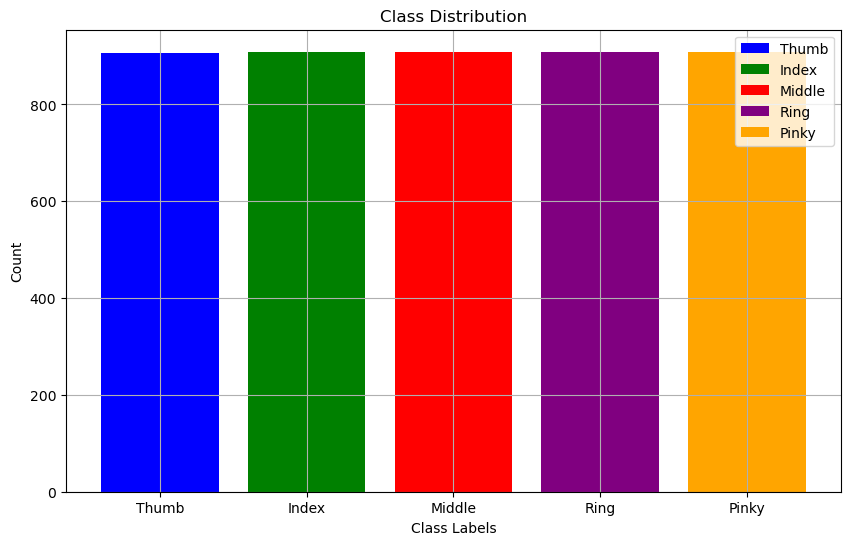

Class 1 (Thumb): 906 samples
Class 2 (Index): 909 samples
Class 3 (Middle): 909 samples
Class 4 (Ring): 909 samples
Class 5 (Pinky): 909 samples


In [ ]:
finger_names = {1: 'Thumb', 2: 'Index', 3: 'Middle', 4: 'Ring', 5: 'Pinky'}
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot size of each class
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 6))
for i, (label, count) in enumerate(zip(unique, counts)):
    plt.bar(label, count, color=colors[i], label=finger_names[label])
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique, [finger_names[label] for label in unique])
plt.legend()
plt.grid(True)
plt.show()

# Print size of each class
for label, count in zip(unique, counts):
    print(f"Class {label} ({finger_names[label]}): {count} samples")

##**Step 2: Preprocessing**

In [ ]:
# Define band-pass filter parameters
lowcut = 8.0
highcut = 30.0
order = 5

# Function to apply band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Apply band-pass filter to all trials and channels
filtered_data = np.zeros_like(X)
for trial in range(X.shape[2]):
    for channel in range(X.shape[1]):
        filtered_data[:, channel, trial] = bandpass_filter(X[:, channel, trial], lowcut, highcut, Fs, order=order)

# Common Average Referencing (CAR)
mean_signal = np.mean(filtered_data, axis=1, keepdims=True)
filtered_data -= mean_signal


selected_channels = [ 'T7',  'TP7', 'TP9','POz', 'Oz', 'O1', 'PO3',  'PO7']#"Temporal + Occipital + odd "
# selected_channels = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'] #"Frontal":
# selected_channels = ['FCz', 'Cz', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'] #"Central"
# selected_channels = ['CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'Pz', 'CPz']#"Parietal"
# selected_channels = ['POz', 'Oz', 'O1', 'O2', 'PO3', 'PO4', 'PO7', 'PO8']  #"Occipital":

# selected_channels = [ 'T7',  'TP7','PO3','POz'] # "Temporal + Occipital " best 4

# selected_channels = ['Fp1', 'Fpz', 'FT9', 'TP7', 'CP5', 'T8', 'C3', 'F2']# corr abs - and +
# selected_channels = ['TP7', 'CP5', 'T8', 'C3', 'F2', 'Fz', 'FC5', 'C1']# corr only  + # rest electrodes FT7, CP3, F4, C5, F8, FC3,F6, Cz



# Get indices of selected channels
channel_indices = [Channels.index(ch) for ch in selected_channels]

# Select only the specified channels
filtered_data_selected = filtered_data[:, channel_indices, :]

# Print shape to verify
print("Filtered and CAR Processed Data Shape (Selected Channels):", filtered_data_selected.shape)

# Reshape 3D data to 2D
reshaped_data = filtered_data_selected.reshape(-1, filtered_data_selected.shape[1])

# Apply RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(reshaped_data)

# Reshape back to 3D if necessary
scaled_data_3d = scaled_data.reshape(filtered_data_selected.shape)

print("Scaled Data Shape (Selected Channels):", scaled_data_3d.shape)


Filtered and CAR Processed Data Shape (Selected Channels): (256, 8, 4542)
Scaled Data Shape (Selected Channels): (256, 8, 4542)


##**Step 3: Split Data into Classes**

In [ ]:
# Initialize arrays for different classes (Thumb, Index, Middle, Ring, Pinky)
X_thumb, Y_thumb = None, None
X_index, Y_index = None, None
X_middle, Y_middle = None, None
X_ring, Y_ring = None, None
X_pinky, Y_pinky = None, None

# Function to split and assign data
def assign_data_to_class(class_label, scaled_data_3d, y, percentage=0.25):
    # Select the target trials for the current class
    target_trials = scaled_data_3d[:, :, y == class_label]
    num_target_trials = target_trials.shape[2]

    # Determine the number of non-target trials to select from each other class
    num_non_target_trials_per_class = int(percentage * num_target_trials)

    # Select the non-target trials from other classes (non-randomly, using the first 25%)
    non_target_trials = []
    for other_class_label in range(1, 6):
        if other_class_label != class_label:
            other_class_trials = scaled_data_3d[:, :, y == other_class_label]
            non_target_trials.append(other_class_trials[:, :, :num_non_target_trials_per_class])
    non_target_trials = np.concatenate(non_target_trials, axis=2)

    # Combine target and non-target trials
    combined_trials = np.concatenate((target_trials, non_target_trials), axis=2)
    combined_labels = np.array([1] * num_target_trials + [0] * non_target_trials.shape[2])  # 1 for target, 0 for non-target

    return combined_trials, combined_labels

# Assign data to each class
X_thumb, Y_thumb = assign_data_to_class(1, scaled_data_3d, y)
X_index, Y_index = assign_data_to_class(2, scaled_data_3d, y)
X_middle, Y_middle = assign_data_to_class(3, scaled_data_3d, y)
X_ring, Y_ring = assign_data_to_class(4, scaled_data_3d, y)
X_pinky, Y_pinky = assign_data_to_class(5, scaled_data_3d, y)

# Print shapes to verify
print("Thumb Data Shape (Trials):", X_thumb.shape, "Labels Shape:", Y_thumb.shape)
print("Index Data Shape (Trials):", X_index.shape, "Labels Shape:", Y_index.shape)
print("Middle Data Shape (Trials):", X_middle.shape, "Labels Shape:", Y_middle.shape)
print("Ring Data Shape (Trials):", X_ring.shape, "Labels Shape:", Y_ring.shape)
print("Pinky Data Shape (Trials):", X_pinky.shape, "Labels Shape:", Y_pinky.shape)


Thumb Data Shape (Trials): (256, 8, 1810) Labels Shape: (1810,)
Index Data Shape (Trials): (256, 8, 1817) Labels Shape: (1817,)
Middle Data Shape (Trials): (256, 8, 1817) Labels Shape: (1817,)
Ring Data Shape (Trials): (256, 8, 1817) Labels Shape: (1817,)
Pinky Data Shape (Trials): (256, 8, 1817) Labels Shape: (1817,)


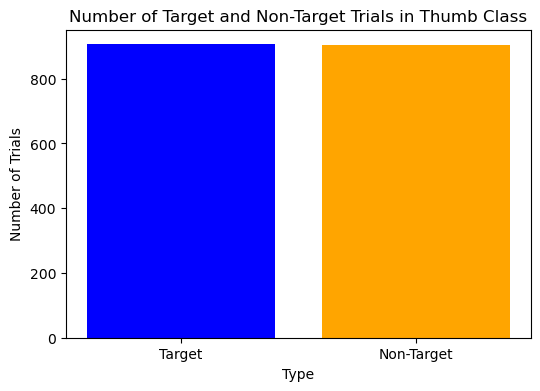

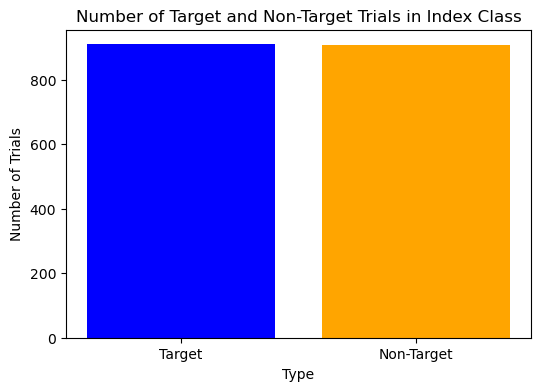

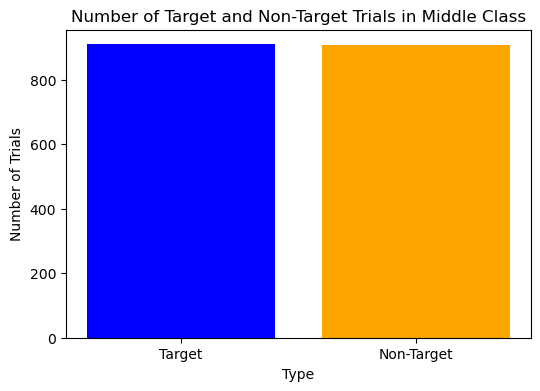

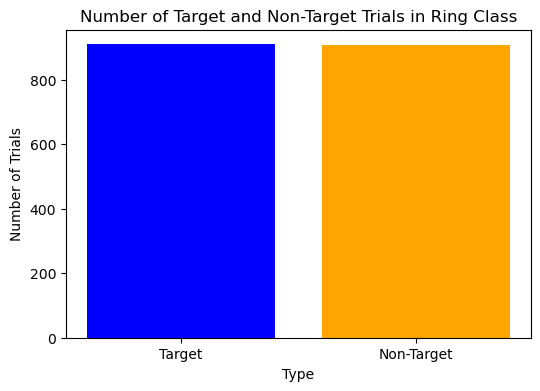

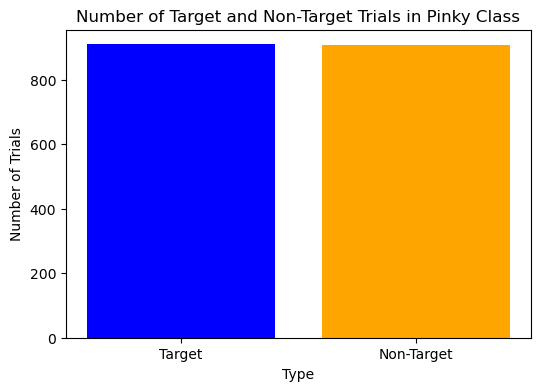

In [ ]:
# Function to plot bar plot for target and non-target counts
def plot_target_non_target_counts(class_name, Y):
    labels = ['Target', 'Non-Target']
    counts = [np.sum(Y == 1), np.sum(Y == 0)]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title(f'Number of Target and Non-Target Trials in {class_name} Class')
    plt.xlabel('Type')
    plt.ylabel('Number of Trials')
    plt.show()

# Plot target and non-target counts for each class
plot_target_non_target_counts('Thumb', Y_thumb)
plot_target_non_target_counts('Index', Y_index)
plot_target_non_target_counts('Middle', Y_middle)
plot_target_non_target_counts('Ring', Y_ring)
plot_target_non_target_counts('Pinky', Y_pinky)

##**Step 4: Feature Extraction**

In [ ]:
# Time domain features
def mean_voltage(data):
    return np.mean(data, axis=0)

def root_mean_square(data):
    return np.sqrt(np.mean(data**2, axis=0))

def zero_crossing_rate(data):
    return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0)

def signal_variability(data):
    return np.std(data, axis=0)

# Frequency domain features
def power_spectral_density(data, fs=256):
    f, psd = welch(data, fs=fs, nperseg=min(256, len(data)), axis=0)
    return np.mean(psd, axis=0)

def peak_frequency(data, fs=256):
    f, psd = welch(data, fs=fs, nperseg=min(256, len(data)), axis=0)
    return f[np.argmax(psd, axis=0)]

def spectral_entropy(data, fs=256):
    f, psd = welch(data, fs=fs, nperseg=min(256, len(data)), axis=0)
    psd_norm = psd / np.sum(psd, axis=0, keepdims=True)
    se = -np.sum(psd_norm * np.log(psd_norm + 1e-12), axis=0)
    return se

# Existing feature extraction functions
def hjorth_activity(data):
    return np.var(data, axis=0)

def hjorth_mobility(data):
    return np.sqrt(np.var(np.diff(data, axis=0), axis=0) / np.var(data, axis=0))

def hjorth_complexity(data):
    return hjorth_mobility(np.diff(data, axis=0)) / hjorth_mobility(data)

def tsallis_entropy(data, q):
    prob_data = np.histogram(data, bins=256, density=True)[0]
    return (1 - np.sum(prob_data ** q)) / (q - 1)

def shannon_entropy(data):
    prob_data = np.histogram(data, bins=256, density=True)[0]
    return -np.sum(prob_data * np.log(prob_data + 1e-12))

def extract_features(data):
    feature_lists_time = []
    feature_lists_freq = []
    num_trials = data.shape[2]
    num_channels = data.shape[1]

    for trial in range(num_trials):
        trial_data = data[:, :, trial]
        trial_features_time = []
        trial_features_freq = []

        # Time domain features extraction
        for channel in range(num_channels):
            channel_data = trial_data[:, channel]
            channel_features_time = [
                np.std(channel_data),
                np.median(channel_data),
                kurtosis(channel_data),
                np.sqrt(np.mean(channel_data**2)),
                skew(channel_data),
                np.mean(np.abs(channel_data - np.mean(channel_data))),
                zero_crossing_rate(channel_data),
                hjorth_activity(channel_data),
                hjorth_mobility(channel_data),
                hjorth_complexity(channel_data),
                np.mean(channel_data**2),
                np.mean(channel_data**2 - np.roll(channel_data, 1) * np.roll(channel_data, -1)),
                np.log(np.sqrt(np.sum(np.diff(channel_data)**2))),
                tsallis_entropy(channel_data, q=2),
            ]
            trial_features_time.extend(channel_features_time)

        # Frequency domain features extraction
        for channel in range(num_channels):
            channel_data = trial_data[:, channel]
            channel_features_freq = [
                power_spectral_density(channel_data),
                peak_frequency(channel_data),
                spectral_entropy(channel_data)
            ]
            trial_features_freq.extend(channel_features_freq)

        feature_lists_time.append(trial_features_time)
        feature_lists_freq.append(trial_features_freq)

    feature_matrix_time = np.array(feature_lists_time)
    feature_matrix_freq = np.array(feature_lists_freq)
    return feature_matrix_time, feature_matrix_freq


In [ ]:
X_thumb_features_time, X_thumb_features_freq = extract_features(X_thumb)
print("Thumb Train Data Time Domain Features Shape:", X_thumb_features_time.shape)
print("Thumb Train Data Frequency Domain Features Shape:", X_thumb_features_freq.shape)

X_index_features_time, X_index_features_freq = extract_features(X_index)
print("Index Train Data Time Domain Features Shape:", X_index_features_time.shape)
print("Index Train Data Frequency Domain Features Shape:", X_index_features_freq.shape)

X_middle_features_time, X_middle_features_freq = extract_features(X_middle)
print("Middle Train Data Time Domain Features Shape:", X_middle_features_time.shape)
print("Middle Train Data Frequency Domain Features Shape:", X_middle_features_freq.shape)

X_ring_features_time, X_ring_features_freq = extract_features(X_ring)
print("Ring Train Data Time Domain Features Shape:", X_ring_features_time.shape)
print("Ring Train Data Frequency Domain Features Shape:", X_ring_features_freq.shape)

X_pinky_features_time, X_pinky_features_freq = extract_features(X_pinky)
print("Pinky Train Data Time Domain Features Shape:", X_pinky_features_time.shape)
print("Pinky Train Data Frequency Domain Features Shape:", X_pinky_features_freq.shape)



Thumb Train Data Time Domain Features Shape: (1810, 112)
Thumb Train Data Frequency Domain Features Shape: (1810, 24)
Index Train Data Time Domain Features Shape: (1817, 112)
Index Train Data Frequency Domain Features Shape: (1817, 24)
Middle Train Data Time Domain Features Shape: (1817, 112)
Middle Train Data Frequency Domain Features Shape: (1817, 24)
Ring Train Data Time Domain Features Shape: (1817, 112)
Ring Train Data Frequency Domain Features Shape: (1817, 24)
Pinky Train Data Time Domain Features Shape: (1817, 112)
Pinky Train Data Frequency Domain Features Shape: (1817, 24)


##**Step 5: Split Data into train and test**

In [ ]:
# Function to split data into train and test sets
def split_data(trials, labels):
    # Split into train and test sets (80:20 ratio)
    train_trials, test_trials, train_labels, test_labels = train_test_split(trials, labels, test_size=0.2, random_state=42, stratify=labels)

    return train_trials, test_trials, train_labels, test_labels

In [ ]:
# Thumb
X_train_thumb_features_time, X_test_thumb_features_time, Y_train_thumb, Y_test_thumb = split_data(X_thumb_features_time, Y_thumb)
X_train_thumb_features_freq, X_test_thumb_features_freq, Y_train_thumb, Y_test_thumb = split_data(X_thumb_features_freq, Y_thumb)

print(f"Thumb Time Domain Train Shape: {X_train_thumb_features_time.shape}, Test Shape: {X_test_thumb_features_time.shape}")
print(f"Thumb Frequency Domain Train Shape: {X_train_thumb_features_freq.shape}, Test Shape: {X_test_thumb_features_freq.shape}")

# Index
X_train_index_features_time, X_test_index_features_time, Y_train_index, Y_test_index = split_data(X_index_features_time, Y_index)
X_train_index_features_freq, X_test_index_features_freq, Y_train_index, Y_test_index = split_data(X_index_features_freq, Y_index)

print(f"Index Time Domain Train Shape: {X_train_index_features_time.shape}, Test Shape: {X_test_index_features_time.shape}")
print(f"Index Frequency Domain Train Shape: {X_train_index_features_freq.shape}, Test Shape: {X_test_index_features_freq.shape}")

# Middle
X_train_middle_features_time, X_test_middle_features_time, Y_train_middle, Y_test_middle = split_data(X_middle_features_time, Y_middle)
X_train_middle_features_freq, X_test_middle_features_freq, Y_train_middle, Y_test_middle = split_data(X_middle_features_freq, Y_middle)

print(f"Middle Time Domain Train Shape: {X_train_middle_features_time.shape}, Test Shape: {X_test_middle_features_time.shape}")
print(f"Middle Frequency Domain Train Shape: {X_train_middle_features_freq.shape}, Test Shape: {X_test_middle_features_freq.shape}")

# Ring
X_train_ring_features_time, X_test_ring_features_time, Y_train_ring, Y_test_ring = split_data(X_ring_features_time, Y_ring)
X_train_ring_features_freq, X_test_ring_features_freq, Y_train_ring, Y_test_ring = split_data(X_ring_features_freq, Y_ring)

print(f"Ring Time Domain Train Shape: {X_train_ring_features_time.shape}, Test Shape: {X_test_ring_features_time.shape}")
print(f"Ring Frequency Domain Train Shape: {X_train_ring_features_freq.shape}, Test Shape: {X_test_ring_features_freq.shape}")

# Pinky
X_train_pinky_features_time, X_test_pinky_features_time, Y_train_pinky, Y_test_pinky = split_data(X_pinky_features_time, Y_pinky)
X_train_pinky_features_freq, X_test_pinky_features_freq, Y_train_pinky, Y_test_pinky = split_data(X_pinky_features_freq, Y_pinky)

print(f"Pinky Time Domain Train Shape: {X_train_pinky_features_time.shape}, Test Shape: {X_test_pinky_features_time.shape}")
print(f"Pinky Frequency Domain Train Shape: {X_train_pinky_features_freq.shape}, Test Shape: {X_test_pinky_features_freq.shape}")

Thumb Time Domain Train Shape: (1448, 112), Test Shape: (362, 112)
Thumb Frequency Domain Train Shape: (1448, 24), Test Shape: (362, 24)
Index Time Domain Train Shape: (1453, 112), Test Shape: (364, 112)
Index Frequency Domain Train Shape: (1453, 24), Test Shape: (364, 24)
Middle Time Domain Train Shape: (1453, 112), Test Shape: (364, 112)
Middle Frequency Domain Train Shape: (1453, 24), Test Shape: (364, 24)
Ring Time Domain Train Shape: (1453, 112), Test Shape: (364, 112)
Ring Frequency Domain Train Shape: (1453, 24), Test Shape: (364, 24)
Pinky Time Domain Train Shape: (1453, 112), Test Shape: (364, 112)
Pinky Frequency Domain Train Shape: (1453, 24), Test Shape: (364, 24)


##**Step 6 : ML Models**

##**6.1 Evaluation Time and Frequancy feature in seperatly**

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Function to evaluate and print results
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}%")
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.show()

    return accuracy, report, conf_matrix

In [ ]:
# List of classifiers to be applied
classifiers = {
    "LDA": LDA(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Dictionary mapping each finger class to its respective data and features
finger_data = {
    "Thumb": {
        "Time Domain": (X_train_thumb_features_time, X_test_thumb_features_time, Y_train_thumb, Y_test_thumb),
        "Frequency Domain": (X_train_thumb_features_freq, X_test_thumb_features_freq, Y_train_thumb, Y_test_thumb)
    },
    "Index": {
        "Time Domain": (X_train_index_features_time, X_test_index_features_time, Y_train_index, Y_test_index),
        "Frequency Domain": (X_train_index_features_freq, X_test_index_features_freq, Y_train_index, Y_test_index)
    },
    "Middle": {
        "Time Domain": (X_train_middle_features_time, X_test_middle_features_time, Y_train_middle, Y_test_middle),
        "Frequency Domain": (X_train_middle_features_freq, X_test_middle_features_freq, Y_train_middle, Y_test_middle)
    },
    "Ring": {
        "Time Domain": (X_train_ring_features_time, X_test_ring_features_time, Y_train_ring, Y_test_ring),
        "Frequency Domain": (X_train_ring_features_freq, X_test_ring_features_freq, Y_train_ring, Y_test_ring)
    },
    "Pinky": {
        "Time Domain": (X_train_pinky_features_time, X_test_pinky_features_time, Y_train_pinky, Y_test_pinky),
        "Frequency Domain": (X_train_pinky_features_freq, X_test_pinky_features_freq, Y_train_pinky, Y_test_pinky)
    }
}

results = {finger: {domain: {name: {'accuracy': 0, 'report': '', 'conf_matrix': np.zeros((3, 3), dtype=int)} for name in classifiers} for domain, (X_train, X_test, y_train, y_test) in data.items()} for finger, data in finger_data.items()}




Finger Class: Thumb


Time Domain:

LDA:
Accuracy: 73.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       181
           1       0.73      0.73      0.73       181

    accuracy                           0.73       362
   macro avg       0.73      0.73      0.73       362
weighted avg       0.73      0.73      0.73       362



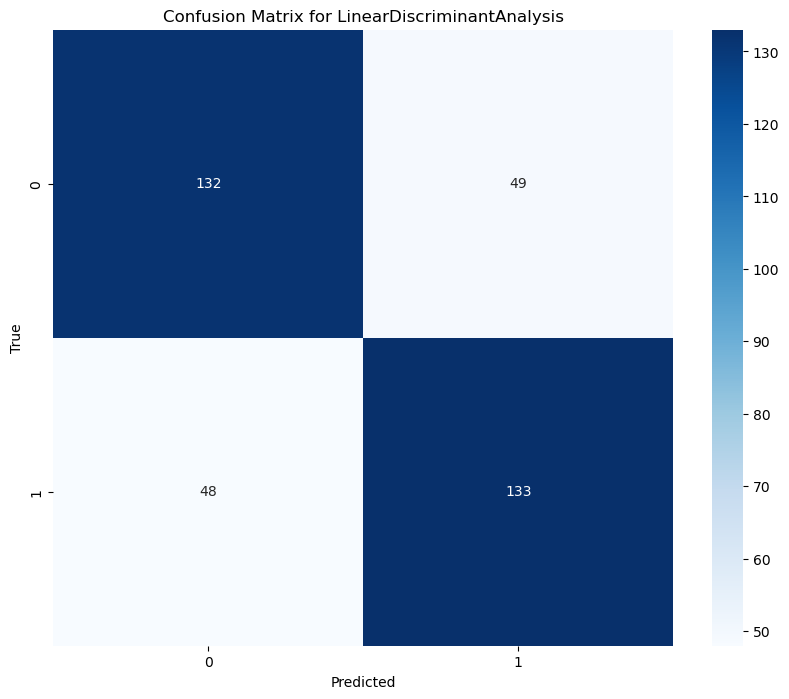


Logistic Regression:
Accuracy: 75.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       181
           1       0.77      0.72      0.74       181

    accuracy                           0.75       362
   macro avg       0.75      0.75      0.75       362
weighted avg       0.75      0.75      0.75       362



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


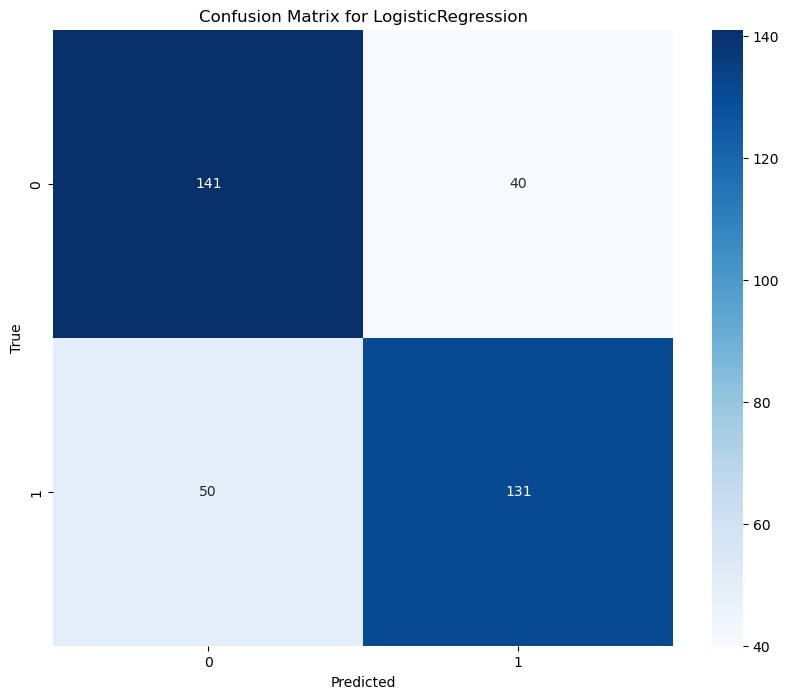


KNN:
Accuracy: 61.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       181
           1       0.61      0.67      0.64       181

    accuracy                           0.62       362
   macro avg       0.62      0.62      0.62       362
weighted avg       0.62      0.62      0.62       362



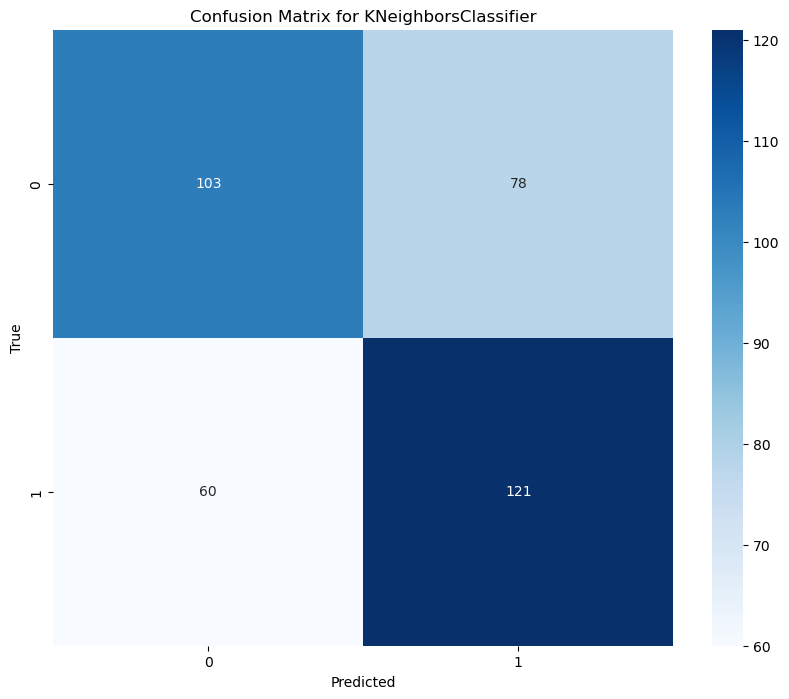


Random Forest:
Accuracy: 74.59%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       181
           1       0.76      0.72      0.74       181

    accuracy                           0.75       362
   macro avg       0.75      0.75      0.75       362
weighted avg       0.75      0.75      0.75       362



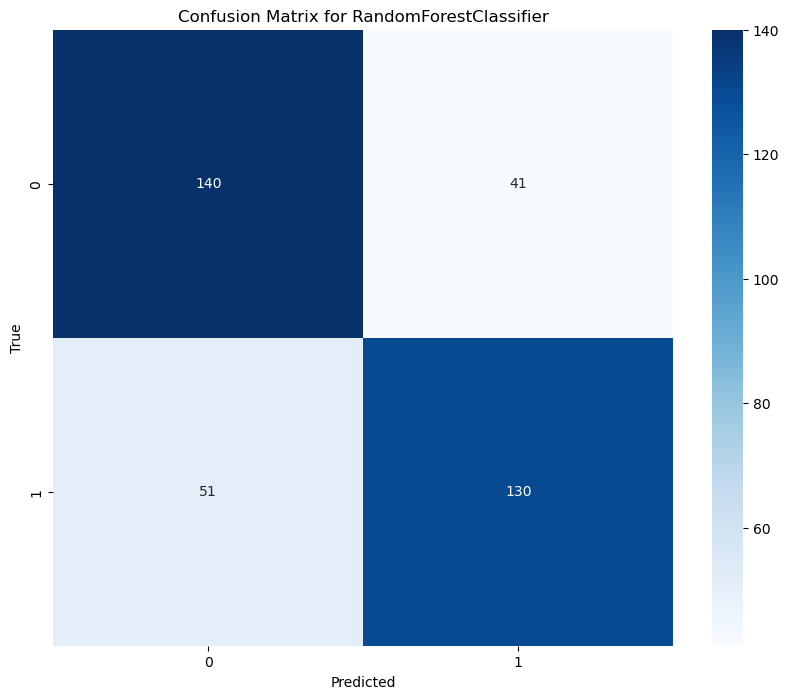


Decision Tree:
Accuracy: 66.85%
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       181
           1       0.67      0.65      0.66       181

    accuracy                           0.67       362
   macro avg       0.67      0.67      0.67       362
weighted avg       0.67      0.67      0.67       362



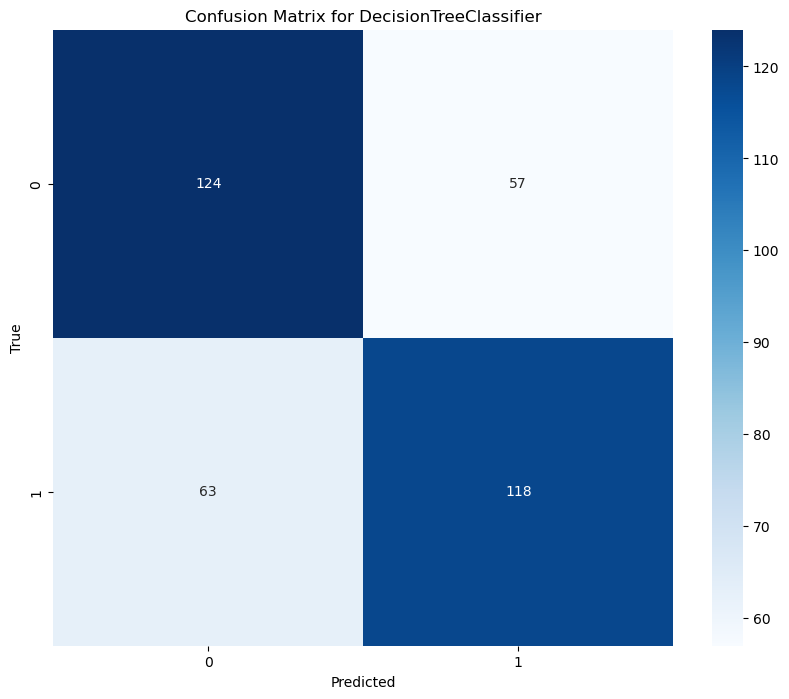


Gradient Boosting:
Accuracy: 75.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       181
           1       0.77      0.72      0.75       181

    accuracy                           0.75       362
   macro avg       0.76      0.75      0.75       362
weighted avg       0.76      0.75      0.75       362



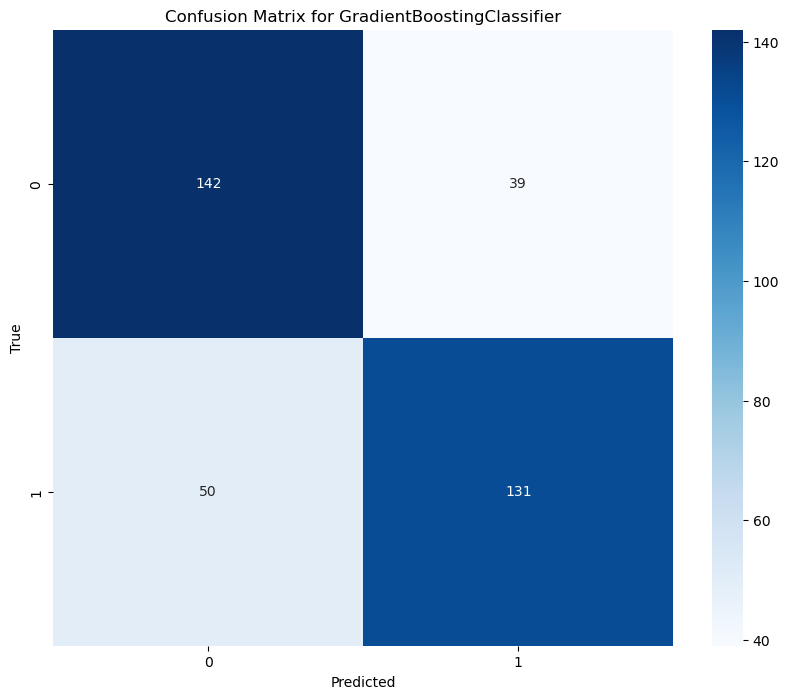


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 75.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       181
           1       0.75      0.78      0.77       181

    accuracy                           0.76       362
   macro avg       0.76      0.76      0.76       362
weighted avg       0.76      0.76      0.76       362



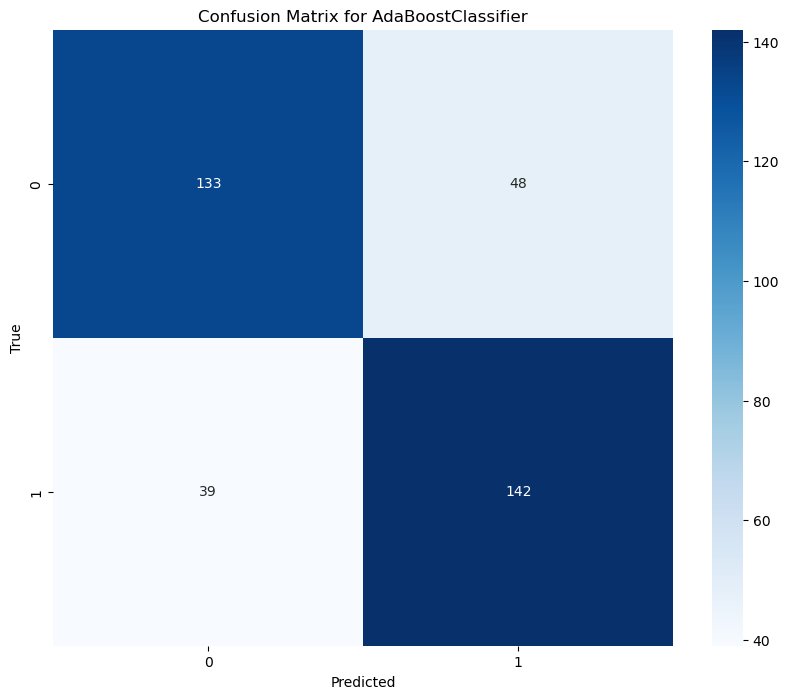


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 71.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       181
           1       0.72      0.71      0.72       181

    accuracy                           0.72       362
   macro avg       0.72      0.72      0.72       362
weighted avg       0.72      0.72      0.72       362



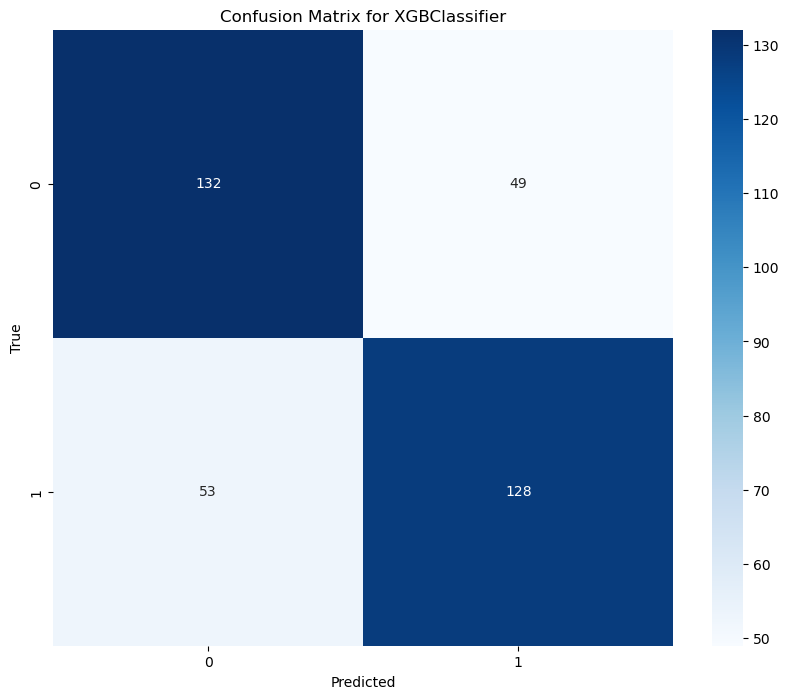


Frequency Domain:

LDA:
Accuracy: 69.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       181
           1       0.73      0.61      0.67       181

    accuracy                           0.69       362
   macro avg       0.70      0.69      0.69       362
weighted avg       0.70      0.69      0.69       362



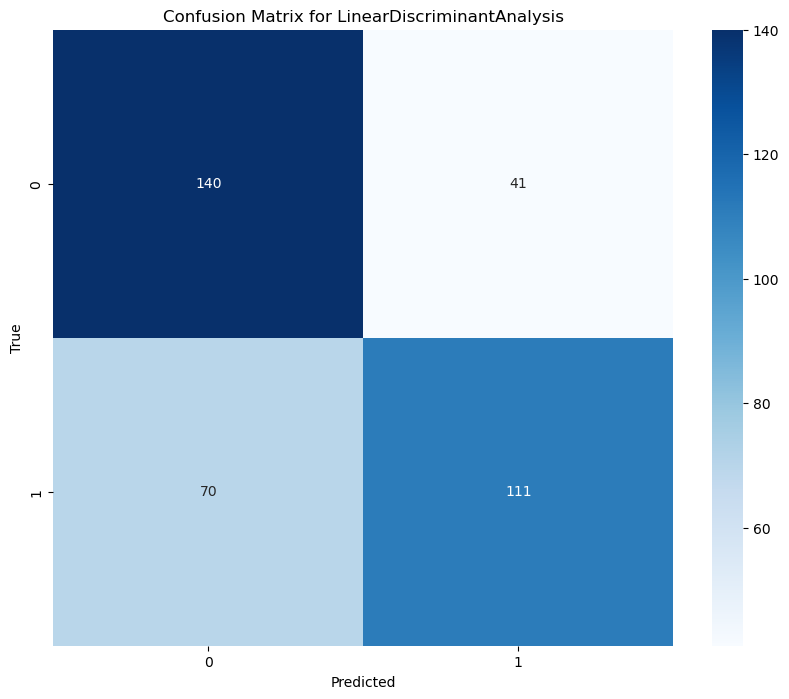


Logistic Regression:
Accuracy: 67.96%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       181
           1       0.72      0.60      0.65       181

    accuracy                           0.68       362
   macro avg       0.68      0.68      0.68       362
weighted avg       0.68      0.68      0.68       362



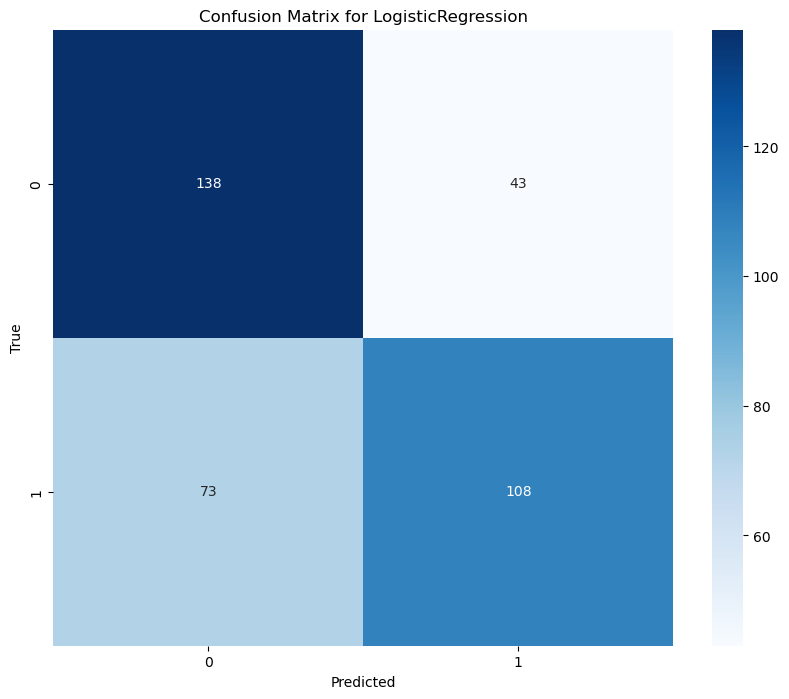


KNN:
Accuracy: 57.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.49      0.53       181
           1       0.56      0.65      0.60       181

    accuracy                           0.57       362
   macro avg       0.57      0.57      0.57       362
weighted avg       0.57      0.57      0.57       362



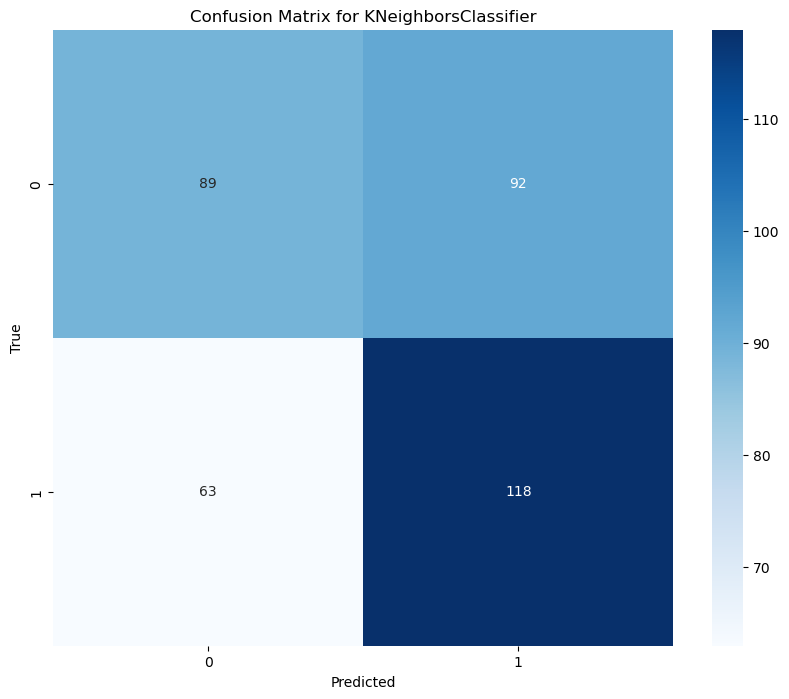


Random Forest:
Accuracy: 81.49%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       181
           1       0.86      0.75      0.80       181

    accuracy                           0.81       362
   macro avg       0.82      0.81      0.81       362
weighted avg       0.82      0.81      0.81       362



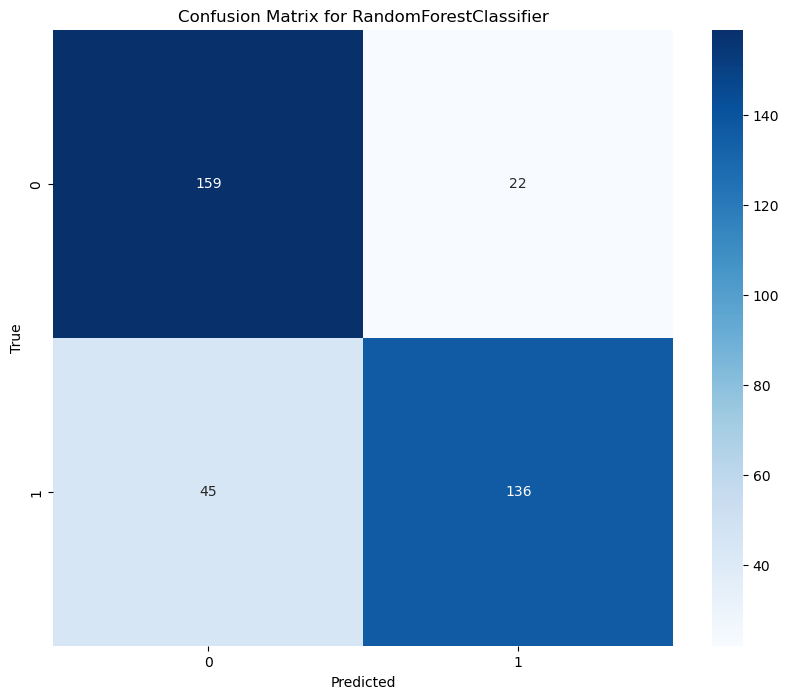


Decision Tree:
Accuracy: 72.10%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       181
           1       0.71      0.76      0.73       181

    accuracy                           0.72       362
   macro avg       0.72      0.72      0.72       362
weighted avg       0.72      0.72      0.72       362



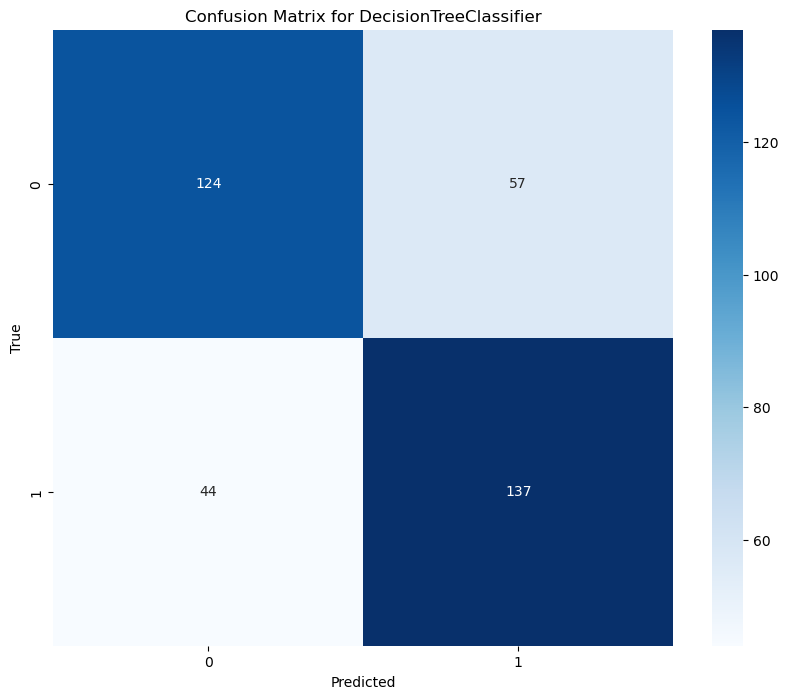


Gradient Boosting:
Accuracy: 80.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       181
           1       0.84      0.75      0.79       181

    accuracy                           0.80       362
   macro avg       0.80      0.80      0.80       362
weighted avg       0.80      0.80      0.80       362



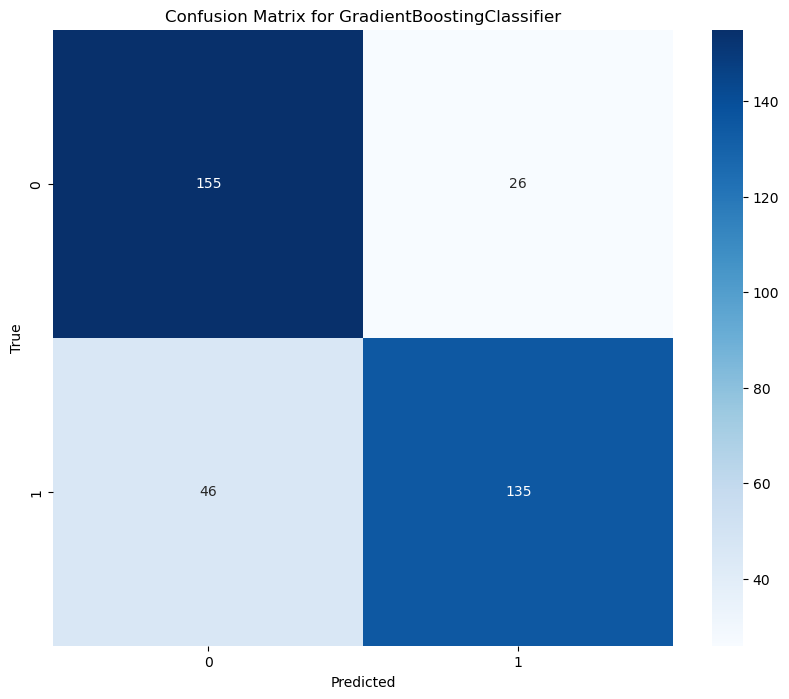


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 76.52%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       181
           1       0.78      0.74      0.76       181

    accuracy                           0.77       362
   macro avg       0.77      0.77      0.77       362
weighted avg       0.77      0.77      0.77       362



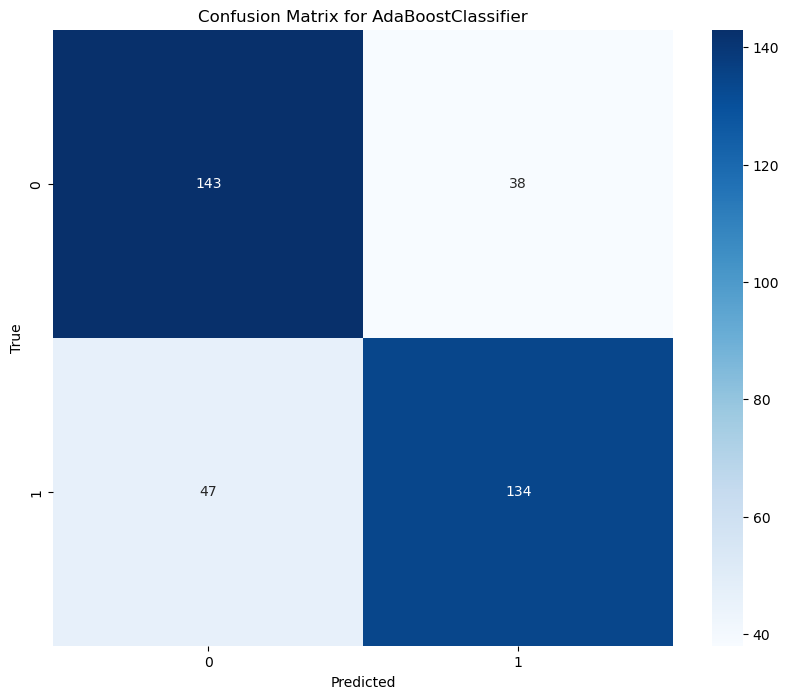


XGBoost:
Accuracy: 78.73%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       181
           1       0.79      0.78      0.79       181

    accuracy                           0.79       362
   macro avg       0.79      0.79      0.79       362
weighted avg       0.79      0.79      0.79       362



/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


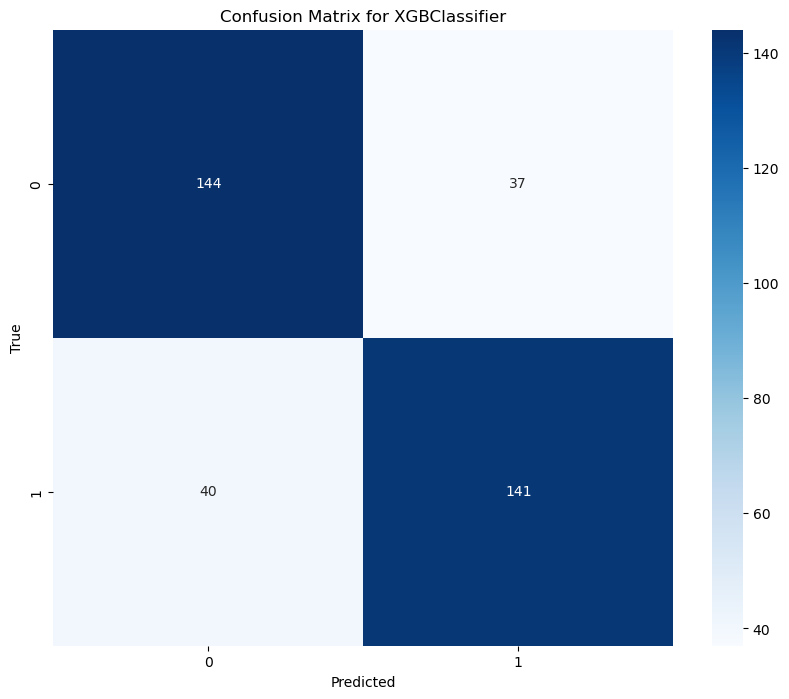



Finger Class: Index


Time Domain:

LDA:
Accuracy: 77.47%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       182
           1       0.78      0.77      0.77       182

    accuracy                           0.77       364
   macro avg       0.77      0.77      0.77       364
weighted avg       0.77      0.77      0.77       364



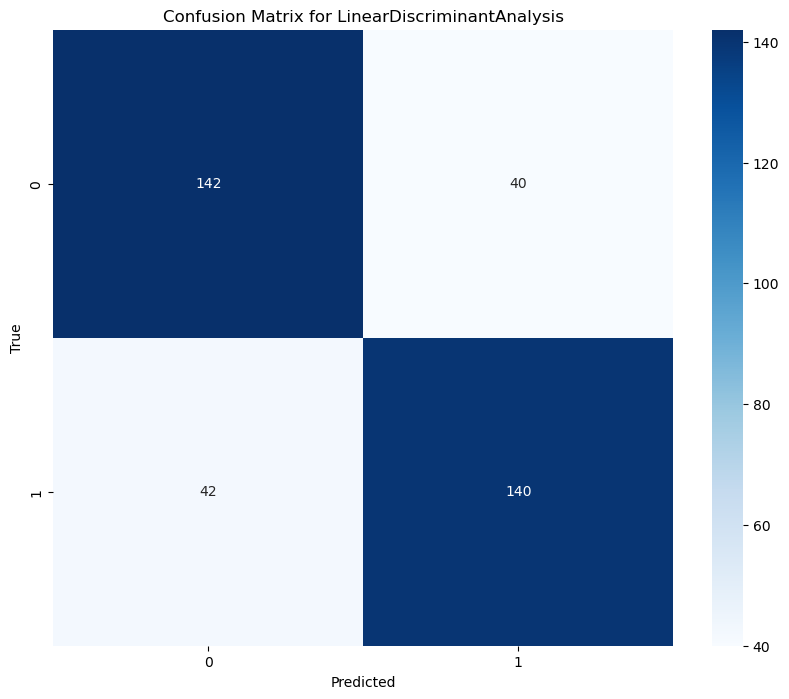


Logistic Regression:
Accuracy: 76.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       182
           1       0.77      0.77      0.77       182

    accuracy                           0.77       364
   macro avg       0.77      0.77      0.77       364
weighted avg       0.77      0.77      0.77       364



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


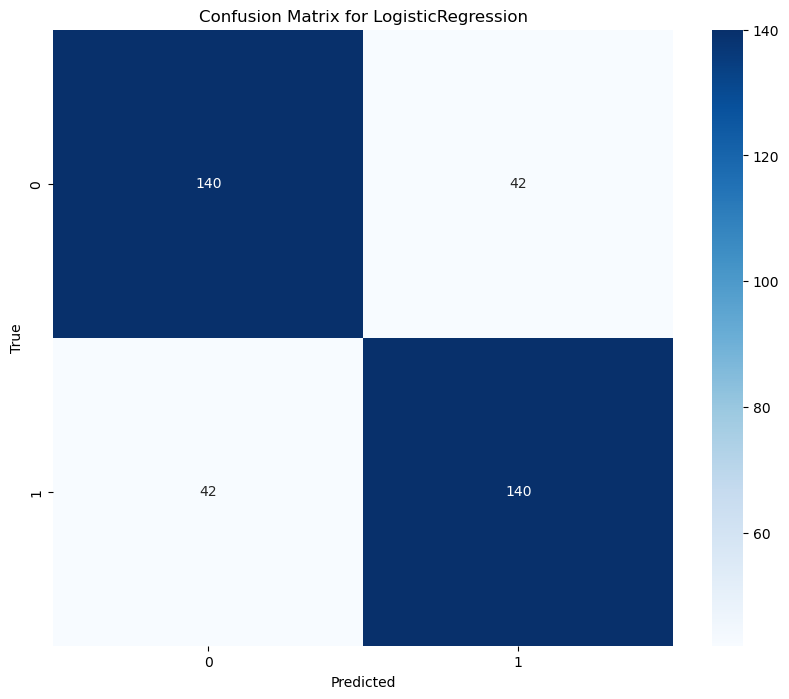


KNN:
Accuracy: 61.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       182
           1       0.63      0.58      0.60       182

    accuracy                           0.62       364
   macro avg       0.62      0.62      0.62       364
weighted avg       0.62      0.62      0.62       364



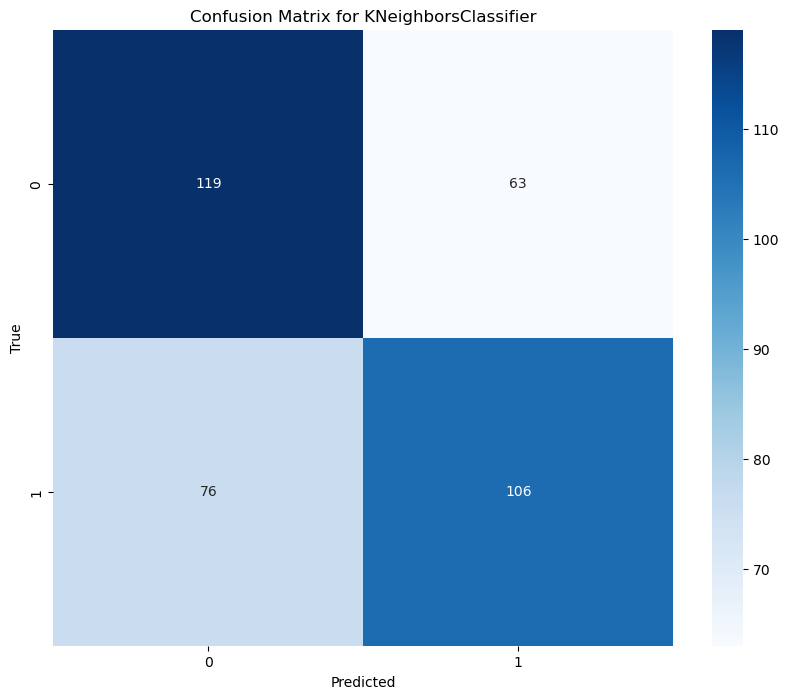


Random Forest:
Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       182
           1       0.77      0.71      0.74       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



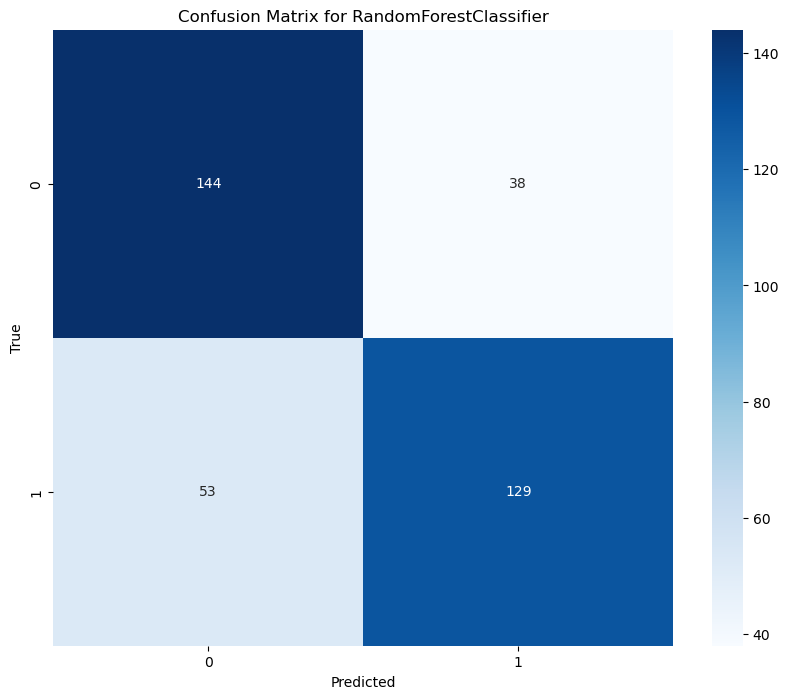


Decision Tree:
Accuracy: 65.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       182
           1       0.67      0.59      0.63       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



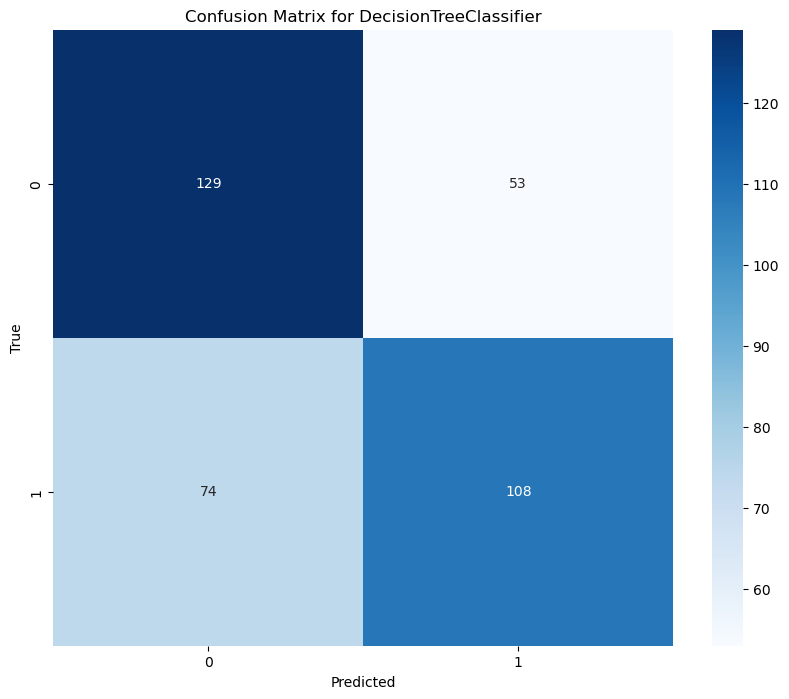


Gradient Boosting:
Accuracy: 74.73%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       182
           1       0.78      0.69      0.73       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



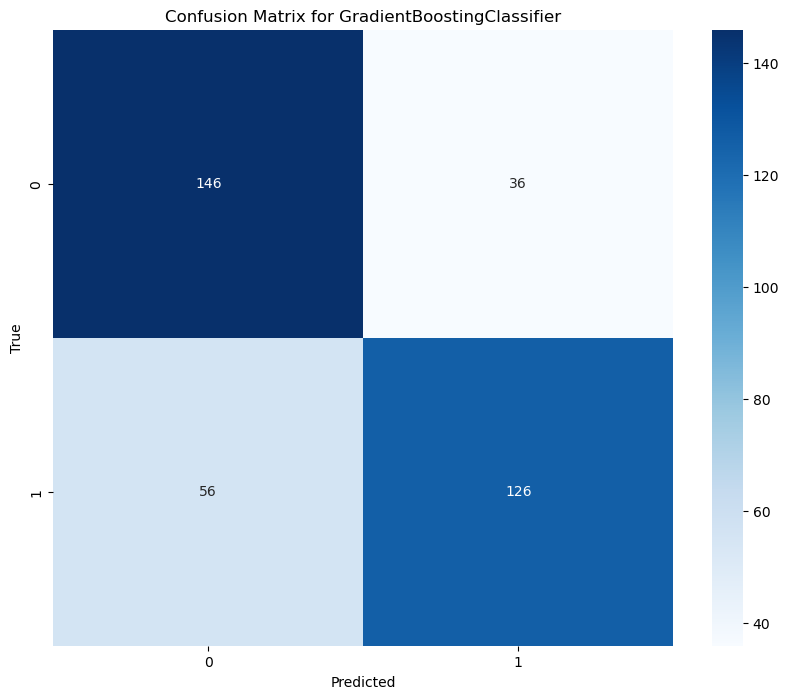


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 71.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       182
           1       0.71      0.71      0.71       182

    accuracy                           0.71       364
   macro avg       0.71      0.71      0.71       364
weighted avg       0.71      0.71      0.71       364



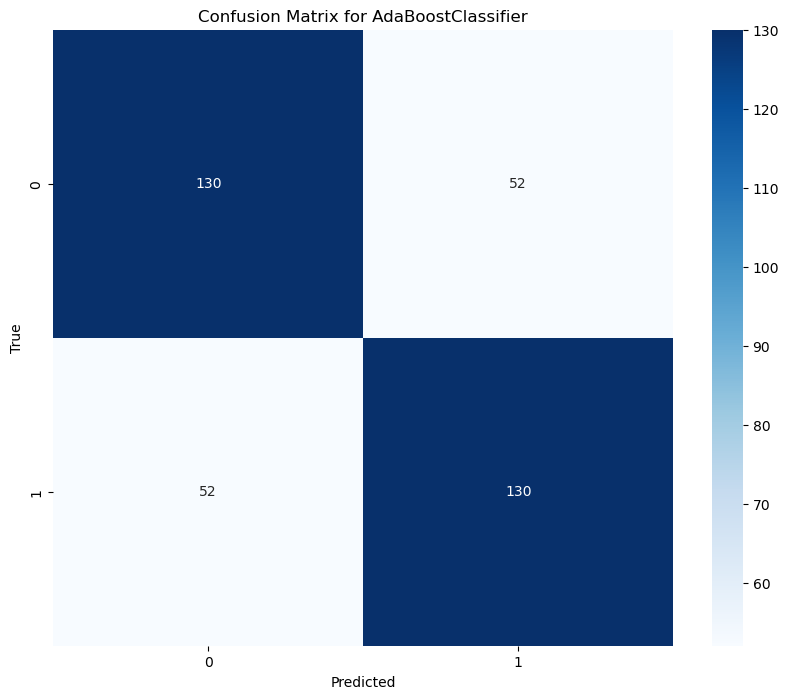


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       182
           1       0.77      0.72      0.74       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



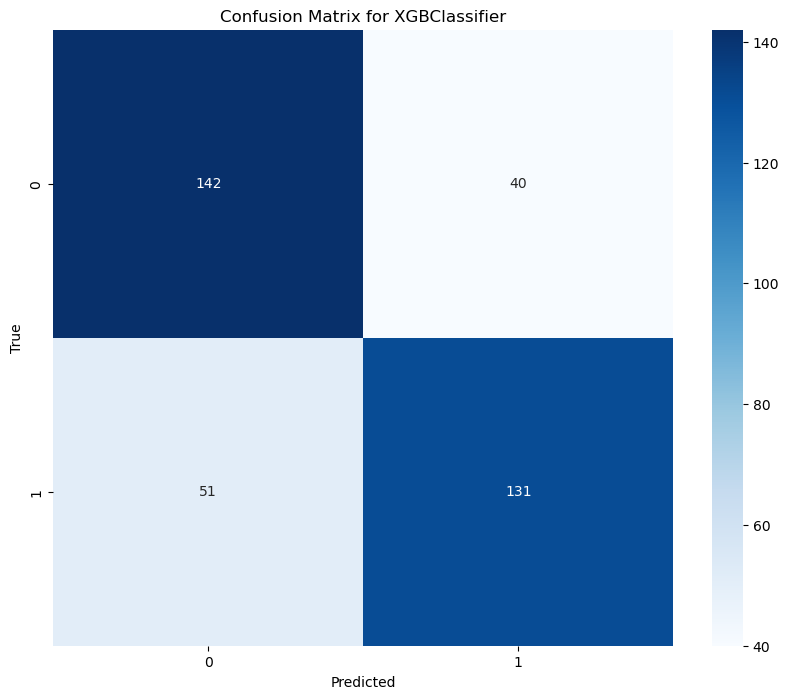


Frequency Domain:

LDA:
Accuracy: 70.05%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       182
           1       0.71      0.69      0.70       182

    accuracy                           0.70       364
   macro avg       0.70      0.70      0.70       364
weighted avg       0.70      0.70      0.70       364



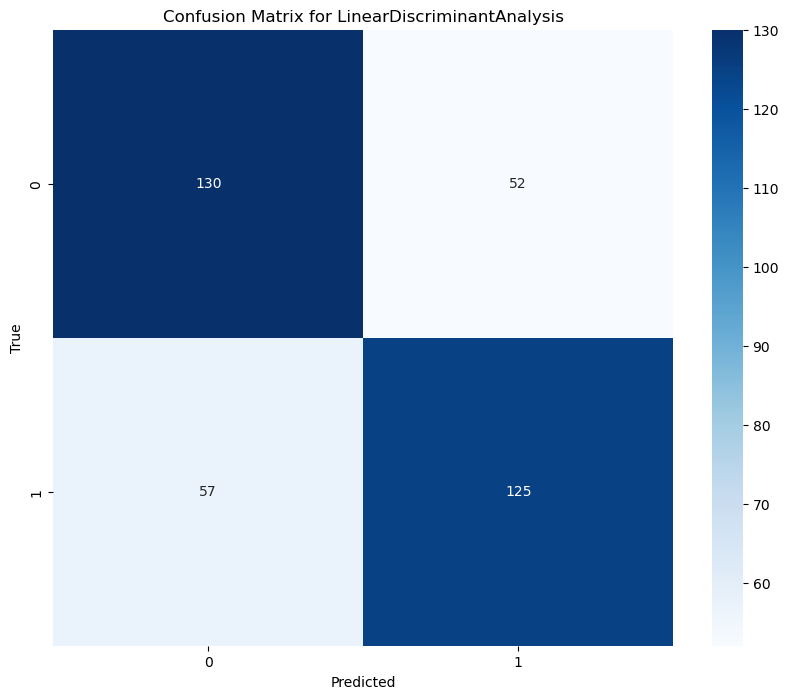


Logistic Regression:
Accuracy: 70.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       182
           1       0.71      0.69      0.70       182

    accuracy                           0.70       364
   macro avg       0.70      0.70      0.70       364
weighted avg       0.70      0.70      0.70       364



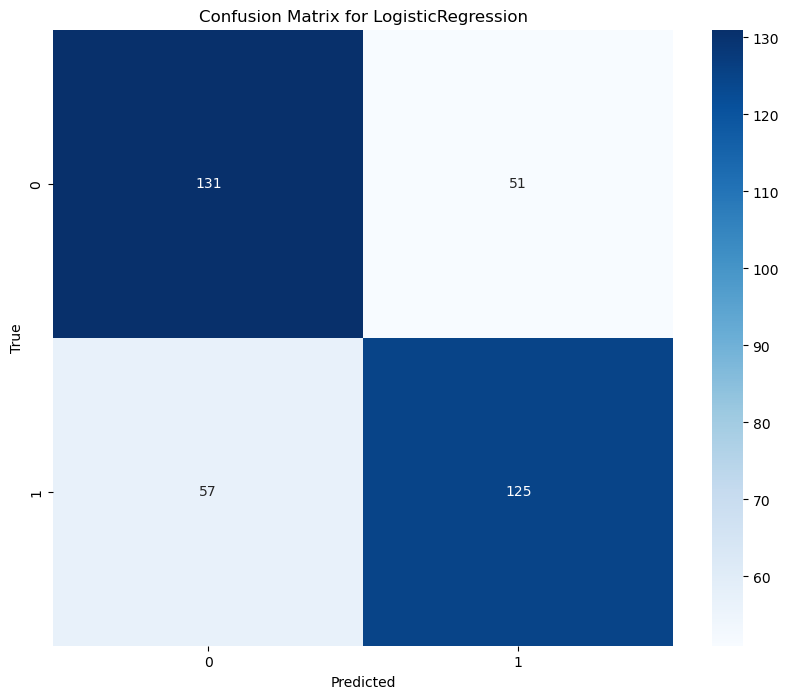


KNN:
Accuracy: 56.87%
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.53      0.55       182
           1       0.56      0.61      0.59       182

    accuracy                           0.57       364
   macro avg       0.57      0.57      0.57       364
weighted avg       0.57      0.57      0.57       364



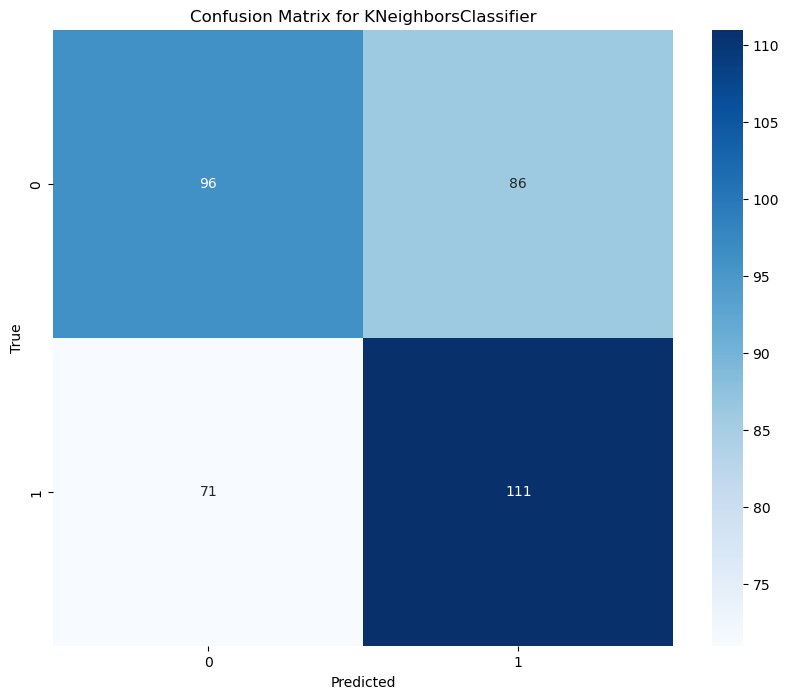


Random Forest:
Accuracy: 84.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       182
           1       0.89      0.78      0.83       182

    accuracy                           0.84       364
   macro avg       0.85      0.84      0.84       364
weighted avg       0.85      0.84      0.84       364



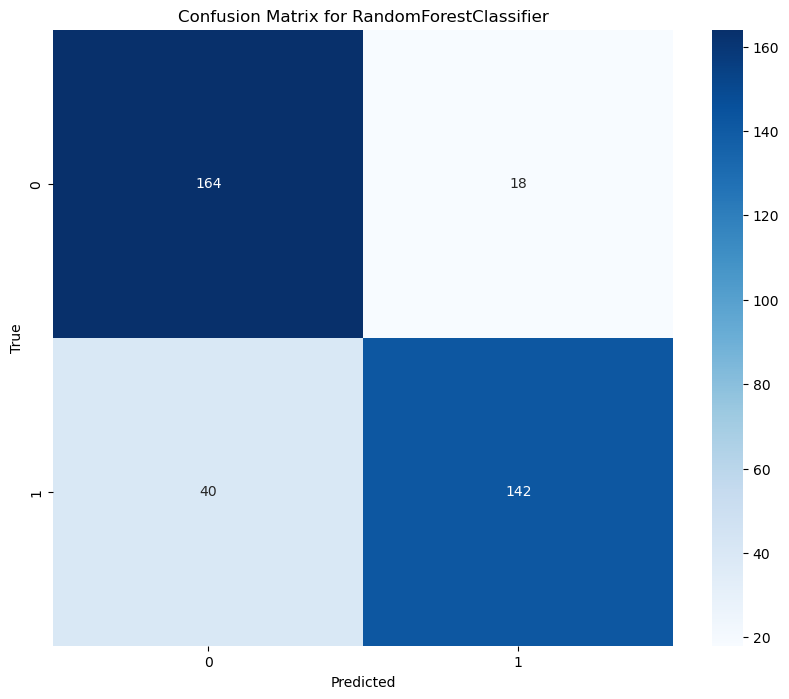


Decision Tree:
Accuracy: 72.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       182
           1       0.72      0.73      0.73       182

    accuracy                           0.73       364
   macro avg       0.73      0.73      0.73       364
weighted avg       0.73      0.73      0.73       364



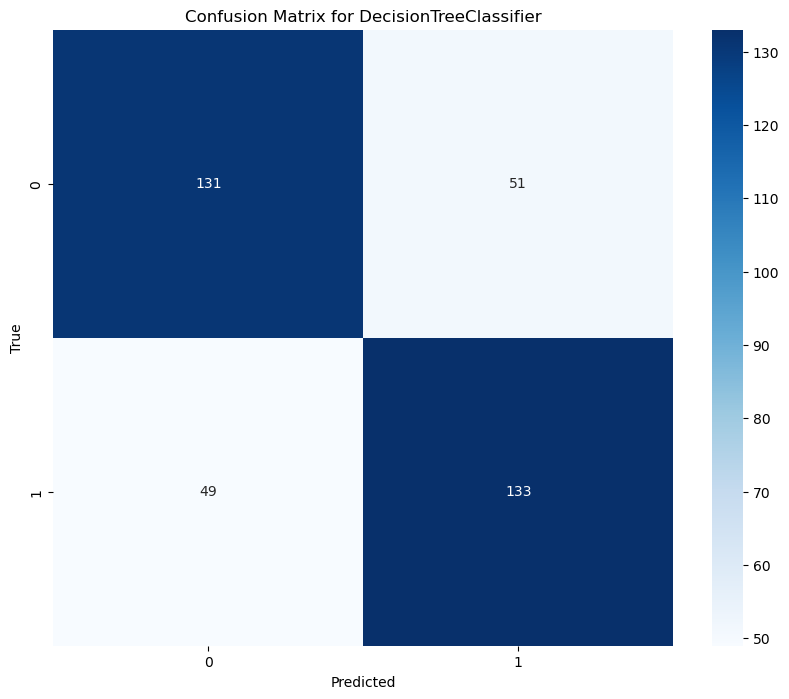


Gradient Boosting:
Accuracy: 81.59%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       182
           1       0.86      0.76      0.80       182

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.82       364
weighted avg       0.82      0.82      0.82       364



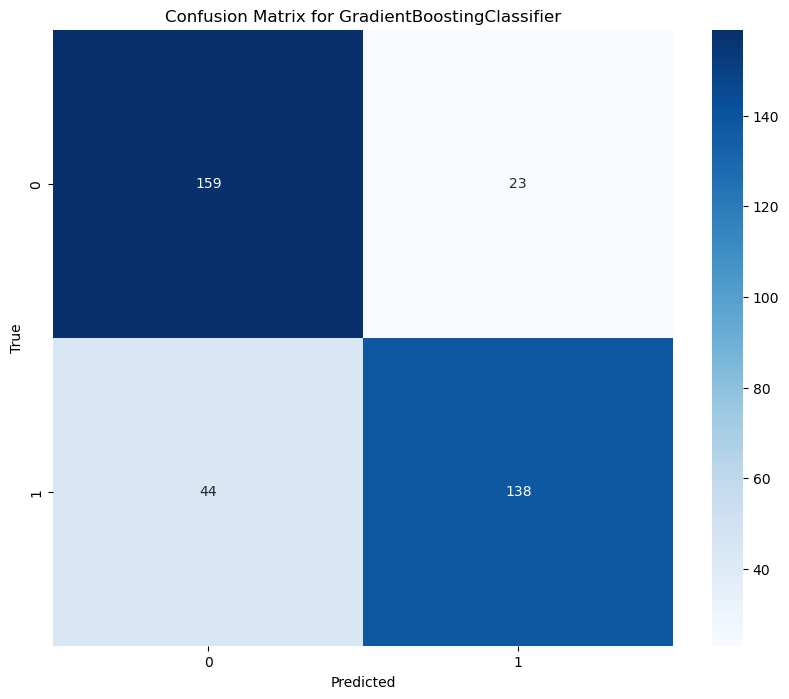


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 78.30%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       182
           1       0.81      0.74      0.77       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



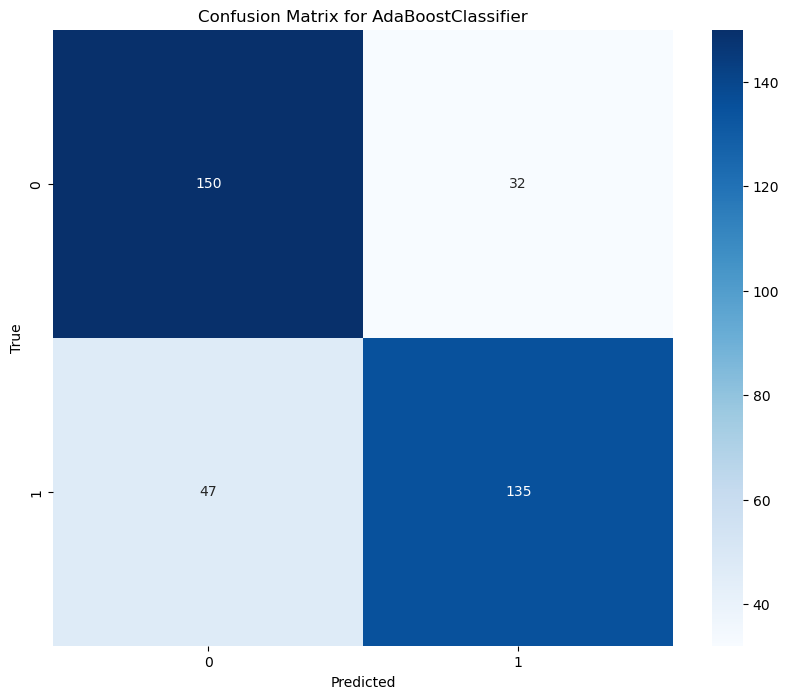


XGBoost:
Accuracy: 80.77%
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.81       182
           1       0.83      0.77      0.80       182

    accuracy                           0.81       364
   macro avg       0.81      0.81      0.81       364
weighted avg       0.81      0.81      0.81       364



/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


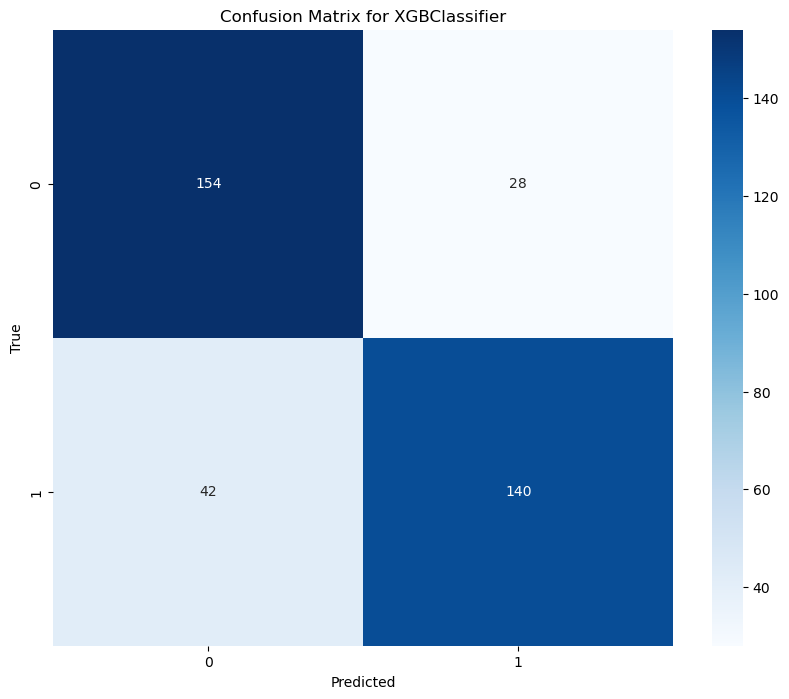



Finger Class: Middle


Time Domain:

LDA:
Accuracy: 74.45%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.75       182
           1       0.77      0.70      0.73       182

    accuracy                           0.74       364
   macro avg       0.75      0.74      0.74       364
weighted avg       0.75      0.74      0.74       364



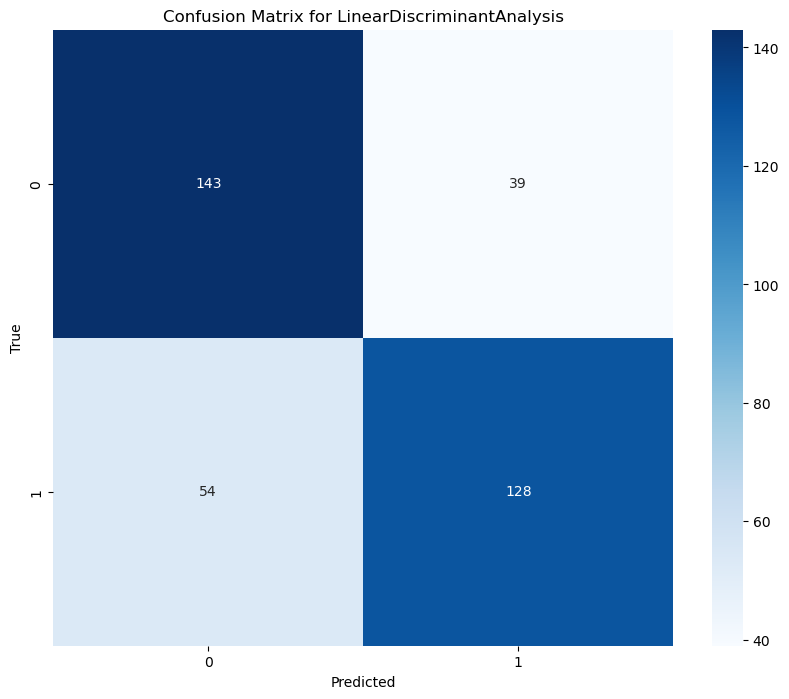


Logistic Regression:


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 75.27%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       182
           1       0.76      0.74      0.75       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



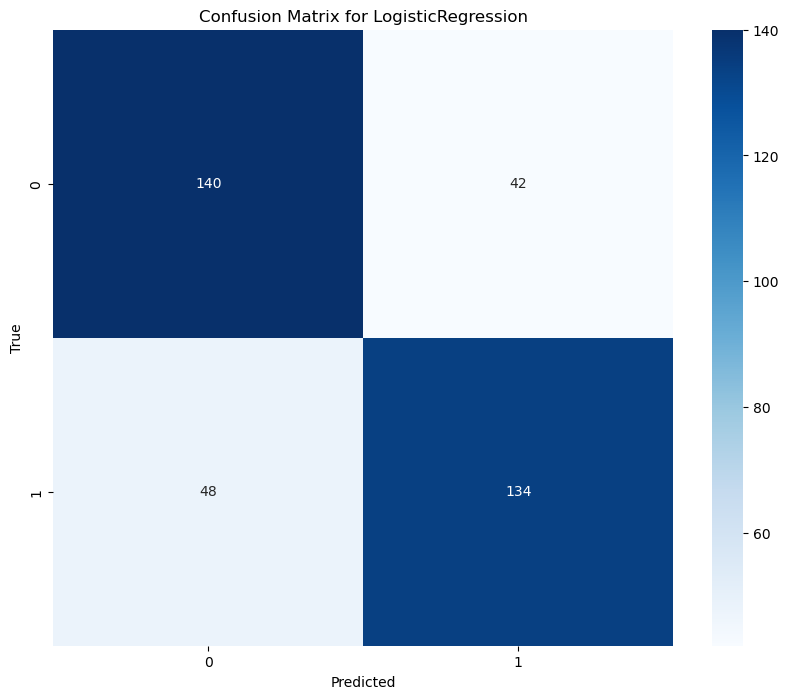


KNN:
Accuracy: 68.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       182
           1       0.67      0.74      0.70       182

    accuracy                           0.68       364
   macro avg       0.69      0.68      0.68       364
weighted avg       0.69      0.68      0.68       364



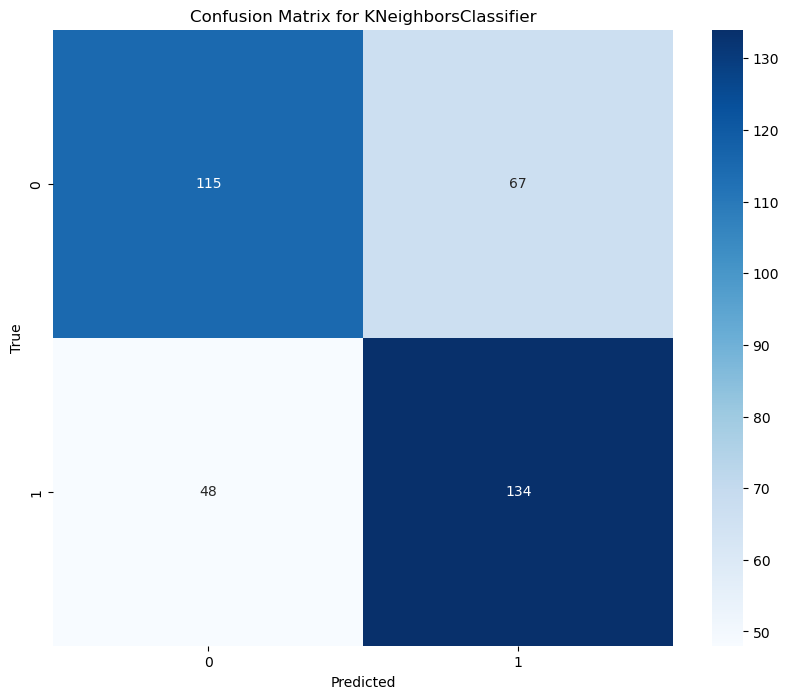


Random Forest:
Accuracy: 77.47%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79       182
           1       0.80      0.73      0.76       182

    accuracy                           0.77       364
   macro avg       0.78      0.77      0.77       364
weighted avg       0.78      0.77      0.77       364



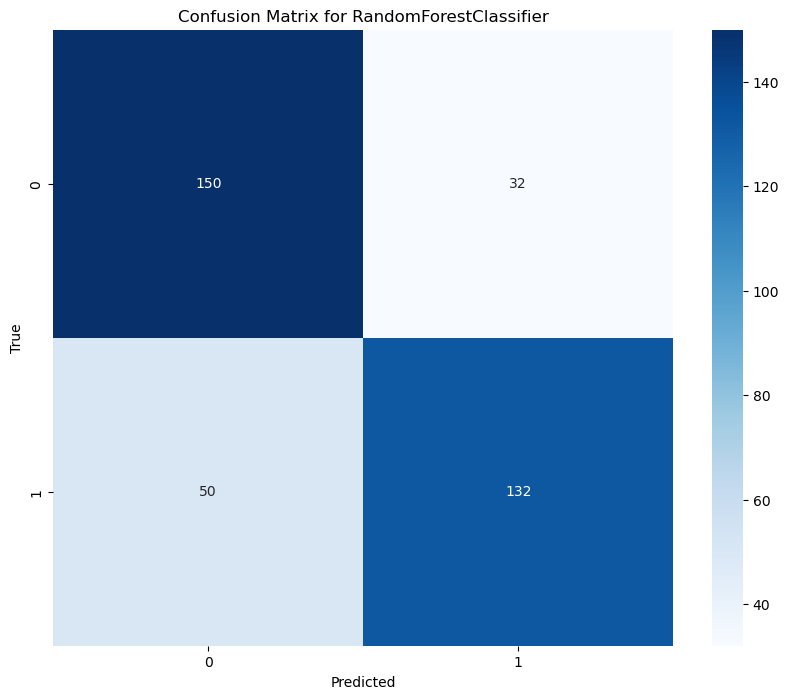


Decision Tree:
Accuracy: 64.01%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       182
           1       0.64      0.64      0.64       182

    accuracy                           0.64       364
   macro avg       0.64      0.64      0.64       364
weighted avg       0.64      0.64      0.64       364



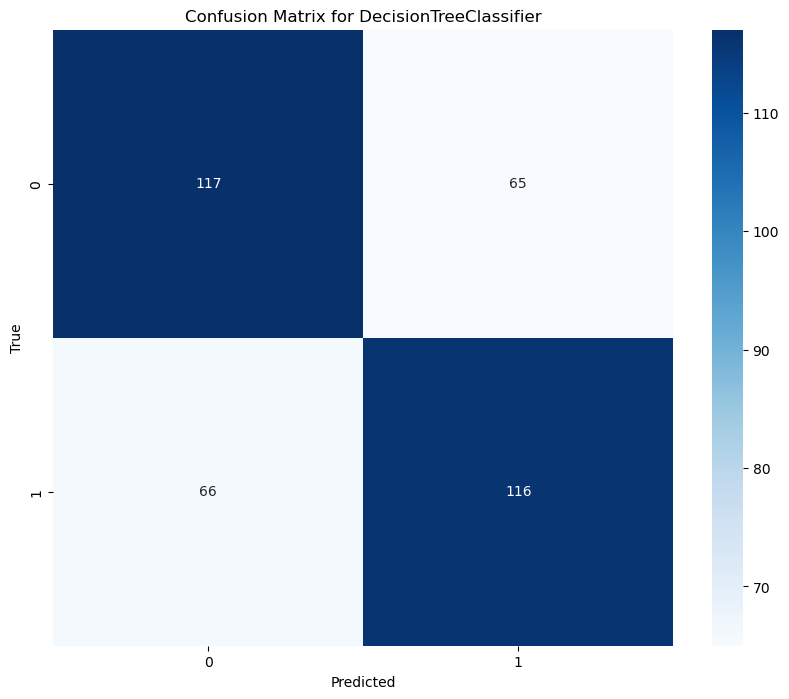


Gradient Boosting:
Accuracy: 76.10%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       182
           1       0.79      0.71      0.75       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364



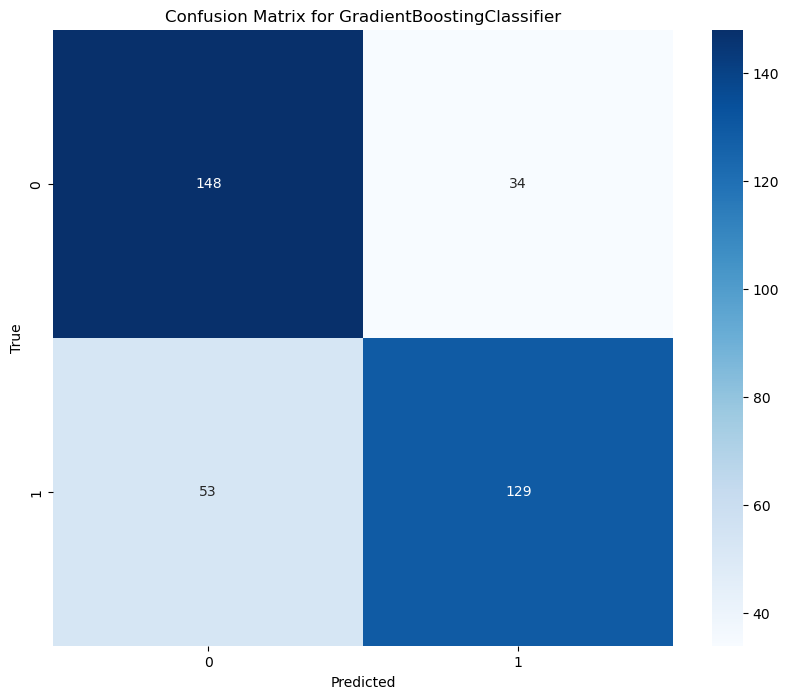


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 69.78%
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       182
           1       0.72      0.65      0.68       182

    accuracy                           0.70       364
   macro avg       0.70      0.70      0.70       364
weighted avg       0.70      0.70      0.70       364



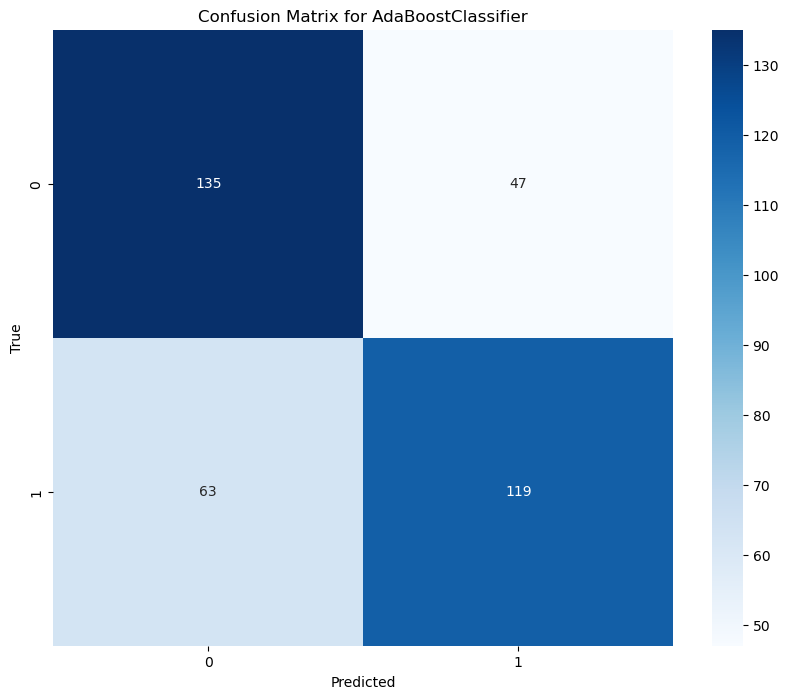


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 72.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.74       182
           1       0.75      0.68      0.71       182

    accuracy                           0.73       364
   macro avg       0.73      0.73      0.72       364
weighted avg       0.73      0.73      0.72       364



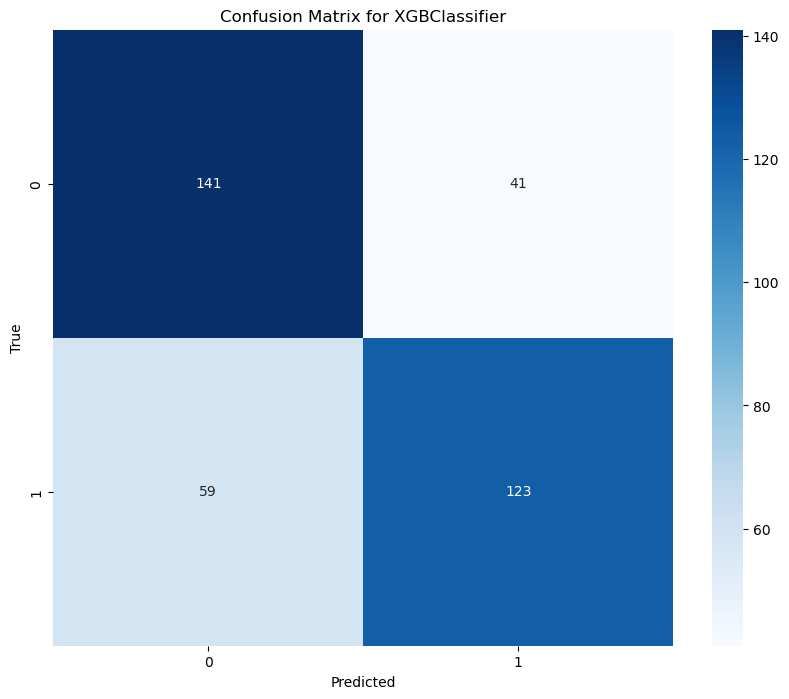


Frequency Domain:

LDA:
Accuracy: 67.58%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       182
           1       0.71      0.60      0.65       182

    accuracy                           0.68       364
   macro avg       0.68      0.68      0.67       364
weighted avg       0.68      0.68      0.67       364



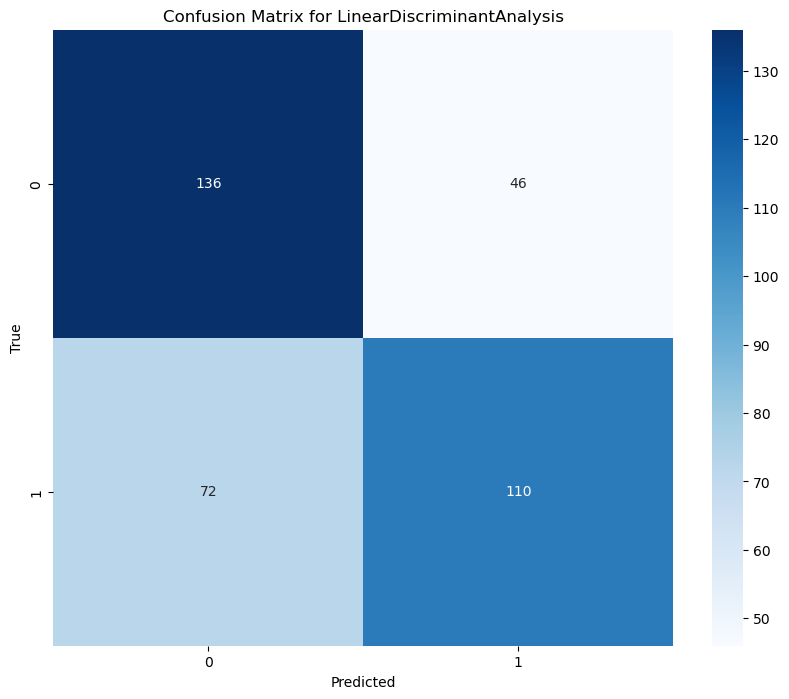


Logistic Regression:
Accuracy: 67.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       182
           1       0.70      0.60      0.65       182

    accuracy                           0.67       364
   macro avg       0.68      0.67      0.67       364
weighted avg       0.68      0.67      0.67       364



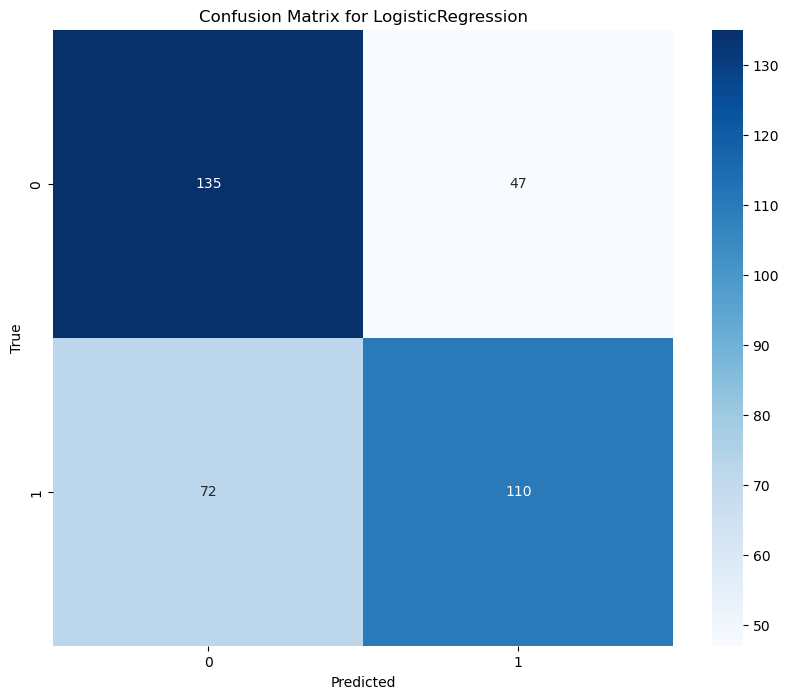


KNN:
Accuracy: 60.44%
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61       182
           1       0.61      0.60      0.60       182

    accuracy                           0.60       364
   macro avg       0.60      0.60      0.60       364
weighted avg       0.60      0.60      0.60       364



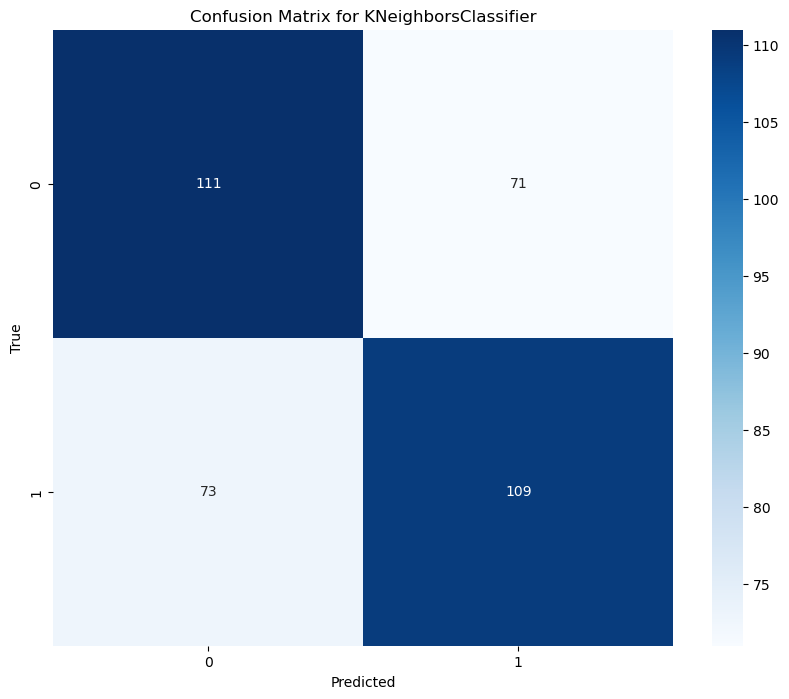


Random Forest:
Accuracy: 81.59%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       182
           1       0.88      0.74      0.80       182

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.81       364
weighted avg       0.82      0.82      0.81       364



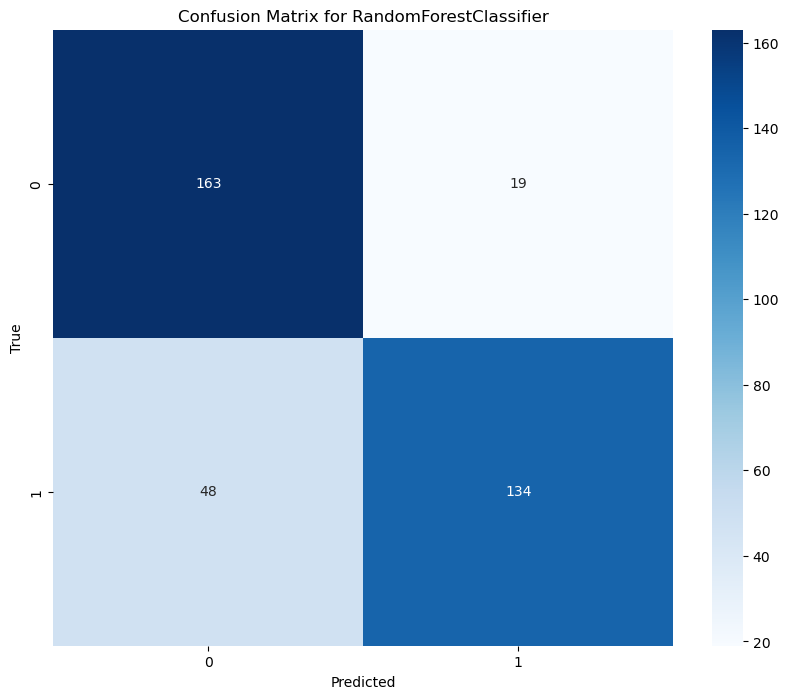


Decision Tree:
Accuracy: 72.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       182
           1       0.72      0.74      0.73       182

    accuracy                           0.73       364
   macro avg       0.73      0.73      0.73       364
weighted avg       0.73      0.73      0.73       364



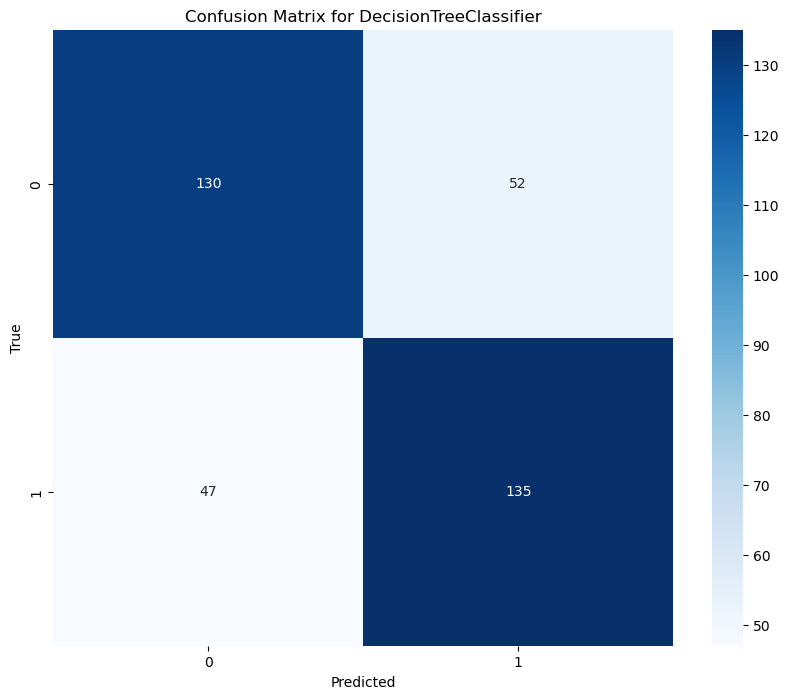


Gradient Boosting:
Accuracy: 82.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       182
           1       0.89      0.75      0.81       182

    accuracy                           0.83       364
   macro avg       0.84      0.83      0.83       364
weighted avg       0.84      0.83      0.83       364



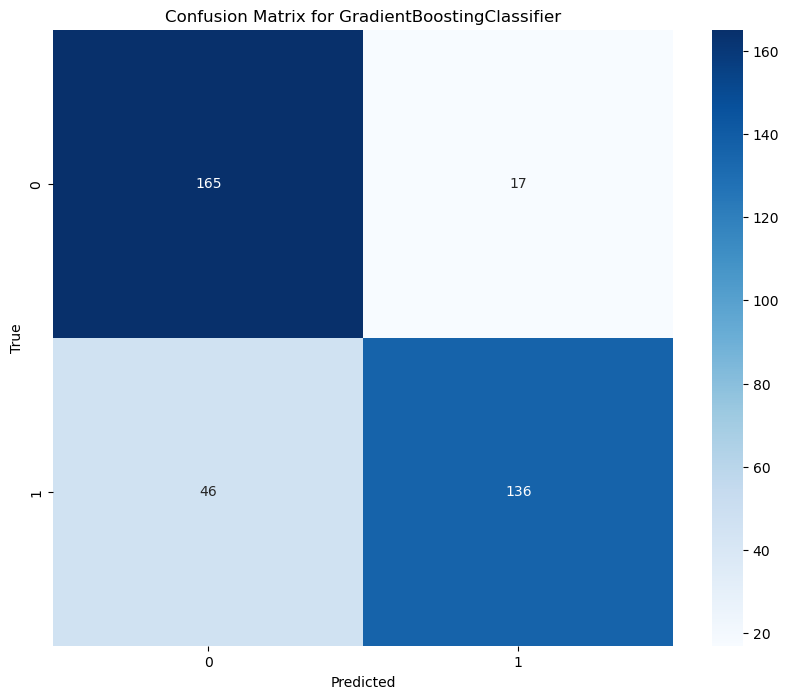


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 77.75%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       182
           1       0.79      0.75      0.77       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



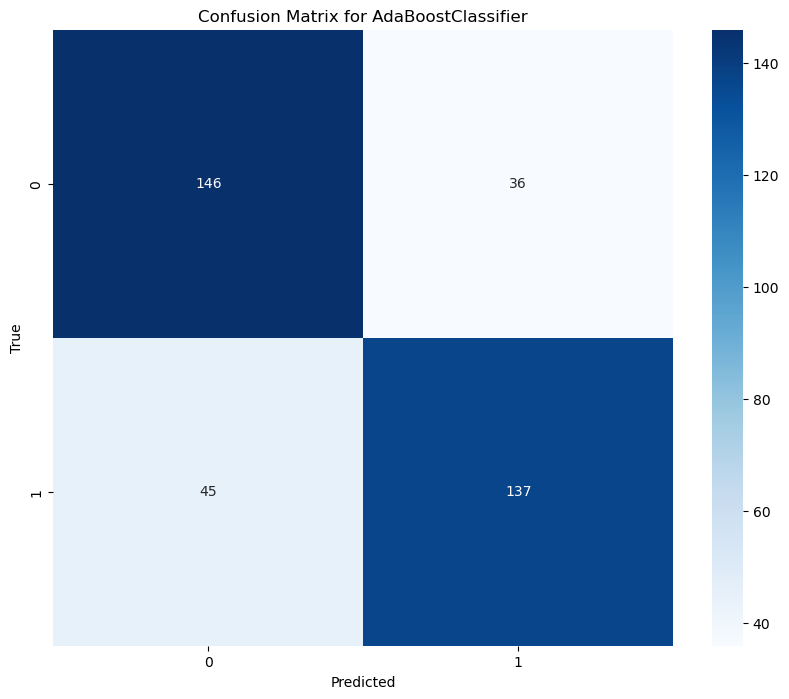


XGBoost:
Accuracy: 79.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       182
           1       0.83      0.74      0.78       182

    accuracy                           0.80       364
   macro avg       0.80      0.80      0.80       364
weighted avg       0.80      0.80      0.80       364



/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


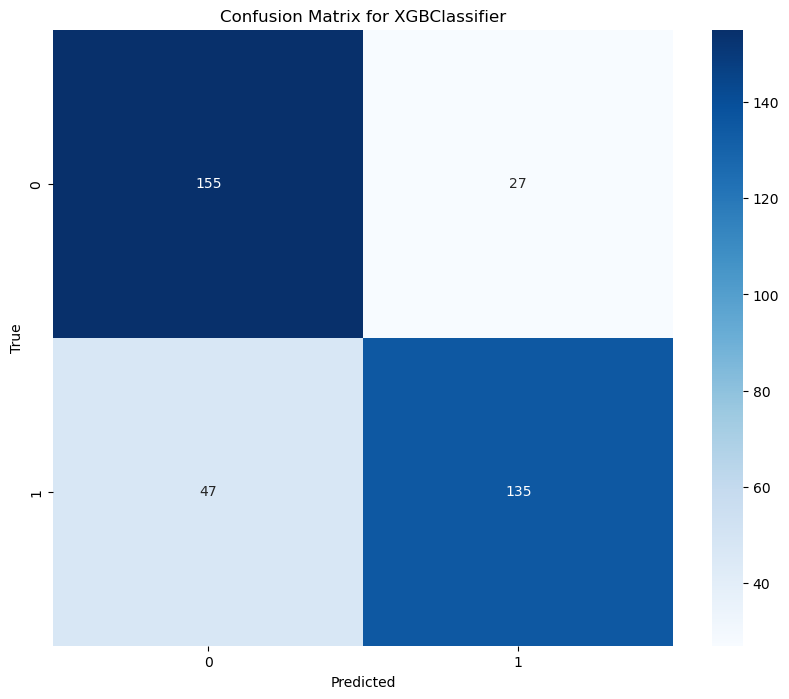



Finger Class: Ring


Time Domain:

LDA:
Accuracy: 72.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       182
           1       0.72      0.74      0.73       182

    accuracy                           0.73       364
   macro avg       0.73      0.73      0.73       364
weighted avg       0.73      0.73      0.73       364



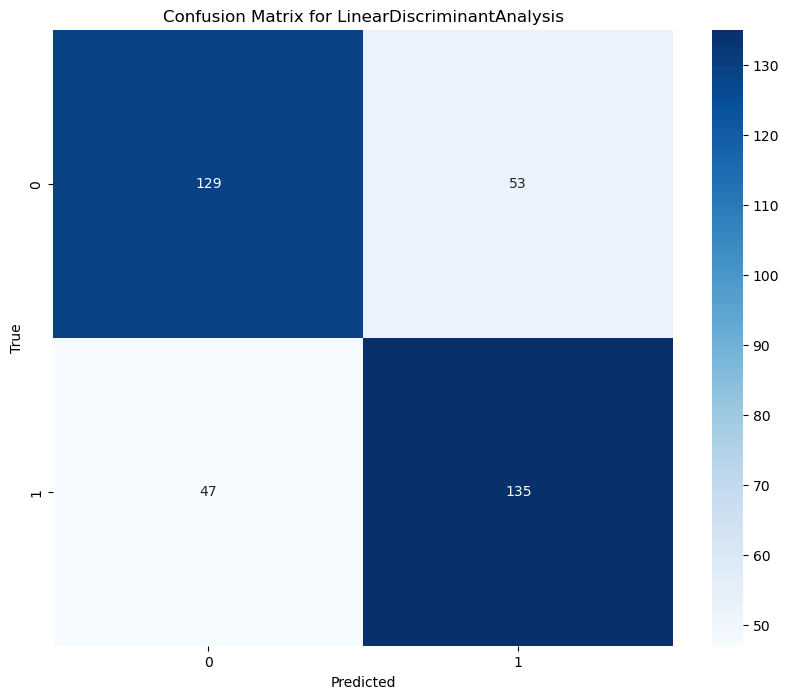


Logistic Regression:


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 71.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       182
           1       0.74      0.68      0.71       182

    accuracy                           0.72       364
   macro avg       0.72      0.72      0.72       364
weighted avg       0.72      0.72      0.72       364



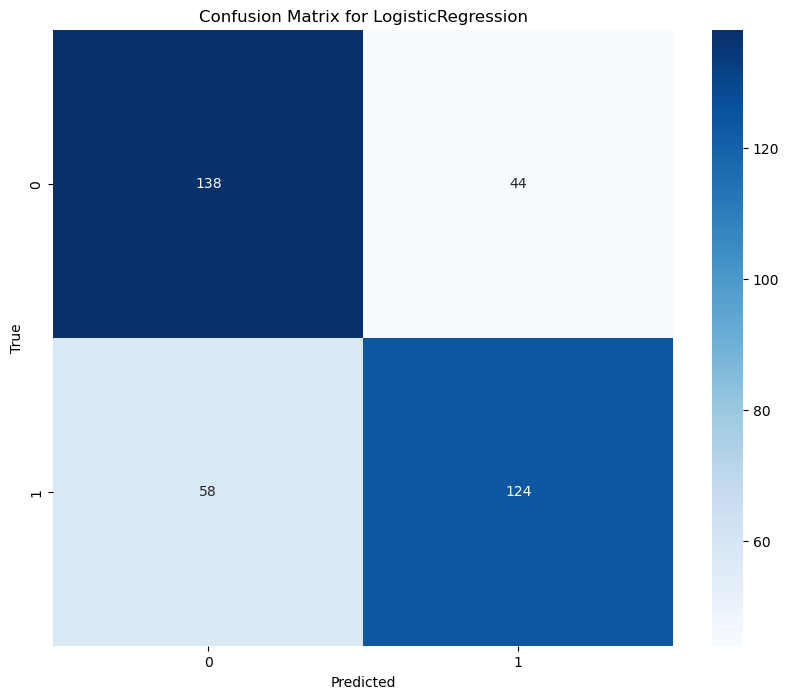


KNN:
Accuracy: 65.66%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68       182
           1       0.68      0.59      0.63       182

    accuracy                           0.66       364
   macro avg       0.66      0.66      0.65       364
weighted avg       0.66      0.66      0.65       364



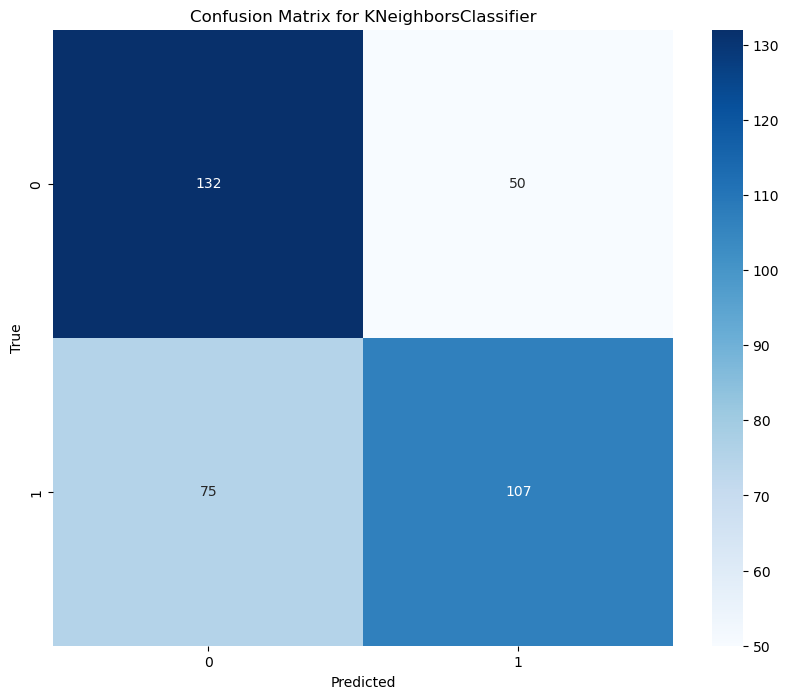


Random Forest:
Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       182
           1       0.79      0.68      0.73       182

    accuracy                           0.75       364
   macro avg       0.76      0.75      0.75       364
weighted avg       0.76      0.75      0.75       364



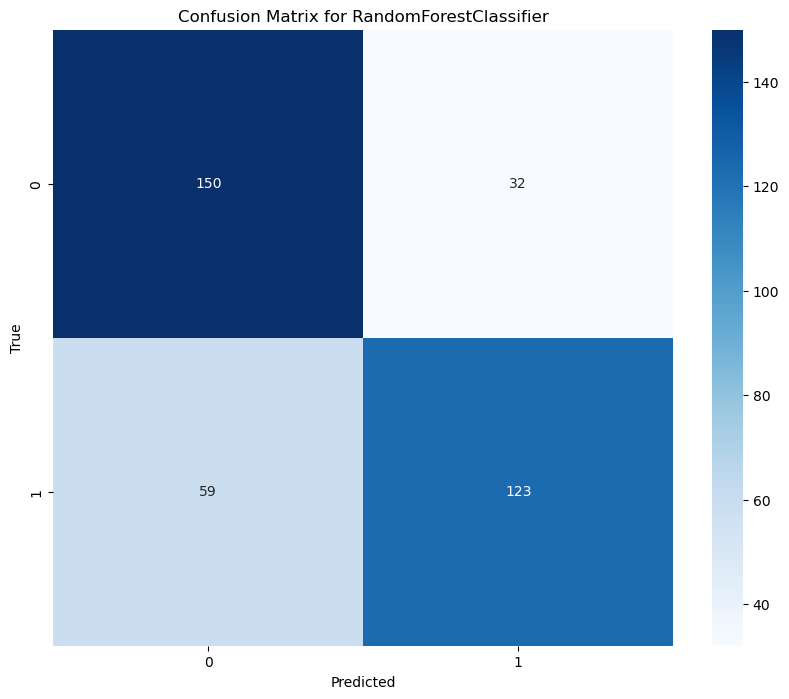


Decision Tree:
Accuracy: 64.84%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       182
           1       0.64      0.66      0.65       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



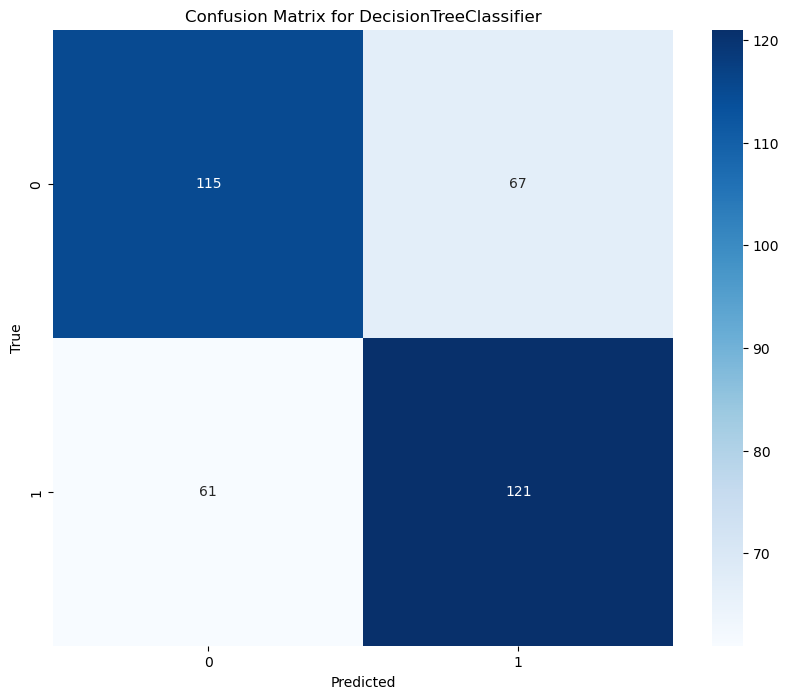


Gradient Boosting:
Accuracy: 72.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       182
           1       0.75      0.68      0.71       182

    accuracy                           0.73       364
   macro avg       0.73      0.73      0.72       364
weighted avg       0.73      0.73      0.72       364



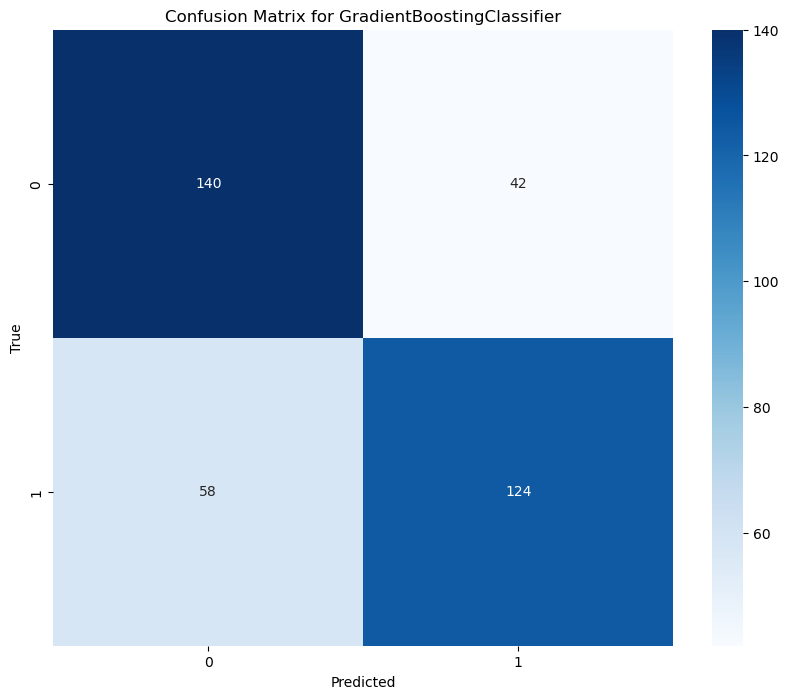


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 70.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       182
           1       0.71      0.68      0.70       182

    accuracy                           0.70       364
   macro avg       0.70      0.70      0.70       364
weighted avg       0.70      0.70      0.70       364



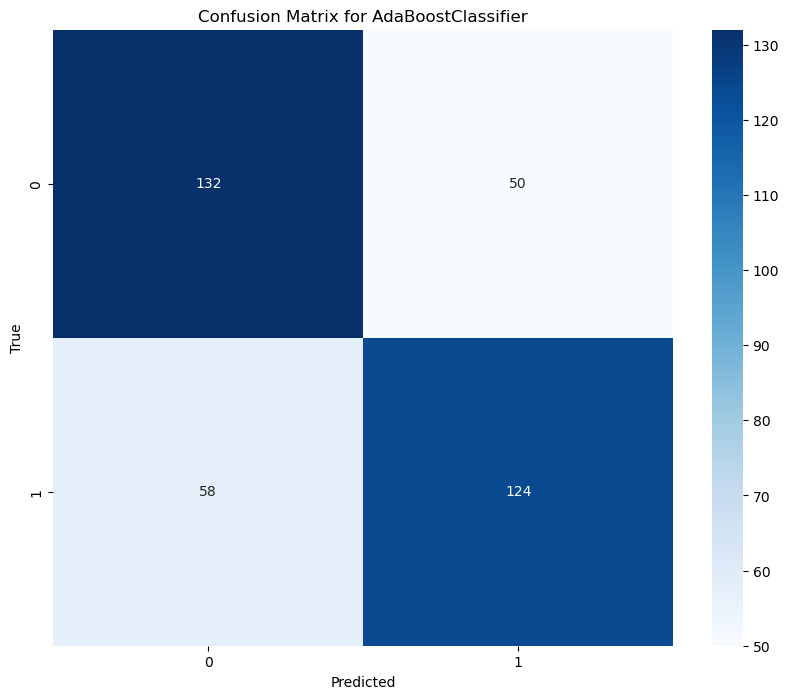


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 76.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       182
           1       0.78      0.75      0.77       182

    accuracy                           0.77       364
   macro avg       0.77      0.77      0.77       364
weighted avg       0.77      0.77      0.77       364



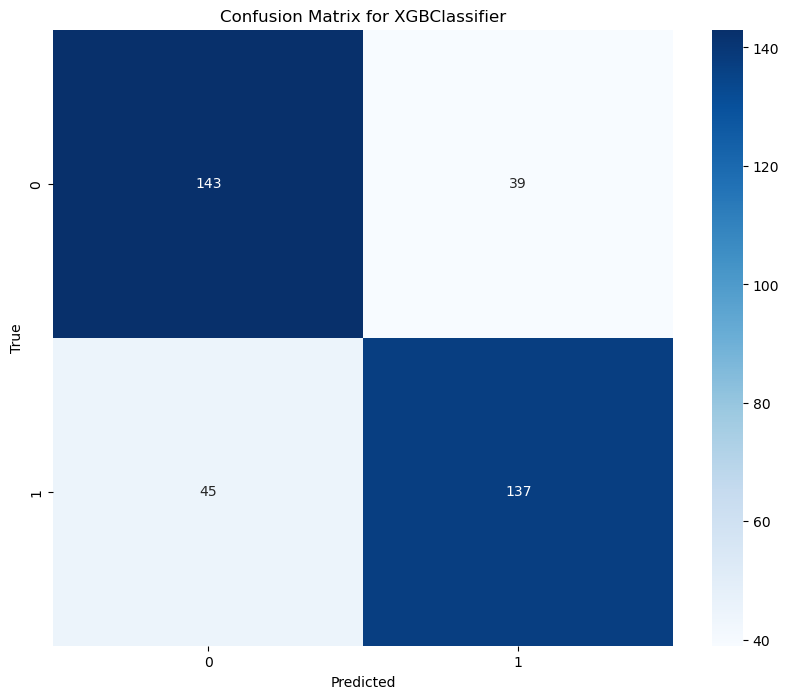


Frequency Domain:

LDA:
Accuracy: 64.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       182
           1       0.65      0.63      0.64       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



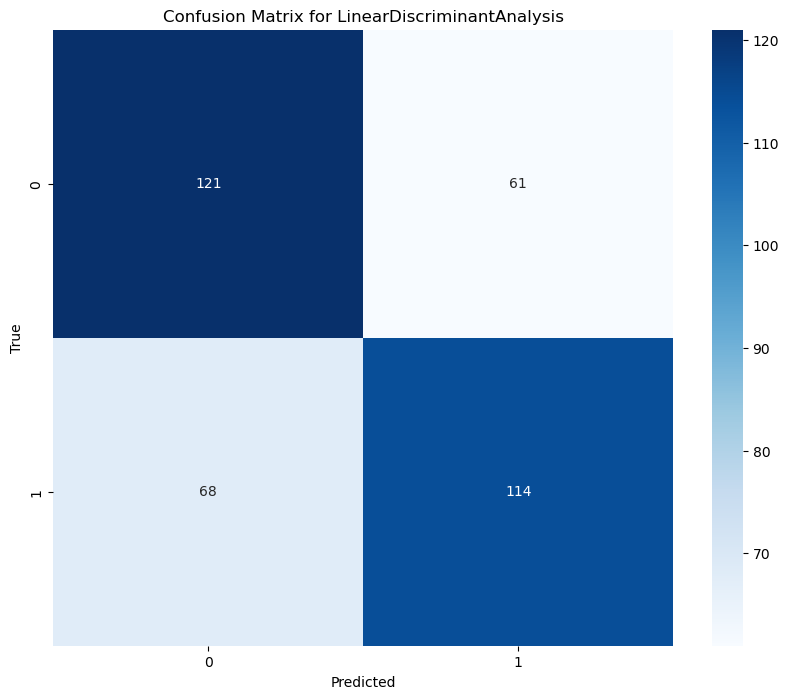


Logistic Regression:
Accuracy: 63.74%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       182
           1       0.64      0.63      0.64       182

    accuracy                           0.64       364
   macro avg       0.64      0.64      0.64       364
weighted avg       0.64      0.64      0.64       364



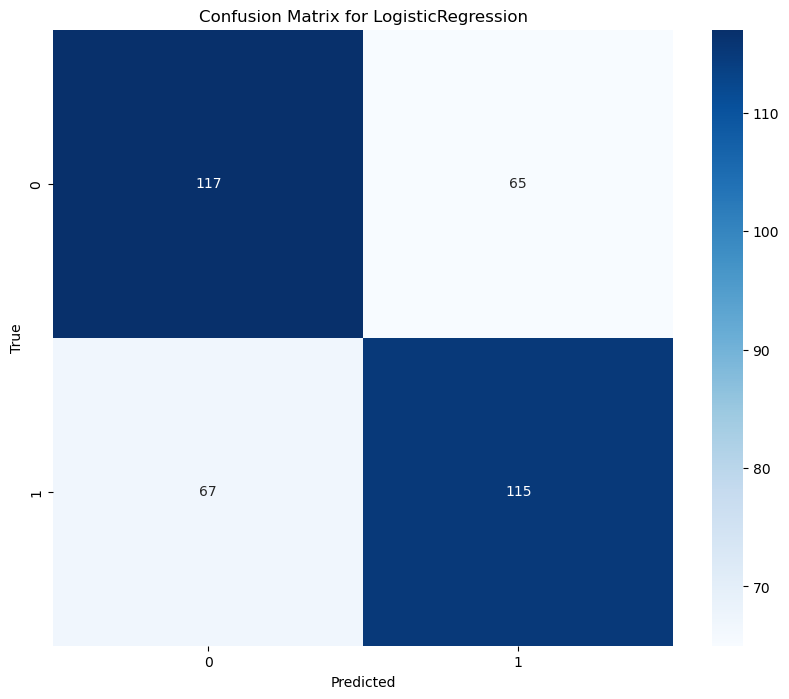


KNN:
Accuracy: 58.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       182
           1       0.58      0.60      0.59       182

    accuracy                           0.58       364
   macro avg       0.58      0.58      0.58       364
weighted avg       0.58      0.58      0.58       364



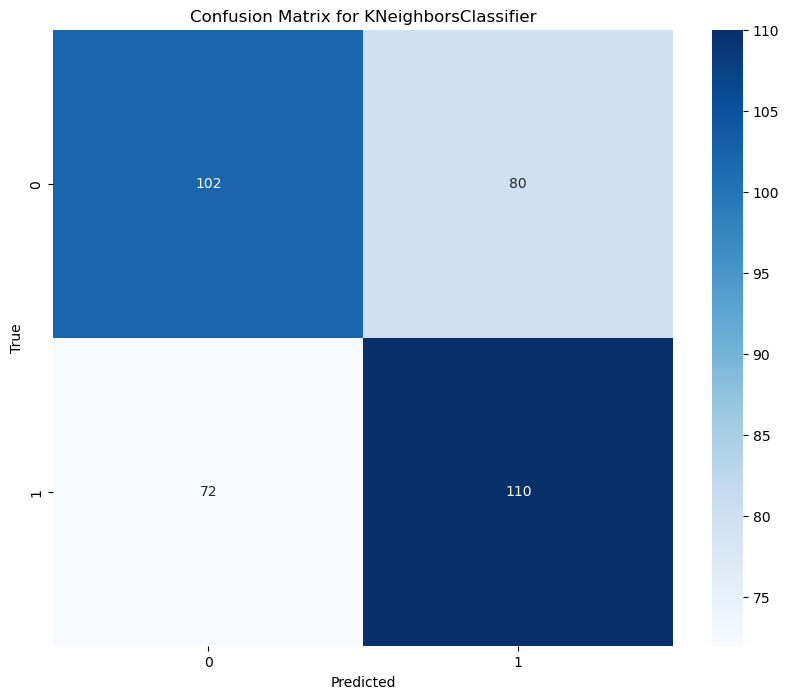


Random Forest:
Accuracy: 79.95%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       182
           1       0.87      0.71      0.78       182

    accuracy                           0.80       364
   macro avg       0.81      0.80      0.80       364
weighted avg       0.81      0.80      0.80       364



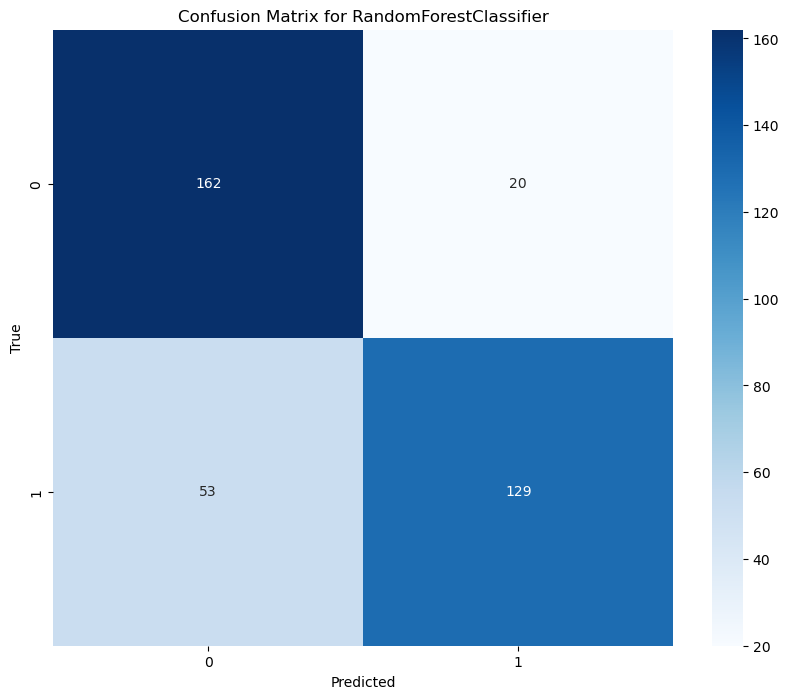


Decision Tree:
Accuracy: 70.05%
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       182
           1       0.71      0.68      0.69       182

    accuracy                           0.70       364
   macro avg       0.70      0.70      0.70       364
weighted avg       0.70      0.70      0.70       364



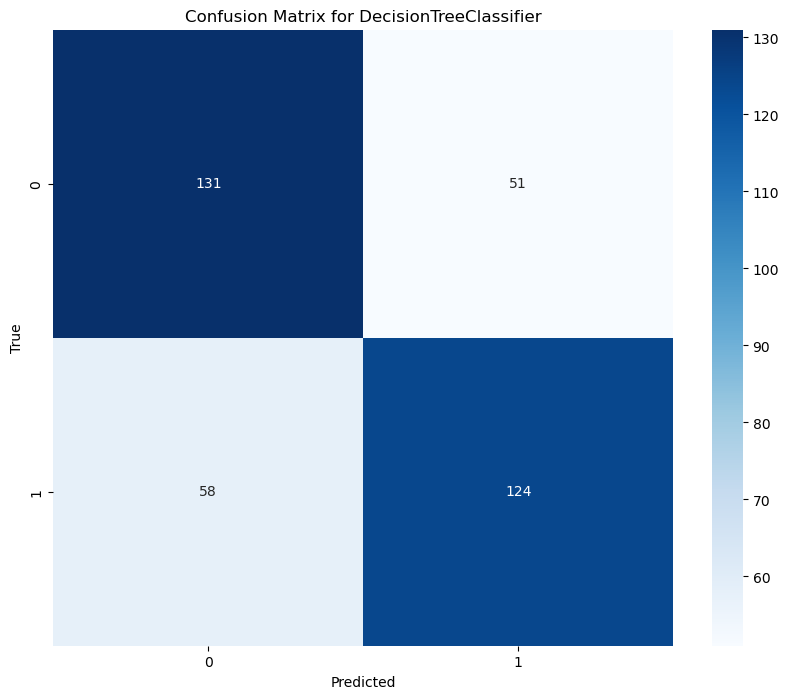


Gradient Boosting:
Accuracy: 78.02%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.85      0.79       182
           1       0.82      0.71      0.76       182

    accuracy                           0.78       364
   macro avg       0.79      0.78      0.78       364
weighted avg       0.79      0.78      0.78       364



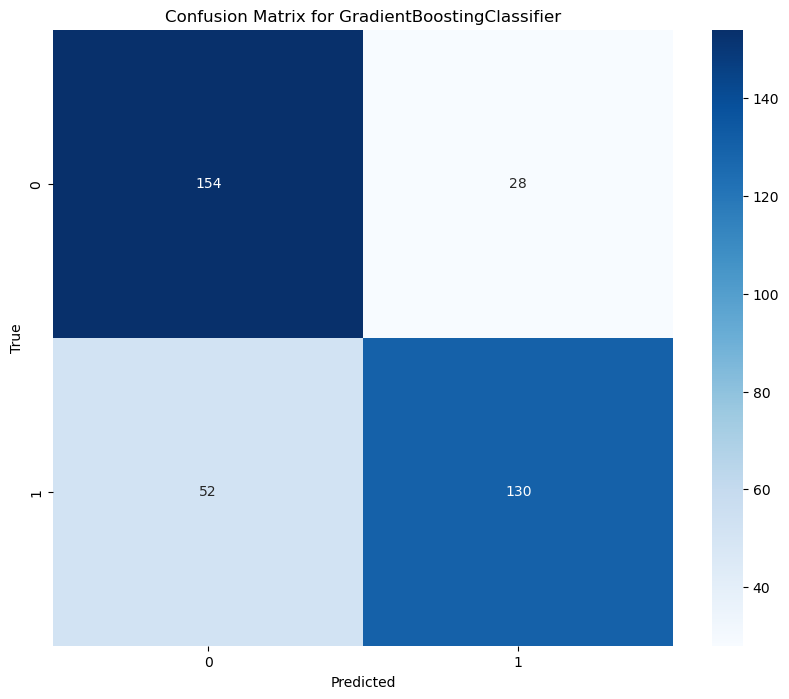


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 74.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       182
           1       0.76      0.71      0.73       182

    accuracy                           0.74       364
   macro avg       0.74      0.74      0.74       364
weighted avg       0.74      0.74      0.74       364



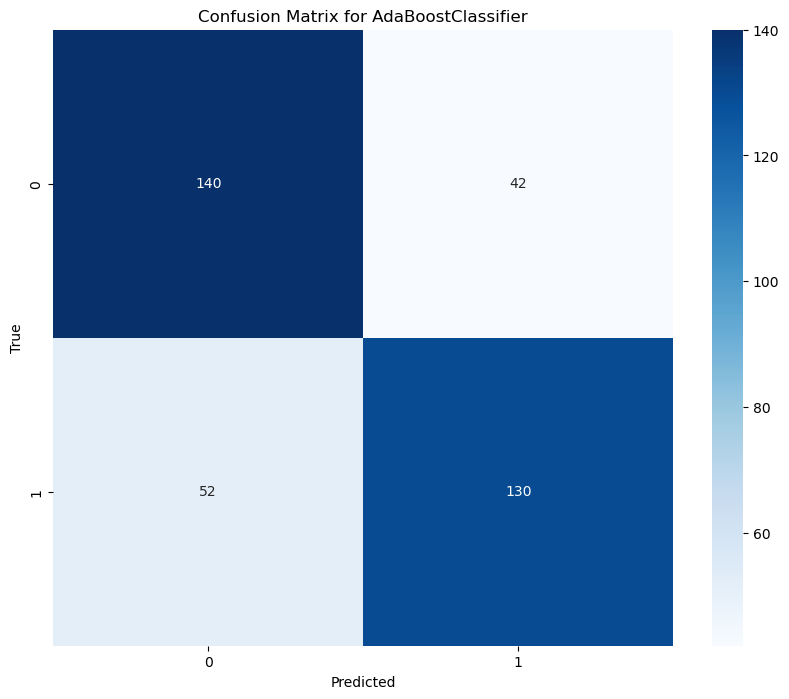


XGBoost:
Accuracy: 76.37%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       182
           1       0.79      0.71      0.75       182

    accuracy                           0.76       364
   macro avg       0.77      0.76      0.76       364
weighted avg       0.77      0.76      0.76       364



/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


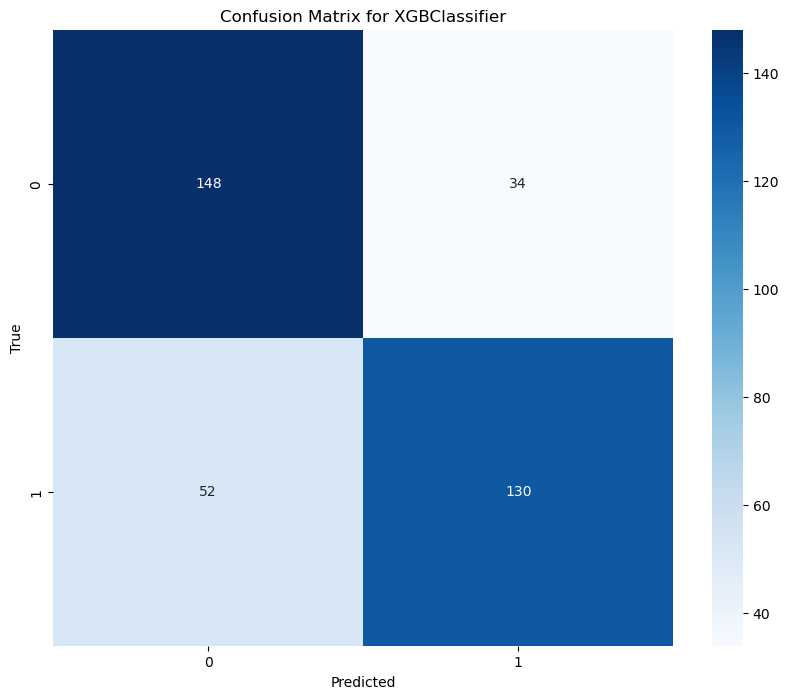



Finger Class: Pinky


Time Domain:

LDA:
Accuracy: 78.30%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       182
           1       0.80      0.75      0.78       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



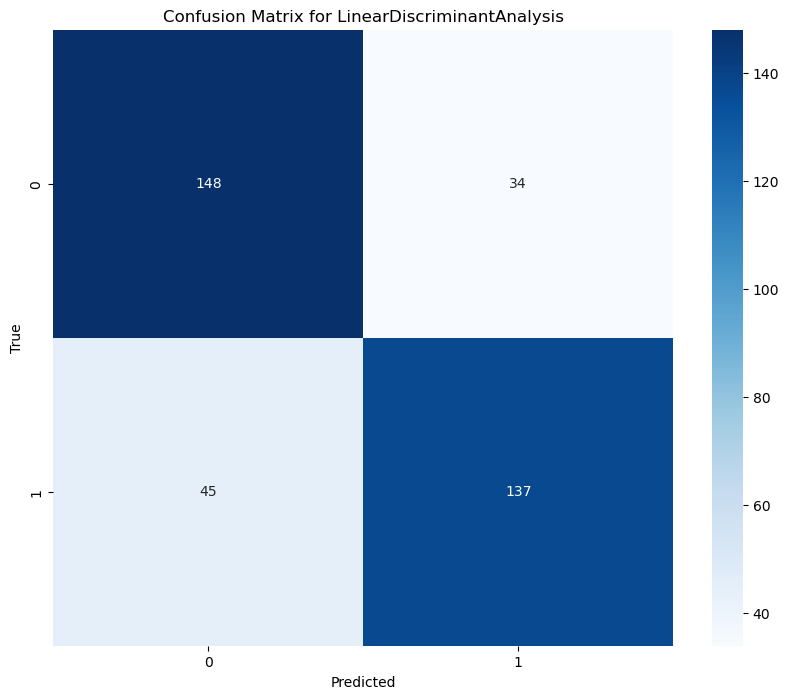


Logistic Regression:


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       182
           1       0.77      0.71      0.74       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



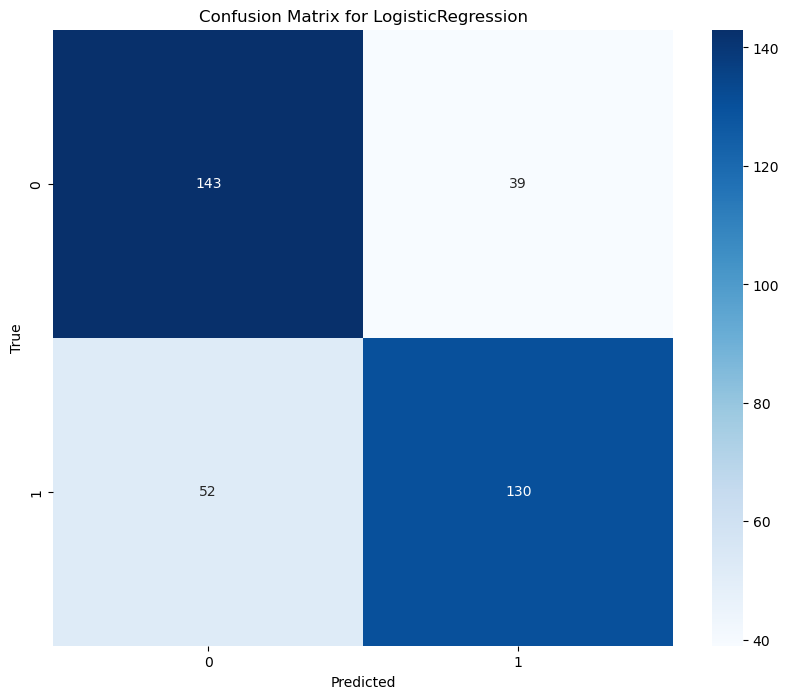


KNN:
Accuracy: 64.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       182
           1       0.65      0.63      0.64       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



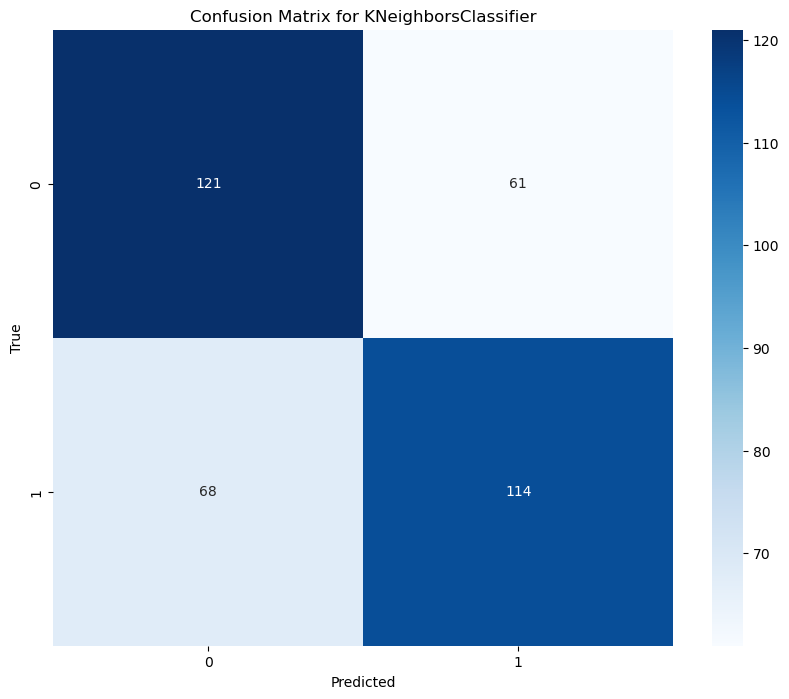


Random Forest:
Accuracy: 74.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       182
           1       0.77      0.69      0.73       182

    accuracy                           0.74       364
   macro avg       0.74      0.74      0.74       364
weighted avg       0.74      0.74      0.74       364



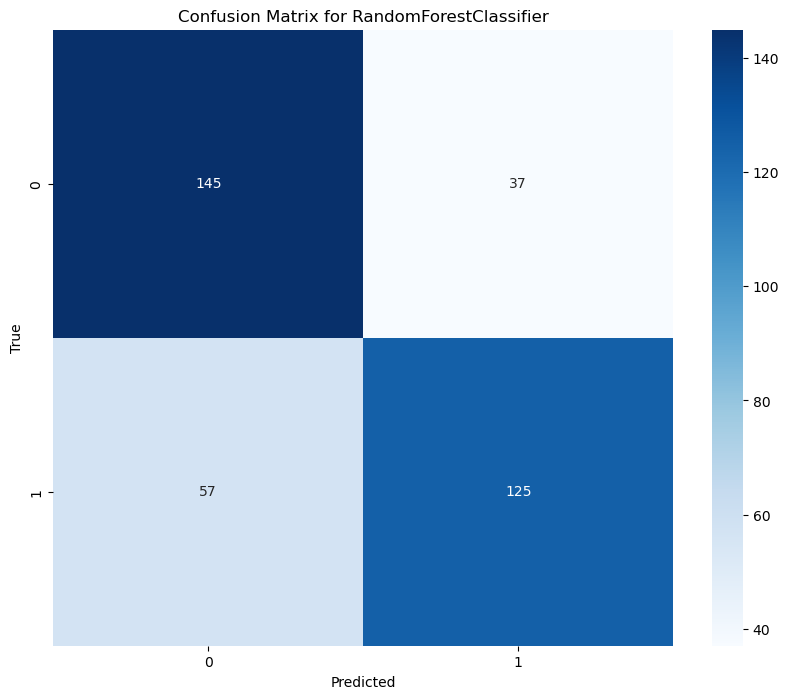


Decision Tree:
Accuracy: 65.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       182
           1       0.65      0.65      0.65       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



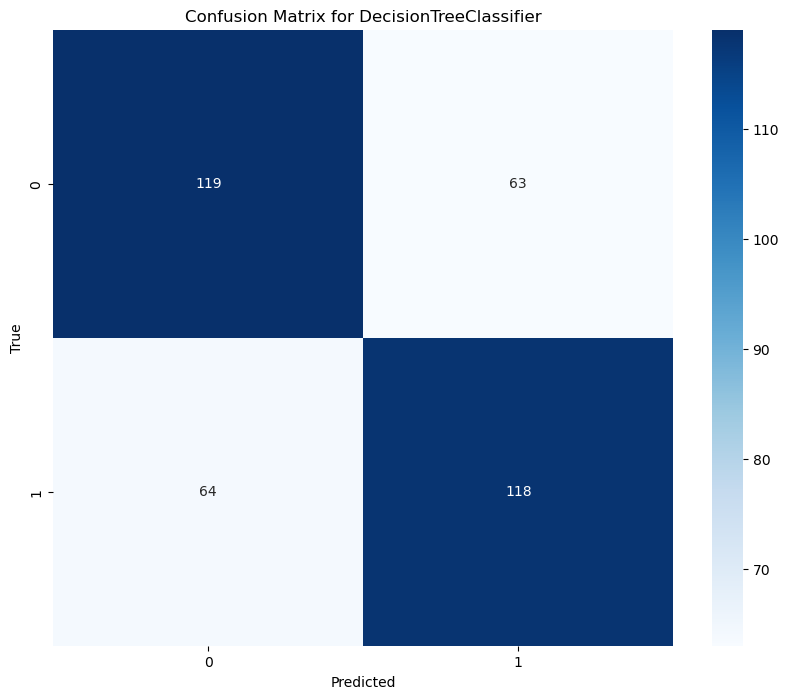


Gradient Boosting:
Accuracy: 76.65%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       182
           1       0.77      0.76      0.76       182

    accuracy                           0.77       364
   macro avg       0.77      0.77      0.77       364
weighted avg       0.77      0.77      0.77       364



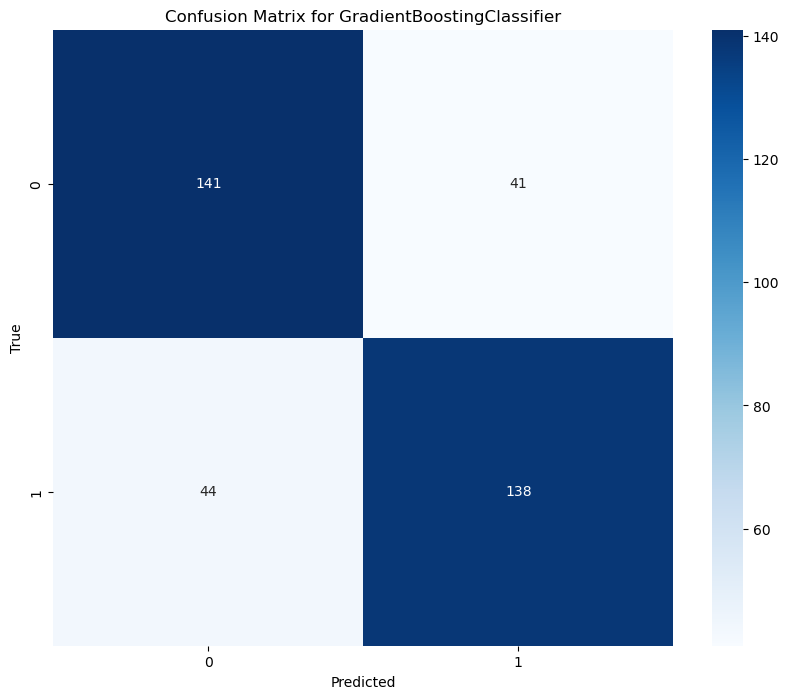


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 71.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       182
           1       0.71      0.74      0.72       182

    accuracy                           0.72       364
   macro avg       0.72      0.72      0.72       364
weighted avg       0.72      0.72      0.72       364



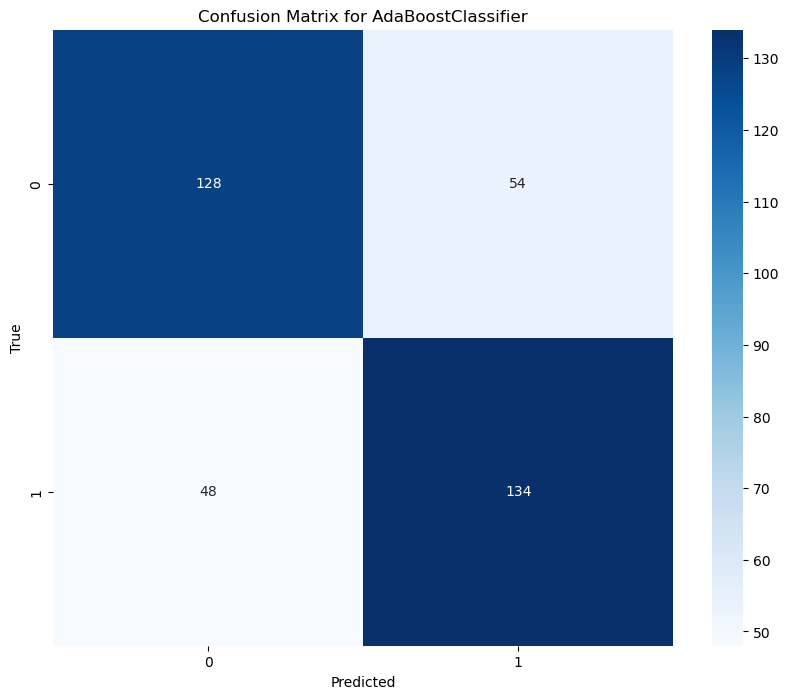


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 75.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       182
           1       0.79      0.71      0.75       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364



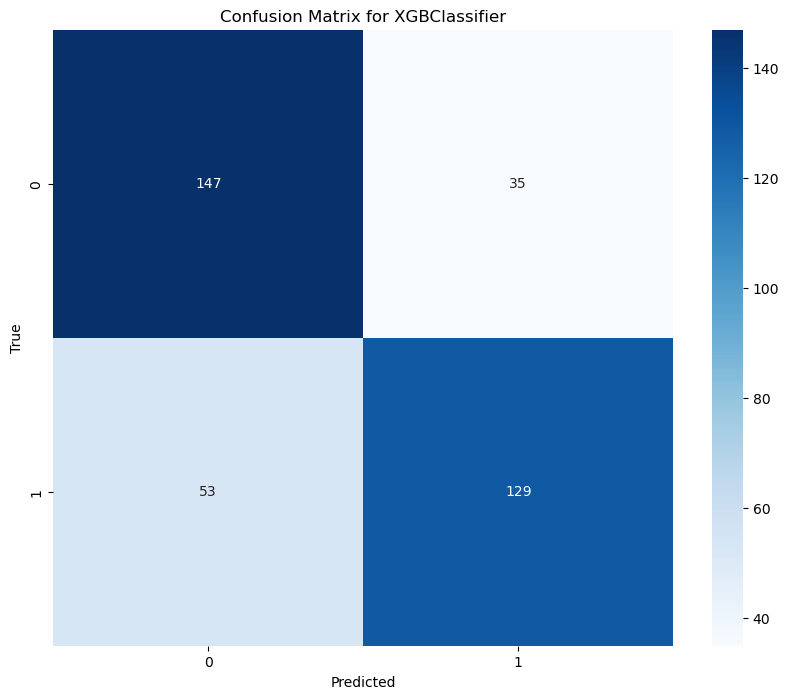


Frequency Domain:

LDA:
Accuracy: 65.93%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67       182
           1       0.67      0.64      0.65       182

    accuracy                           0.66       364
   macro avg       0.66      0.66      0.66       364
weighted avg       0.66      0.66      0.66       364



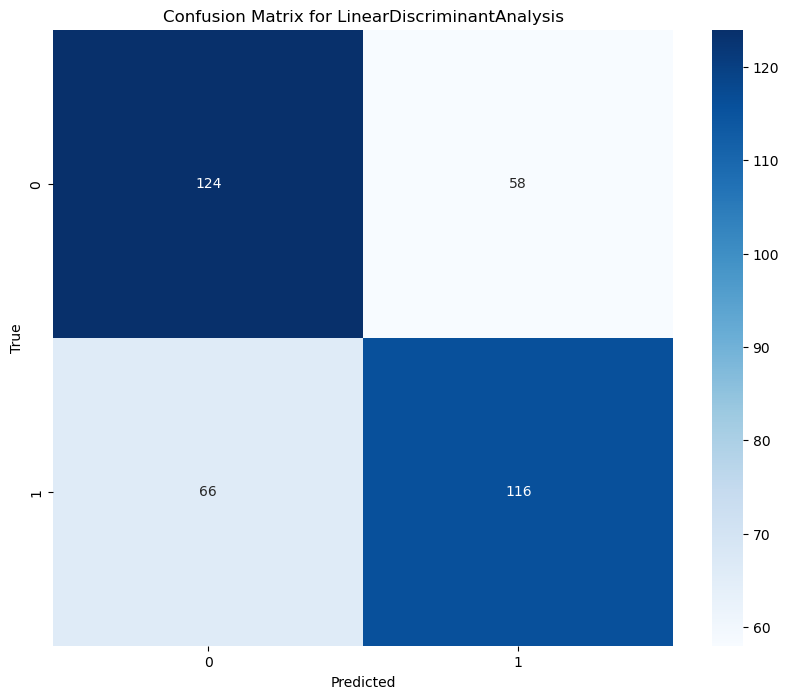


Logistic Regression:
Accuracy: 64.84%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       182
           1       0.66      0.62      0.64       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



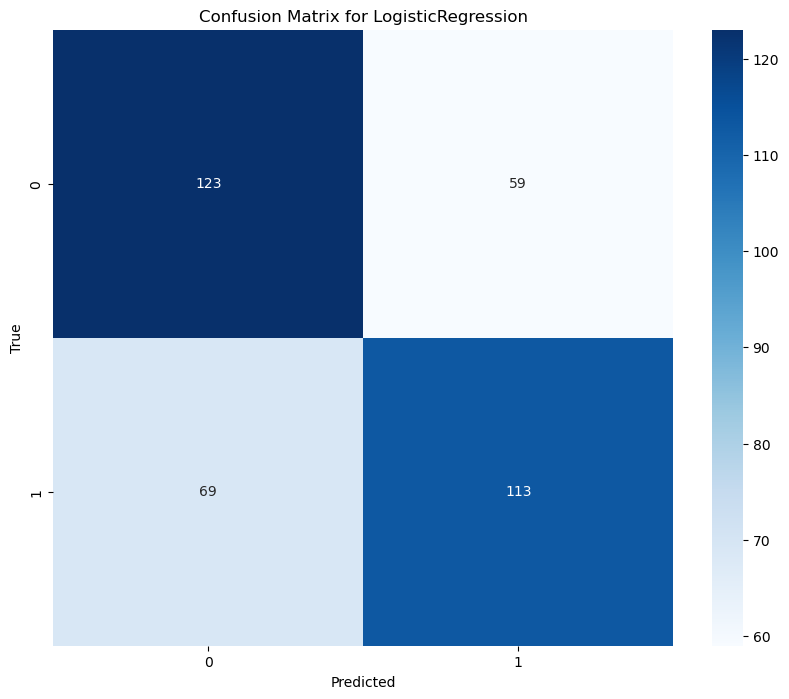


KNN:
Accuracy: 59.89%
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       182
           1       0.60      0.58      0.59       182

    accuracy                           0.60       364
   macro avg       0.60      0.60      0.60       364
weighted avg       0.60      0.60      0.60       364



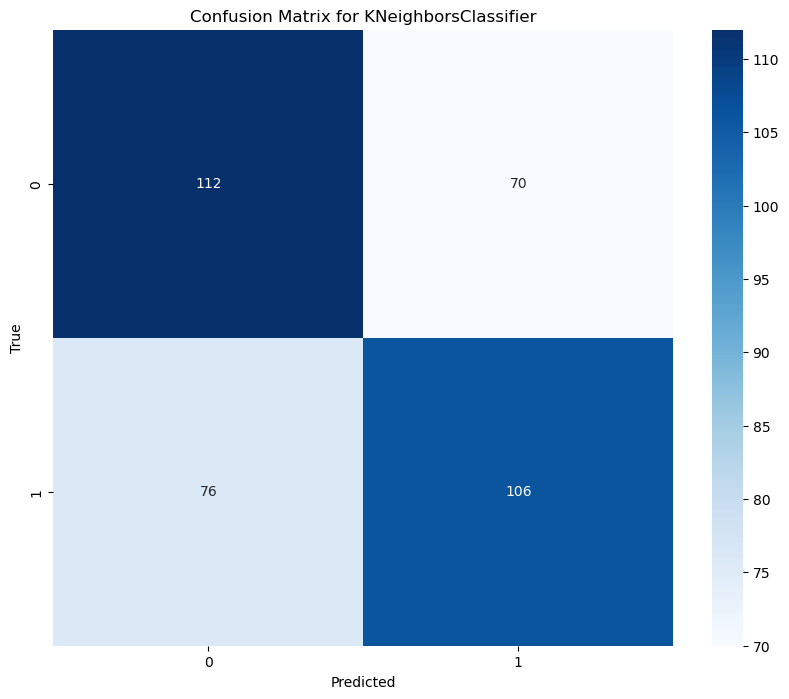


Random Forest:
Accuracy: 81.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       182
           1       0.86      0.75      0.80       182

    accuracy                           0.81       364
   macro avg       0.82      0.81      0.81       364
weighted avg       0.82      0.81      0.81       364



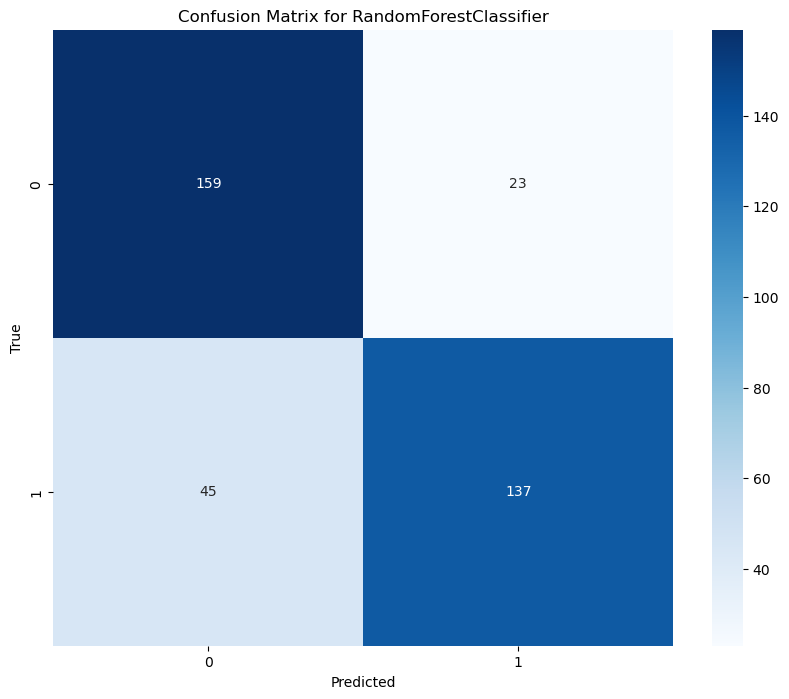


Decision Tree:
Accuracy: 73.90%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       182
           1       0.74      0.75      0.74       182

    accuracy                           0.74       364
   macro avg       0.74      0.74      0.74       364
weighted avg       0.74      0.74      0.74       364



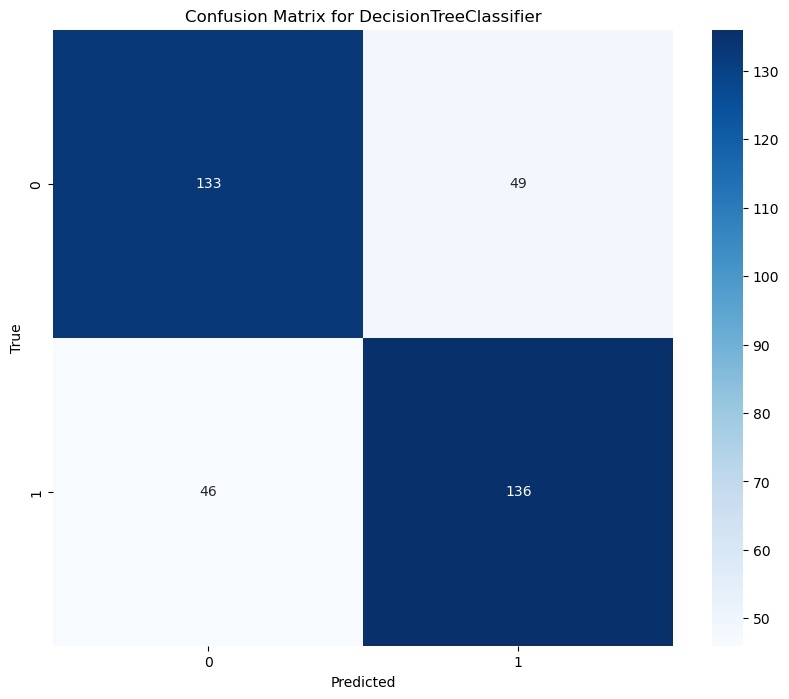


Gradient Boosting:
Accuracy: 80.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       182
           1       0.84      0.74      0.79       182

    accuracy                           0.80       364
   macro avg       0.81      0.80      0.80       364
weighted avg       0.81      0.80      0.80       364



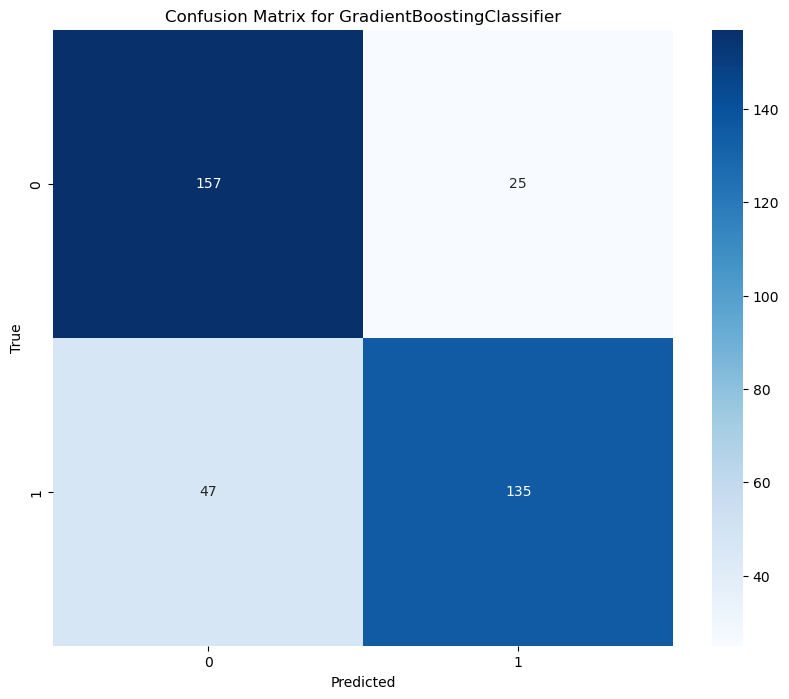


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 76.37%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       182
           1       0.76      0.77      0.77       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364



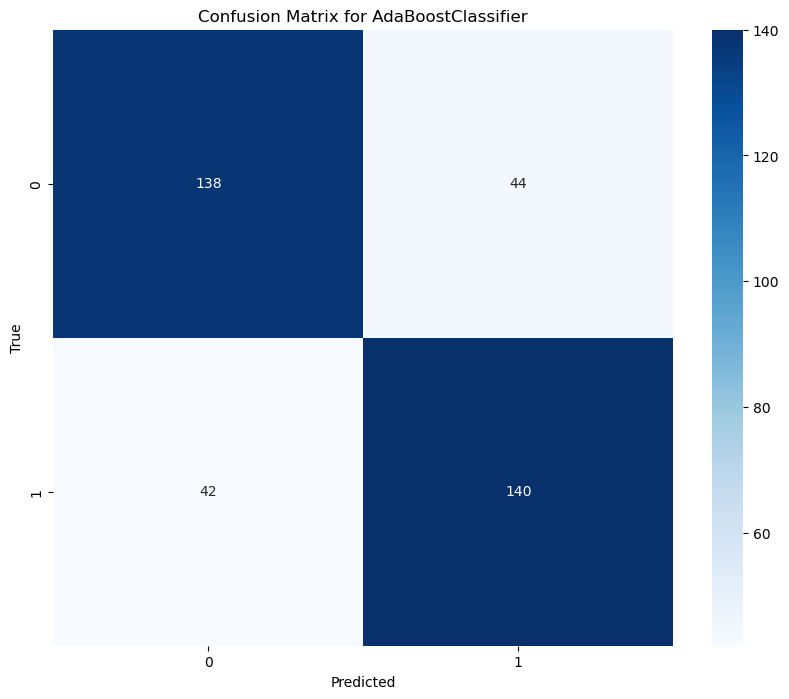


XGBoost:
Accuracy: 78.85%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       182
           1       0.82      0.74      0.78       182

    accuracy                           0.79       364
   macro avg       0.79      0.79      0.79       364
weighted avg       0.79      0.79      0.79       364



/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


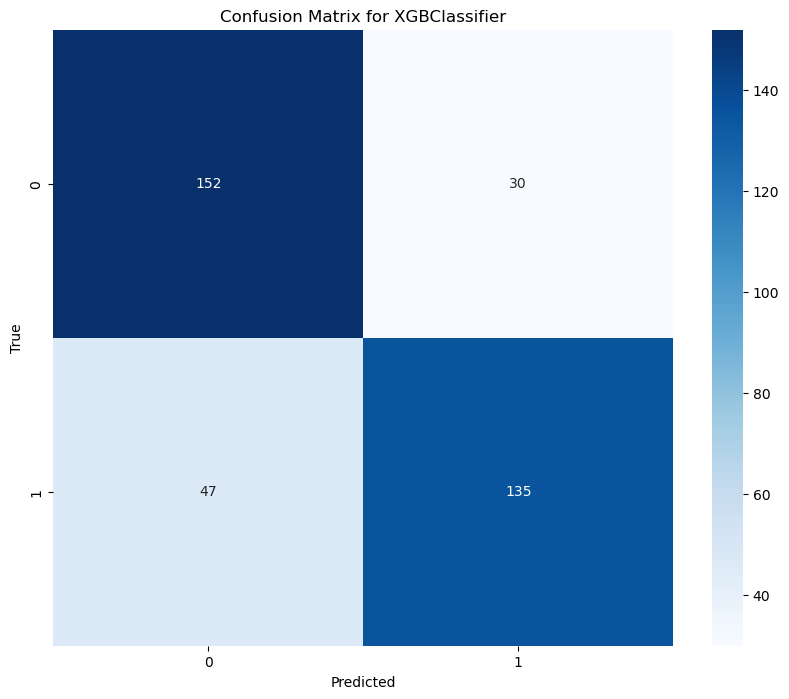

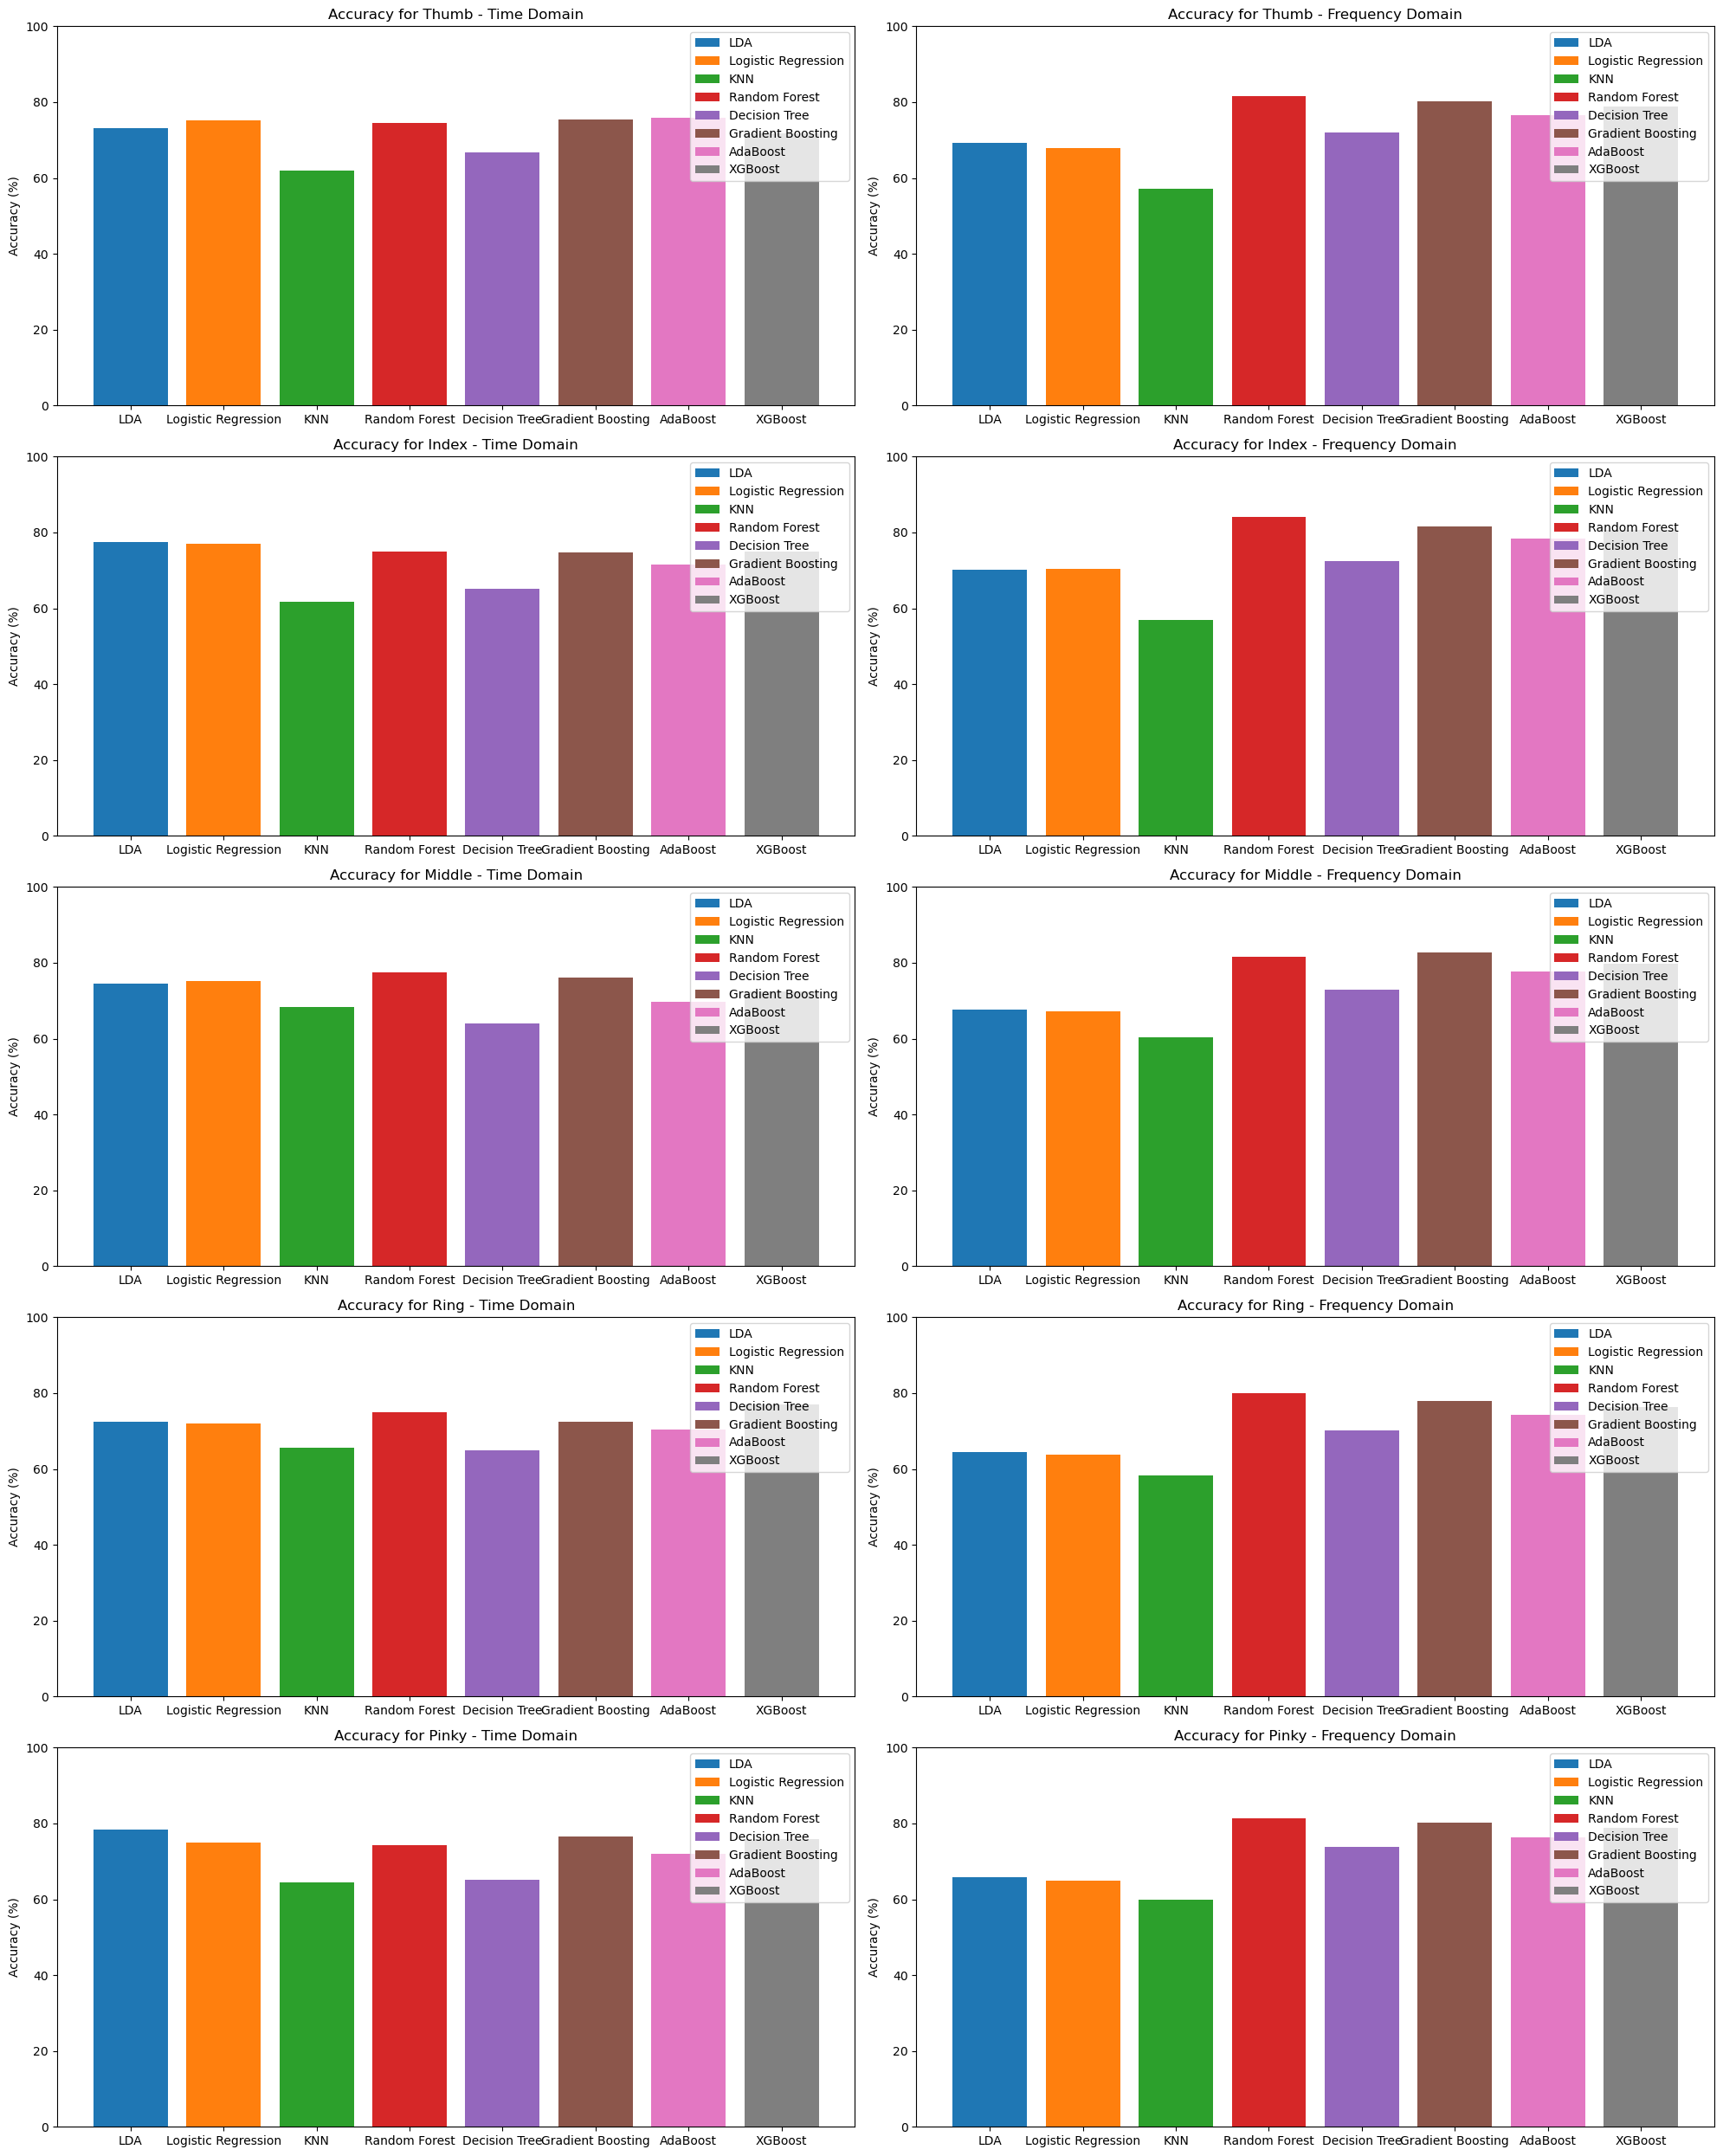

In [ ]:
# Evaluate each classifier for each finger class in both time and frequency domains
for finger, data in finger_data.items():
    print(f"\n\nFinger Class: {finger}\n")

    for domain, (X_train_features, X_test_features, y_train_finger, y_test_finger) in data.items():
        print(f"\n{domain}:")

        for name, clf in classifiers.items():
            print(f"\n{name}:")
            accuracy, report, conf_matrix = evaluate_model(clf, X_train_features, X_test_features, y_train_finger, y_test_finger)
            results[finger][domain][name]['accuracy'] = accuracy
            results[finger][domain][name]['report'] = report
            results[finger][domain][name]['conf_matrix'] = conf_matrix

# Plot accuracy of each finger class in both time and frequency domains using bar plots
plt.figure(figsize=(20, 25))

# List of fingers for plotting
fingers = list(finger_data.keys())
domains = list(next(iter(finger_data.values())).keys())

for i, finger in enumerate(fingers, 1):
    for j, domain in enumerate(domains, 1):
        plt.subplot(len(fingers), len(domains), (i-1) * len(domains) + j)
        plt.title(f'Accuracy for {finger} - {domain}')
        plt.ylim(0, 100)
        plt.ylabel('Accuracy (%)')

        for name, result in results[finger][domain].items():
            plt.bar(name, result['accuracy'], label=name)

        plt.legend()

plt.tight_layout()
plt.show()


##**6.2  Both Time  and freqyany features**

In [ ]:
# Function to evaluate and print results
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}%")
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.show()

    return accuracy, report, conf_matrix

In [ ]:
# Dictionary mapping each finger class to its respective data and features
finger_data = {
    "Thumb": (X_train_thumb_features_time, X_train_thumb_features_freq, X_test_thumb_features_time, X_test_thumb_features_freq, Y_train_thumb, Y_test_thumb),
    "Index": (X_train_index_features_time, X_train_index_features_freq, X_test_index_features_time, X_test_index_features_freq, Y_train_index, Y_test_index),
    "Middle": (X_train_middle_features_time, X_train_middle_features_freq, X_test_middle_features_time, X_test_middle_features_freq, Y_train_middle, Y_test_middle),
    "Ring": (X_train_ring_features_time, X_train_ring_features_freq, X_test_ring_features_time, X_test_ring_features_freq, Y_train_ring, Y_test_ring),
    "Pinky": (X_train_pinky_features_time, X_train_pinky_features_freq, X_test_pinky_features_time, X_test_pinky_features_freq, Y_train_pinky, Y_test_pinky)
}

results = {finger: {name: {'accuracy': 0, 'report': '', 'conf_matrix': np.zeros((3, 3), dtype=int)} for name in classifiers} for finger in finger_data}



Finger Class: Thumb


LDA:
Accuracy: 75.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       181
           1       0.77      0.74      0.75       181

    accuracy                           0.76       362
   macro avg       0.76      0.76      0.76       362
weighted avg       0.76      0.76      0.76       362



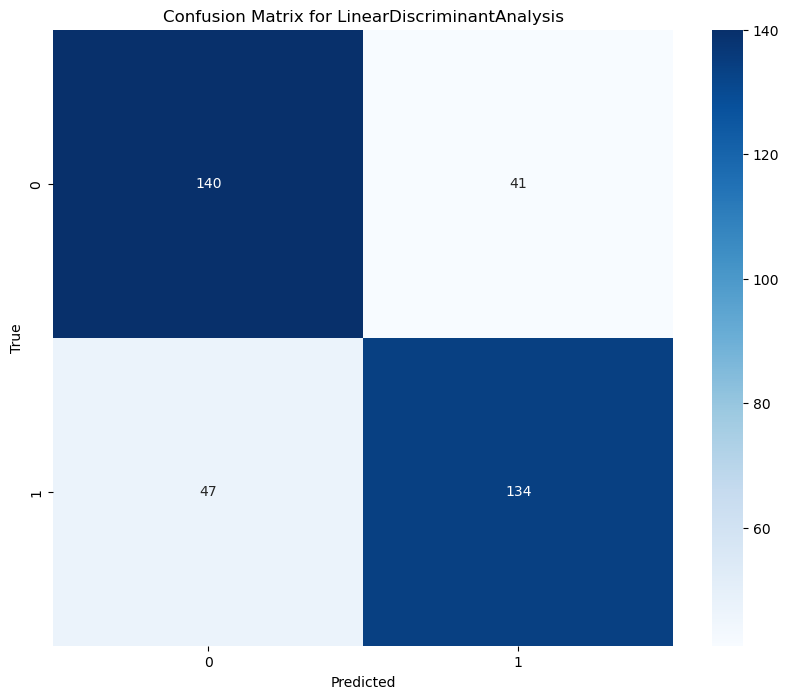


Logistic Regression:
Accuracy: 75.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       181
           1       0.76      0.73      0.75       181

    accuracy                           0.75       362
   macro avg       0.75      0.75      0.75       362
weighted avg       0.75      0.75      0.75       362



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


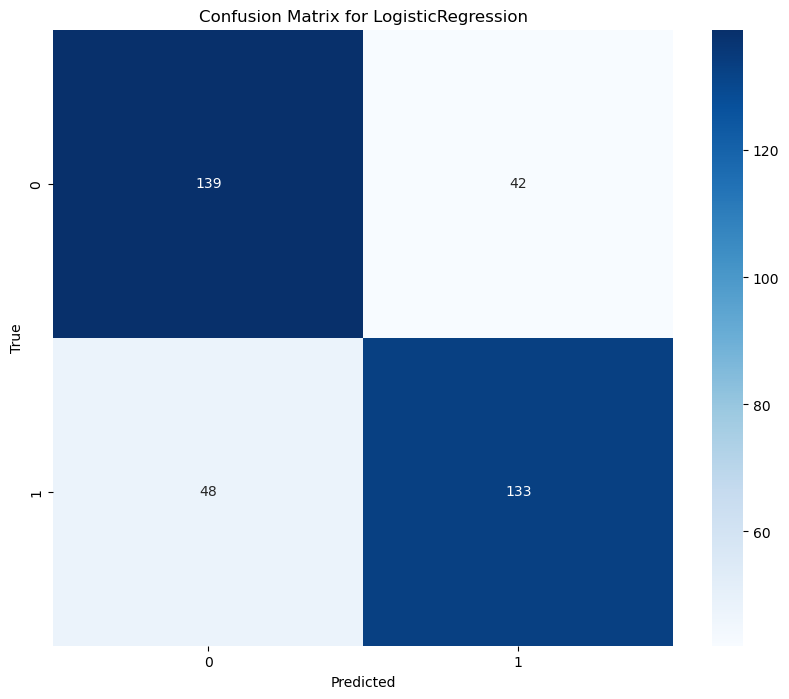


KNN:
Accuracy: 64.36%
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       181
           1       0.63      0.69      0.66       181

    accuracy                           0.64       362
   macro avg       0.64      0.64      0.64       362
weighted avg       0.64      0.64      0.64       362



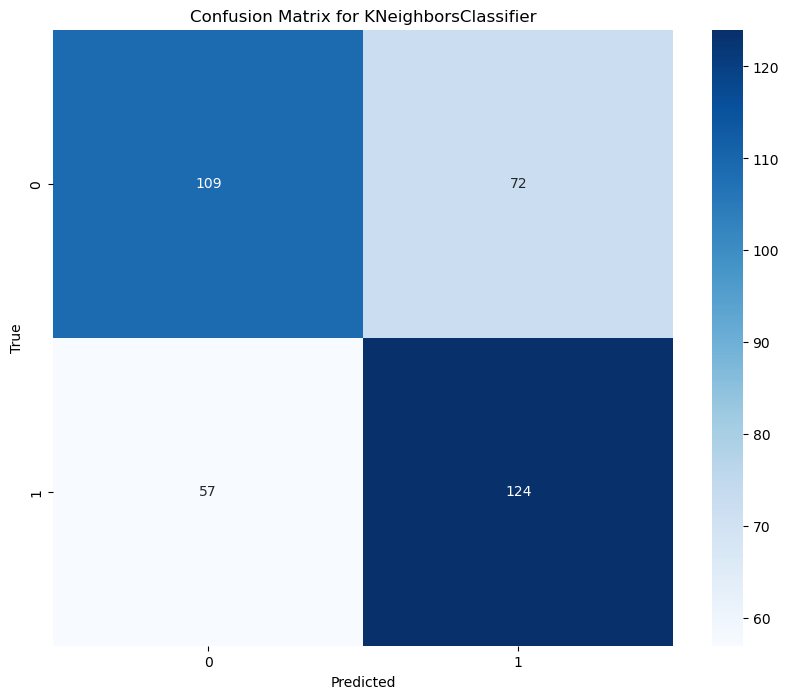


Random Forest:
Accuracy: 79.28%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       181
           1       0.83      0.74      0.78       181

    accuracy                           0.79       362
   macro avg       0.80      0.79      0.79       362
weighted avg       0.80      0.79      0.79       362



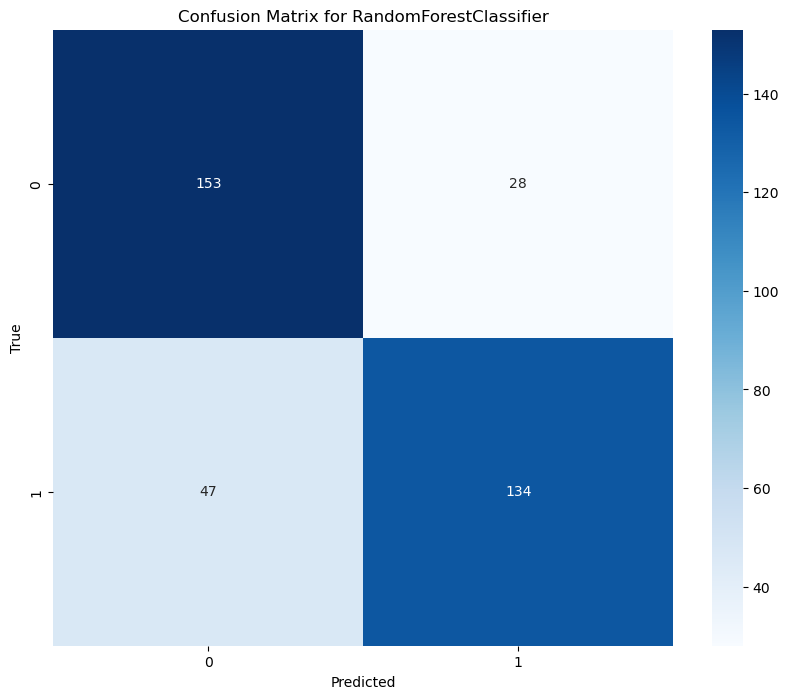


Decision Tree:
Accuracy: 69.61%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       181
           1       0.69      0.72      0.70       181

    accuracy                           0.70       362
   macro avg       0.70      0.70      0.70       362
weighted avg       0.70      0.70      0.70       362



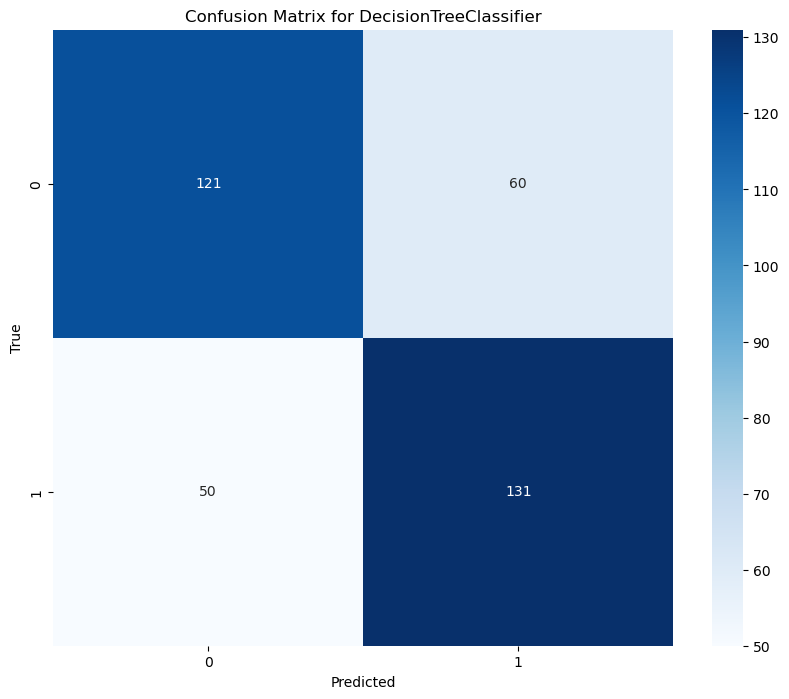


Gradient Boosting:
Accuracy: 79.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       181
           1       0.82      0.76      0.79       181

    accuracy                           0.80       362
   macro avg       0.80      0.80      0.80       362
weighted avg       0.80      0.80      0.80       362



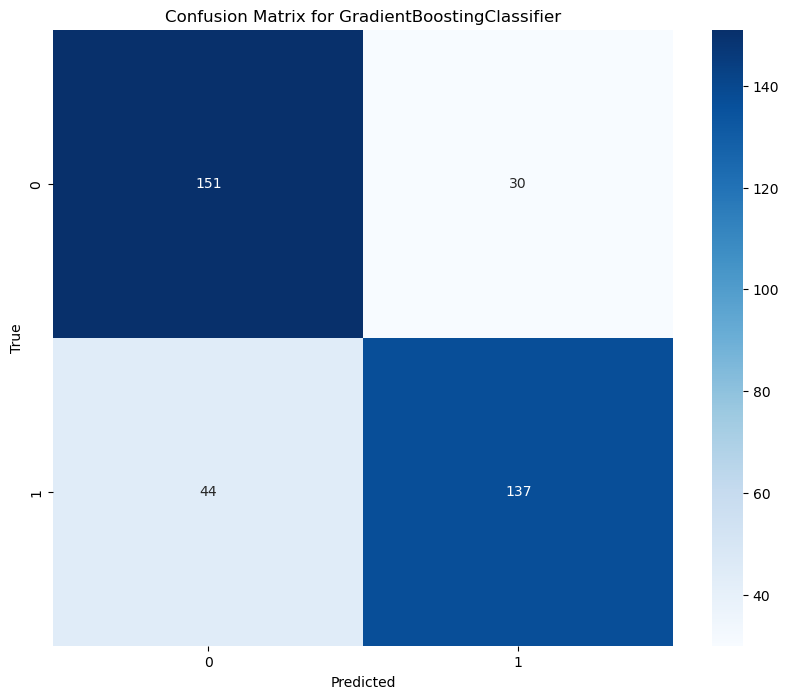


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 77.35%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       181
           1       0.79      0.75      0.77       181

    accuracy                           0.77       362
   macro avg       0.77      0.77      0.77       362
weighted avg       0.77      0.77      0.77       362



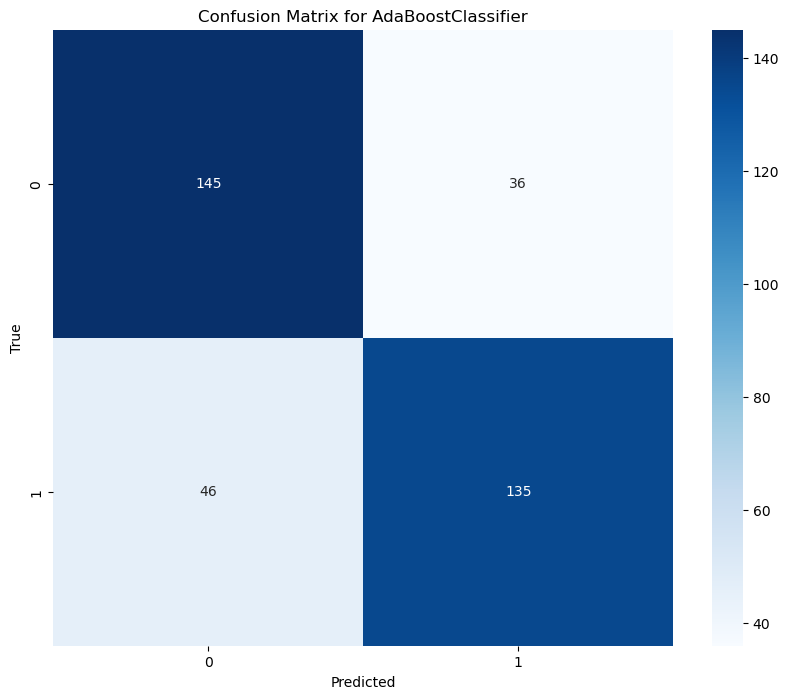


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 75.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       181
           1       0.76      0.76      0.76       181

    accuracy                           0.76       362
   macro avg       0.76      0.76      0.76       362
weighted avg       0.76      0.76      0.76       362



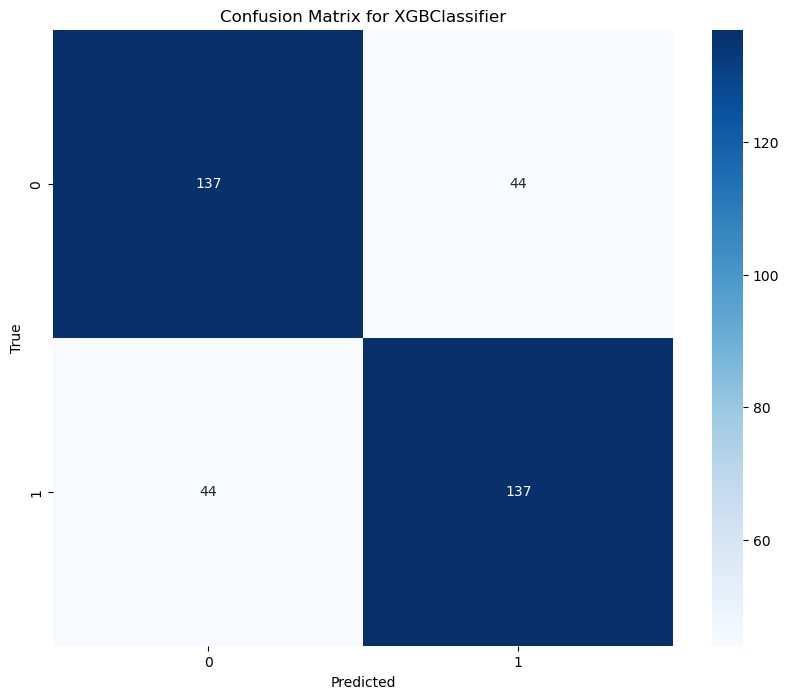



Finger Class: Index


LDA:
Accuracy: 81.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       182
           1       0.82      0.80      0.81       182

    accuracy                           0.81       364
   macro avg       0.81      0.81      0.81       364
weighted avg       0.81      0.81      0.81       364



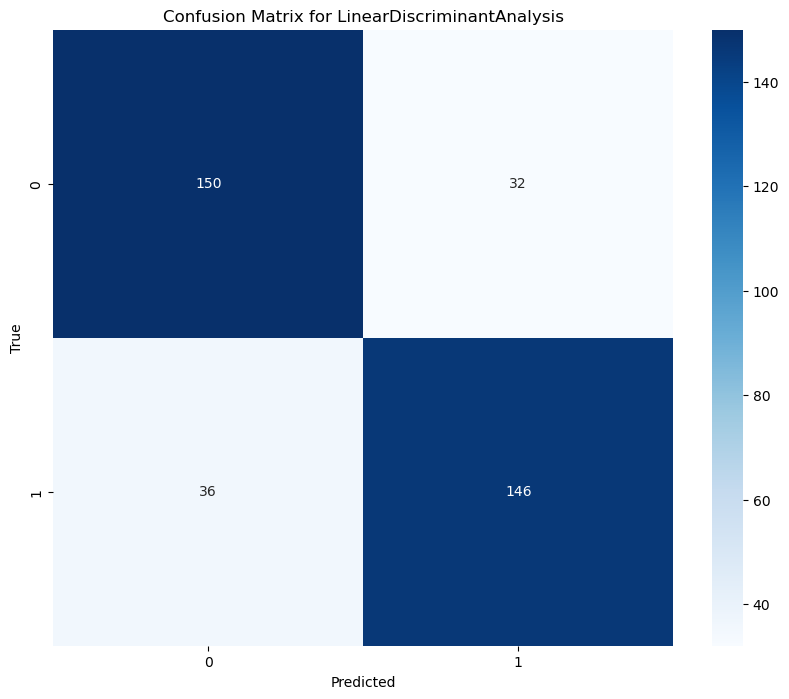


Logistic Regression:


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 75.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       182
           1       0.77      0.74      0.75       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364



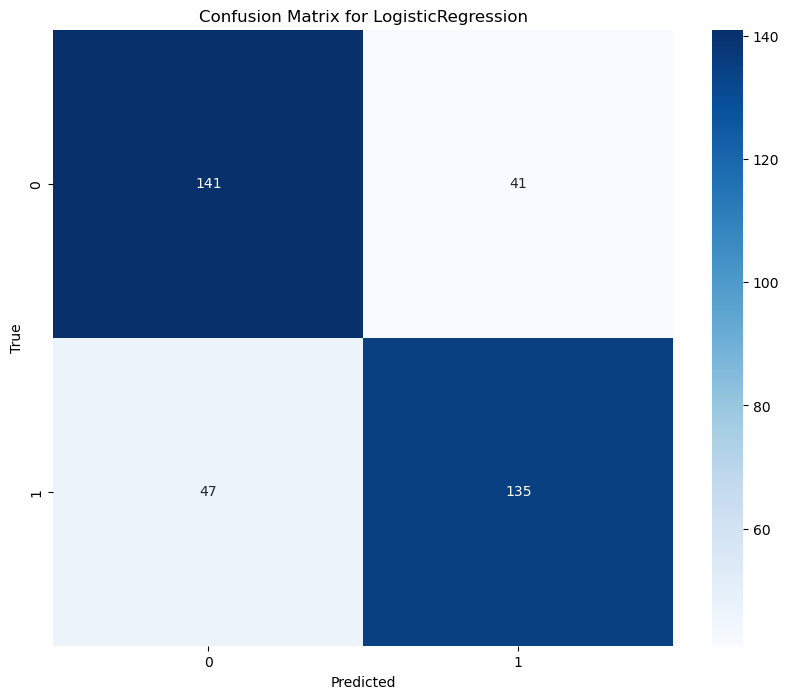


KNN:
Accuracy: 66.21%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       182
           1       0.66      0.68      0.67       182

    accuracy                           0.66       364
   macro avg       0.66      0.66      0.66       364
weighted avg       0.66      0.66      0.66       364



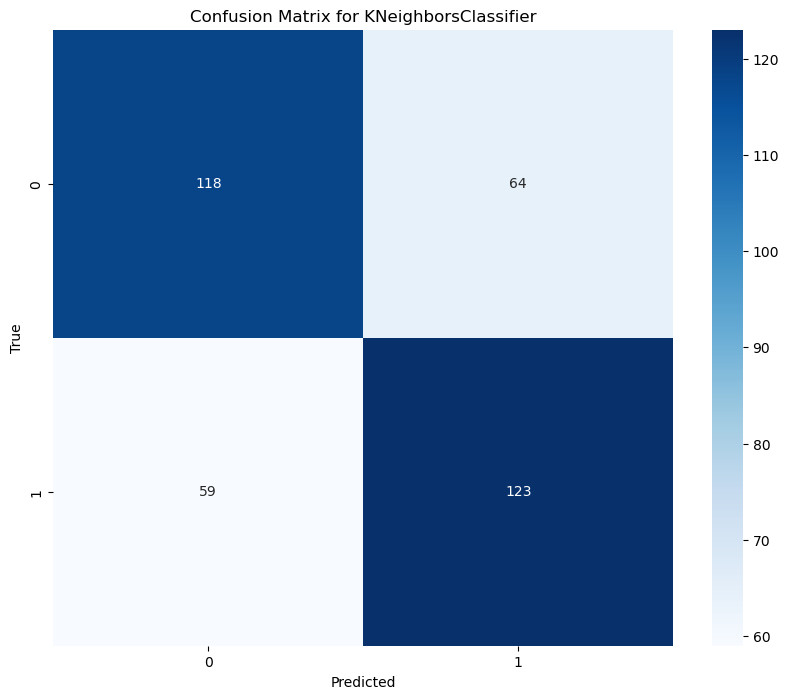


Random Forest:
Accuracy: 82.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       182
           1       0.85      0.79      0.81       182

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.82       364
weighted avg       0.82      0.82      0.82       364



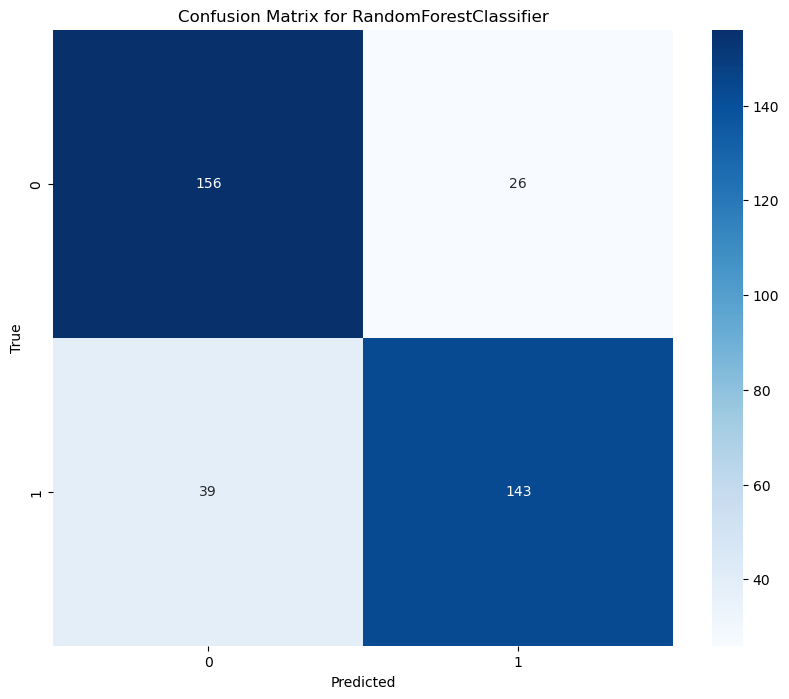


Decision Tree:
Accuracy: 67.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       182
           1       0.66      0.72      0.69       182

    accuracy                           0.67       364
   macro avg       0.67      0.67      0.67       364
weighted avg       0.67      0.67      0.67       364



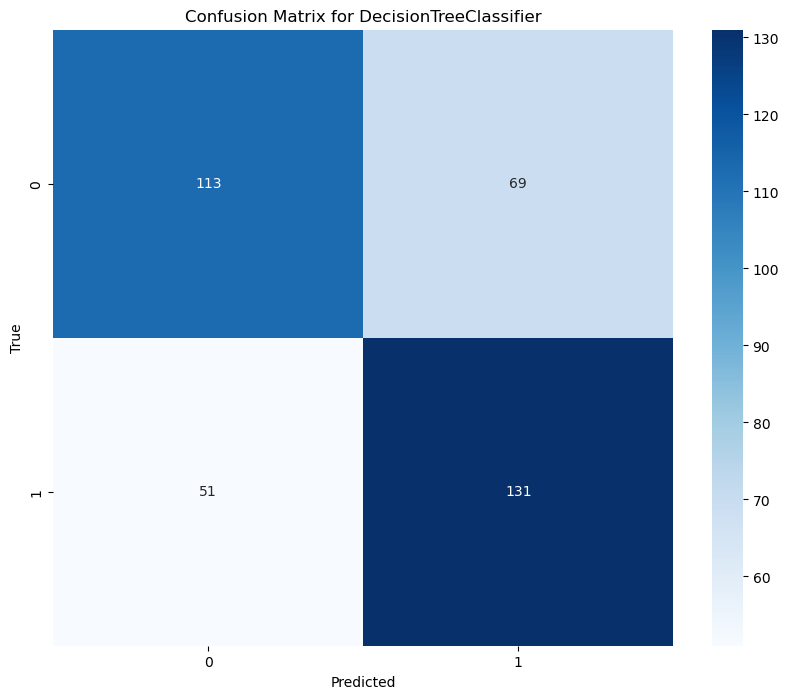


Gradient Boosting:
Accuracy: 80.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       182
           1       0.83      0.76      0.79       182

    accuracy                           0.80       364
   macro avg       0.80      0.80      0.80       364
weighted avg       0.80      0.80      0.80       364



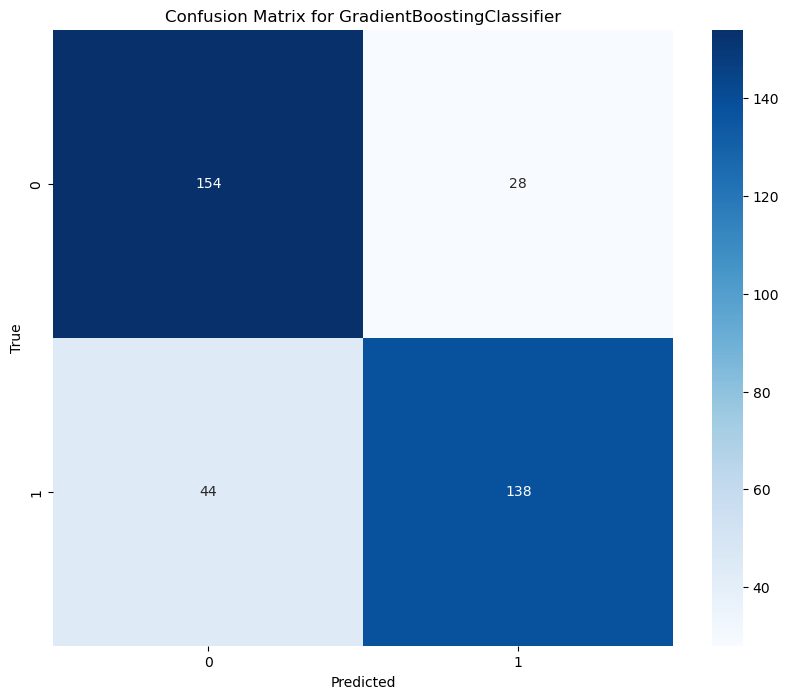


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 74.73%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       182
           1       0.75      0.75      0.75       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



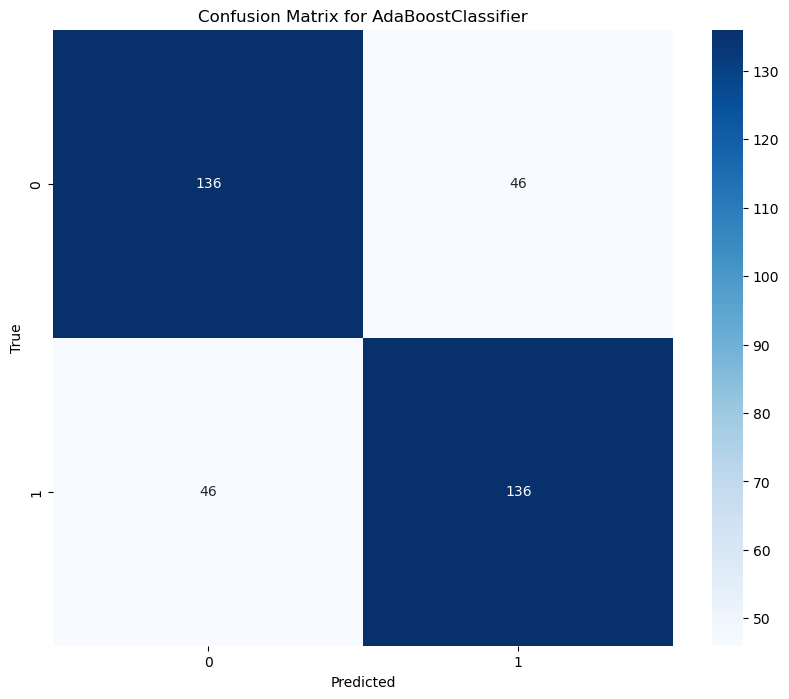


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 77.75%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       182
           1       0.80      0.74      0.77       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



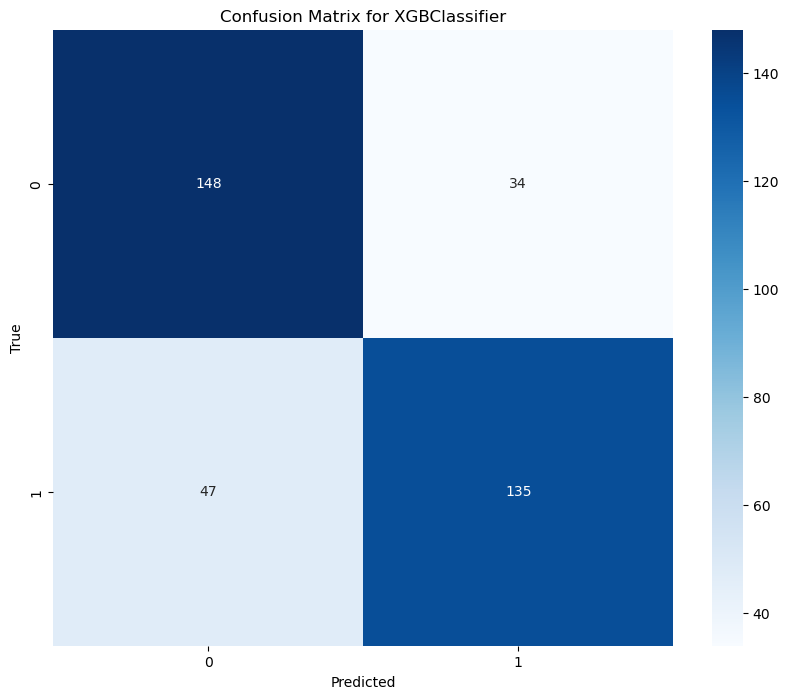



Finger Class: Middle


LDA:
Accuracy: 79.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.81       182
           1       0.84      0.72      0.78       182

    accuracy                           0.79       364
   macro avg       0.80      0.79      0.79       364
weighted avg       0.80      0.79      0.79       364



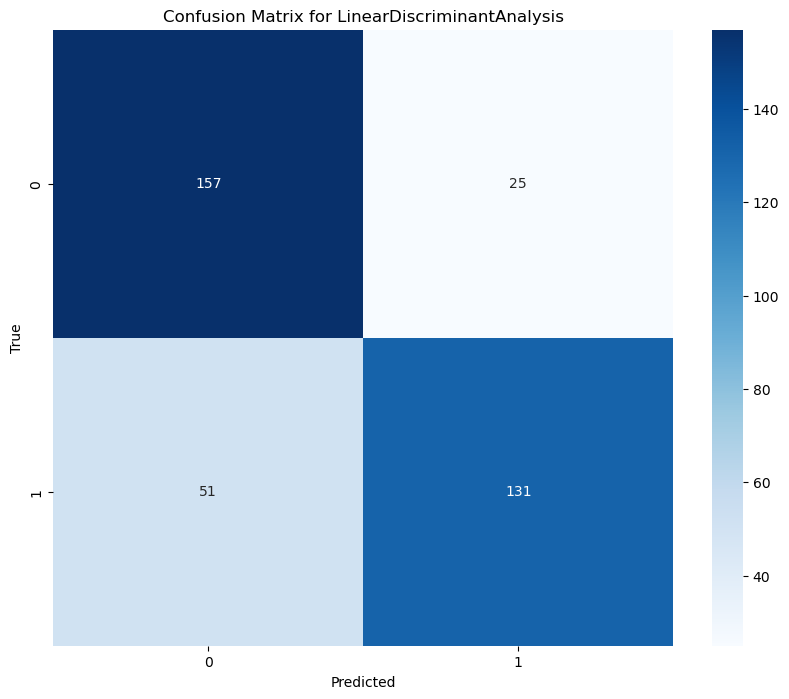


Logistic Regression:
Accuracy: 76.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       182
           1       0.78      0.74      0.76       182

    accuracy                           0.77       364
   macro avg       0.77      0.77      0.77       364
weighted avg       0.77      0.77      0.77       364



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


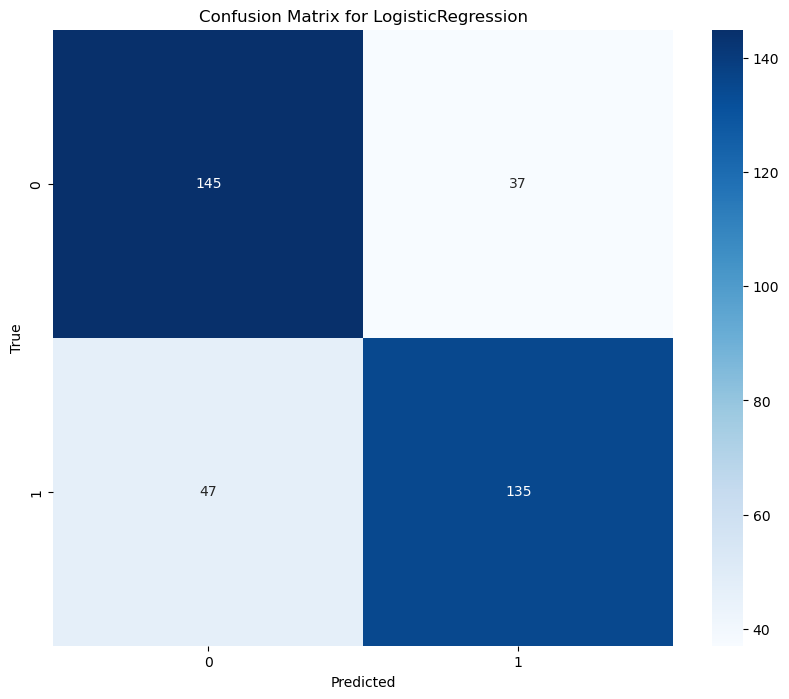


KNN:
Accuracy: 71.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       182
           1       0.69      0.79      0.74       182

    accuracy                           0.72       364
   macro avg       0.72      0.72      0.72       364
weighted avg       0.72      0.72      0.72       364



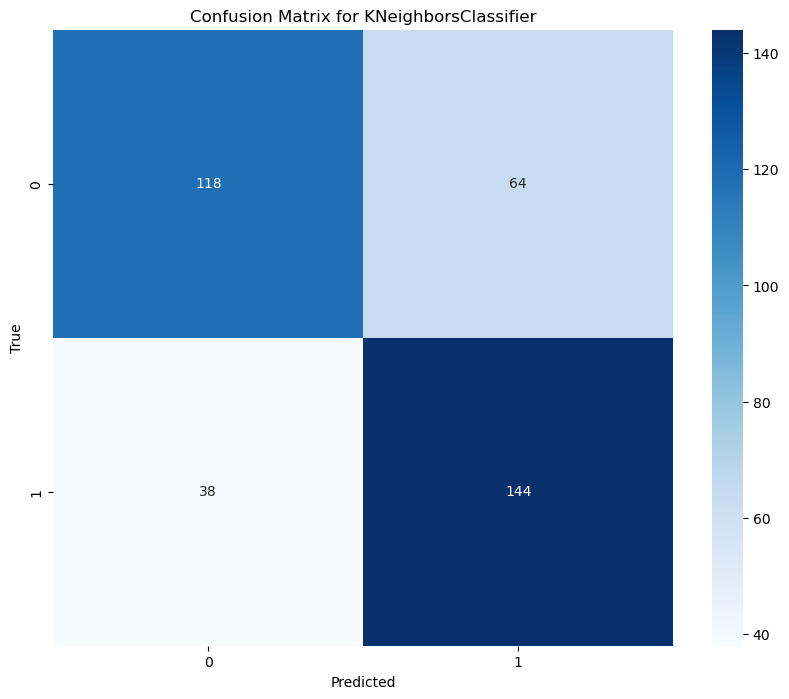


Random Forest:
Accuracy: 79.95%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       182
           1       0.85      0.73      0.78       182

    accuracy                           0.80       364
   macro avg       0.81      0.80      0.80       364
weighted avg       0.81      0.80      0.80       364



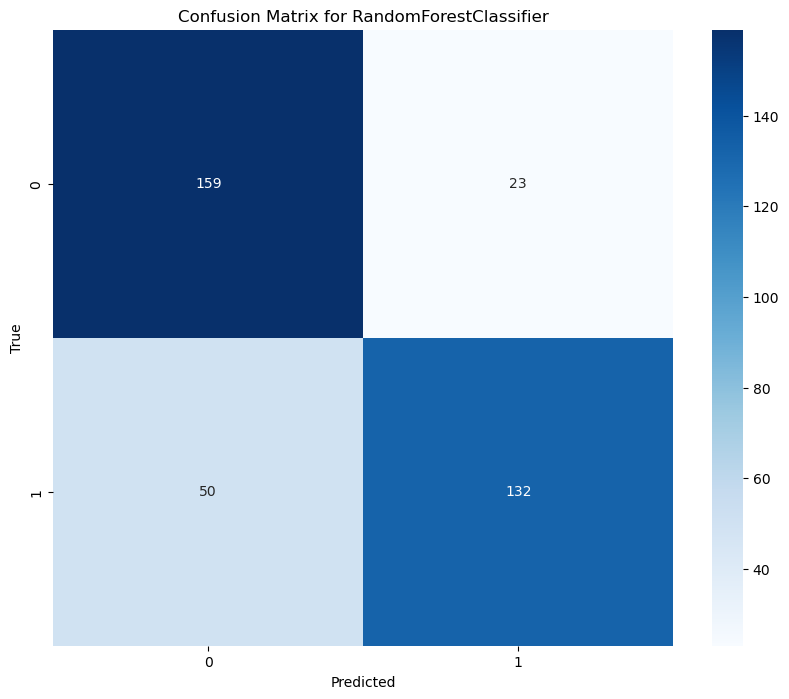


Decision Tree:
Accuracy: 65.38%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       182
           1       0.64      0.69      0.67       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



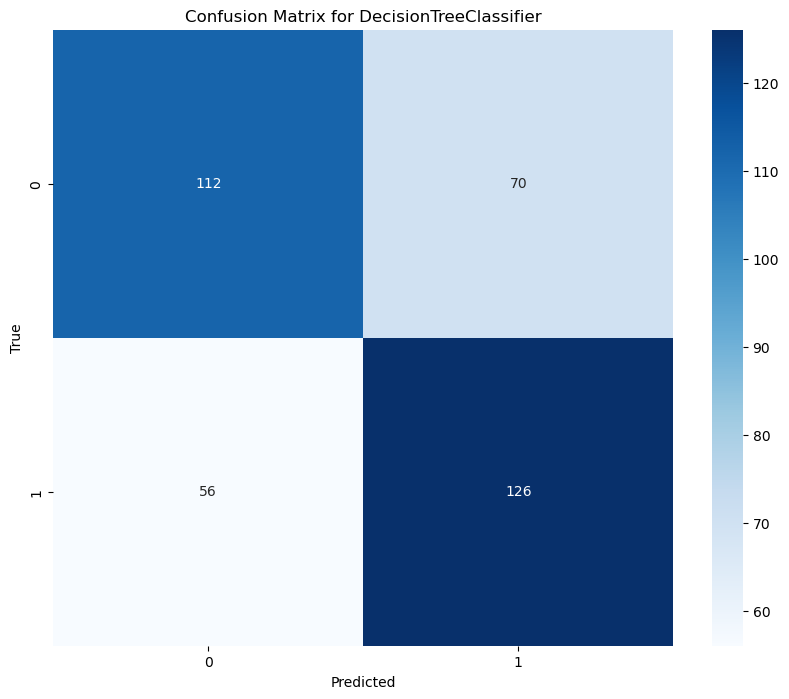


Gradient Boosting:
Accuracy: 81.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.83       182
           1       0.87      0.74      0.80       182

    accuracy                           0.81       364
   macro avg       0.82      0.81      0.81       364
weighted avg       0.82      0.81      0.81       364



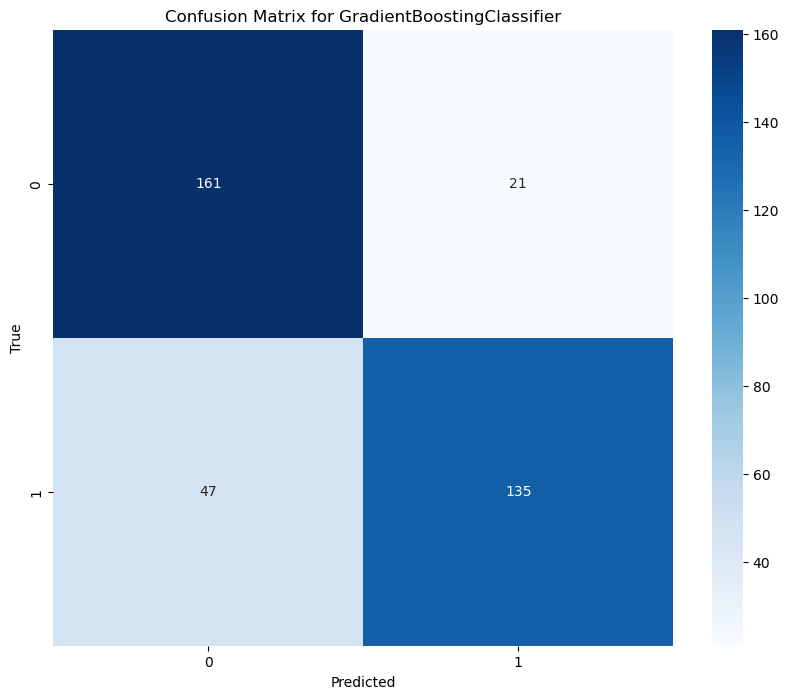


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 78.85%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       182
           1       0.82      0.74      0.78       182

    accuracy                           0.79       364
   macro avg       0.79      0.79      0.79       364
weighted avg       0.79      0.79      0.79       364



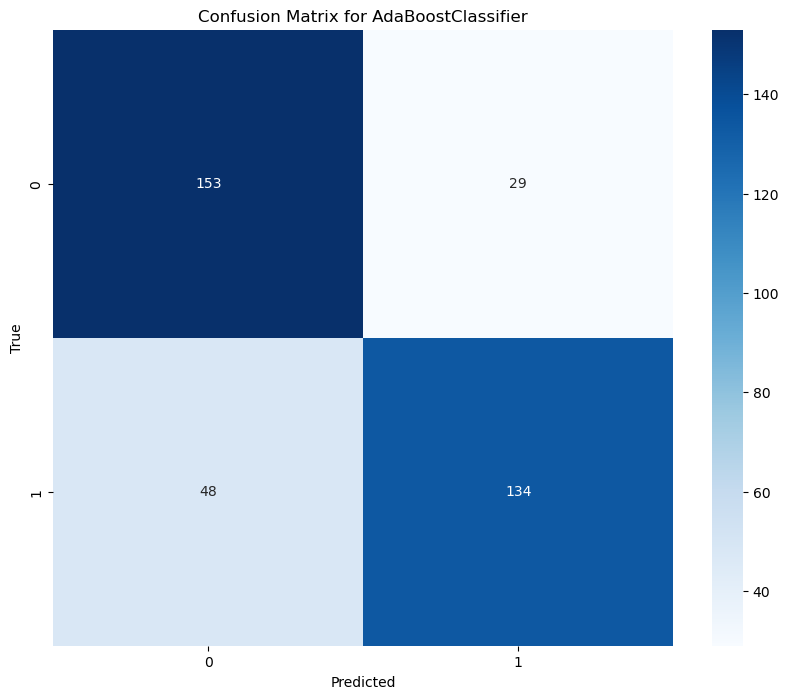


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:05:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 78.30%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       182
           1       0.81      0.74      0.77       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



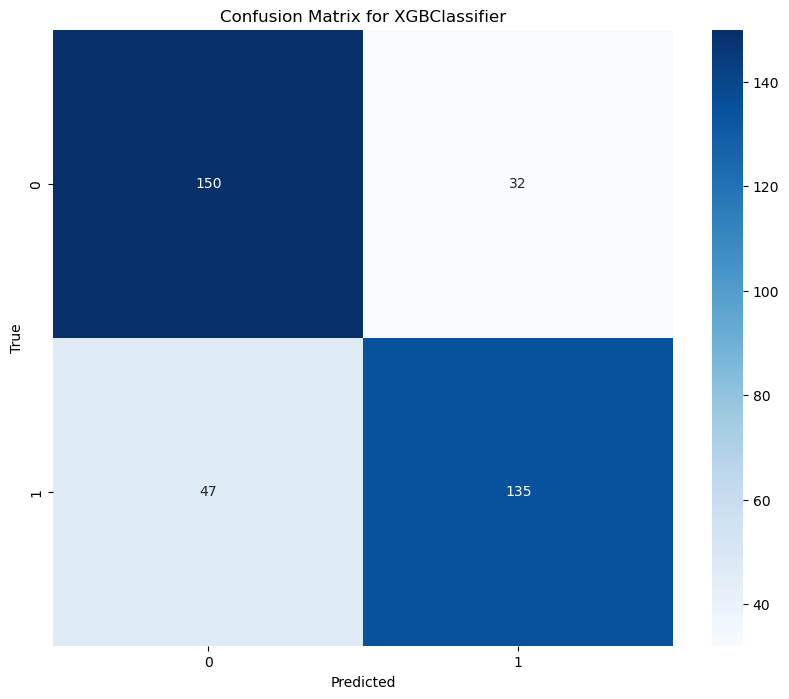



Finger Class: Ring


LDA:
Accuracy: 75.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       182
           1       0.76      0.74      0.75       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364



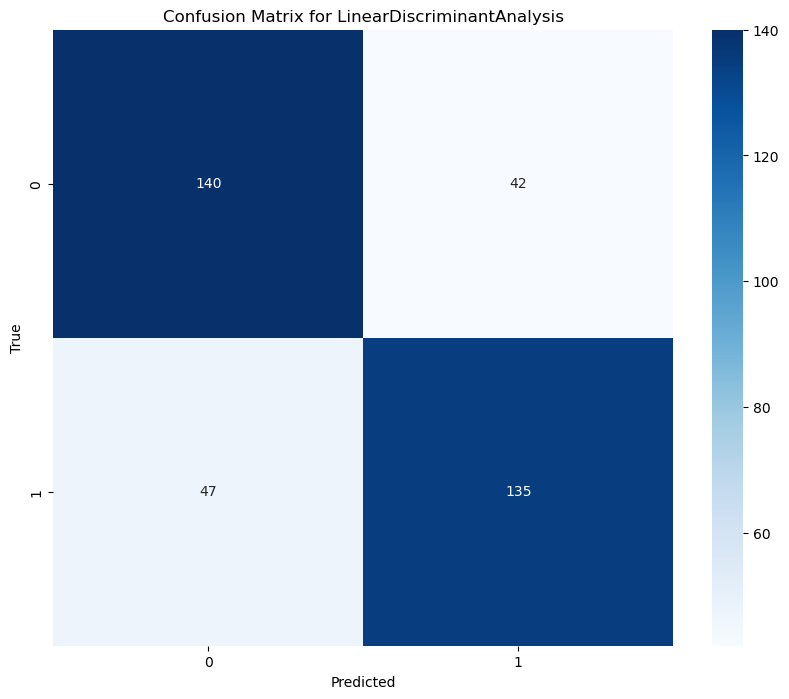


Logistic Regression:


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 71.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       182
           1       0.73      0.68      0.70       182

    accuracy                           0.71       364
   macro avg       0.71      0.71      0.71       364
weighted avg       0.71      0.71      0.71       364



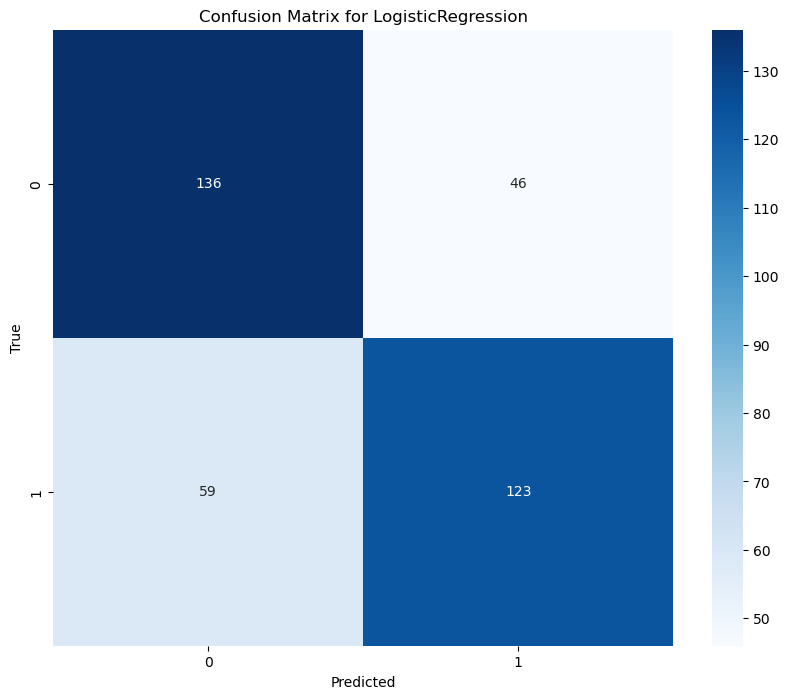


KNN:
Accuracy: 65.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       182
           1       0.66      0.61      0.64       182

    accuracy                           0.65       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.65      0.65      0.65       364



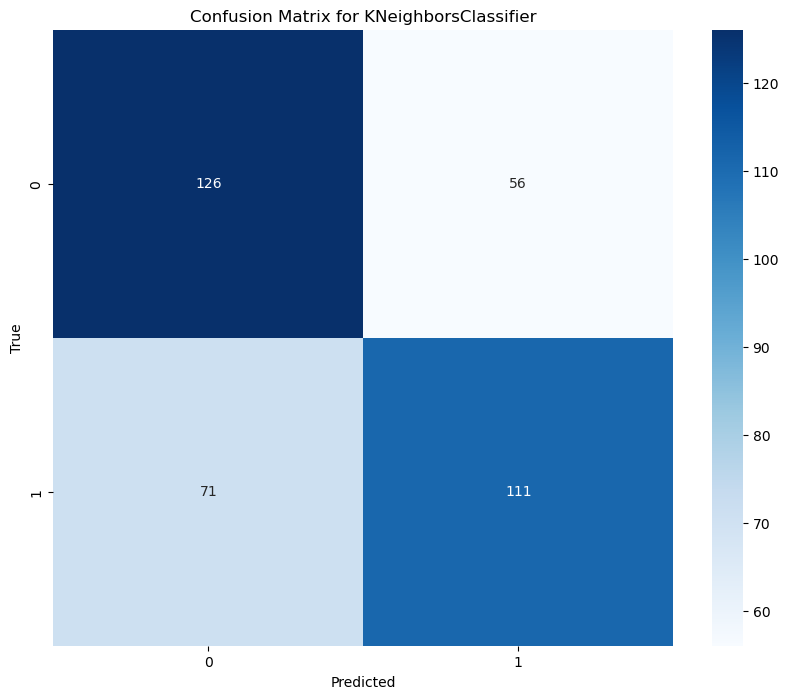


Random Forest:
Accuracy: 78.85%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       182
           1       0.86      0.69      0.77       182

    accuracy                           0.79       364
   macro avg       0.80      0.79      0.79       364
weighted avg       0.80      0.79      0.79       364



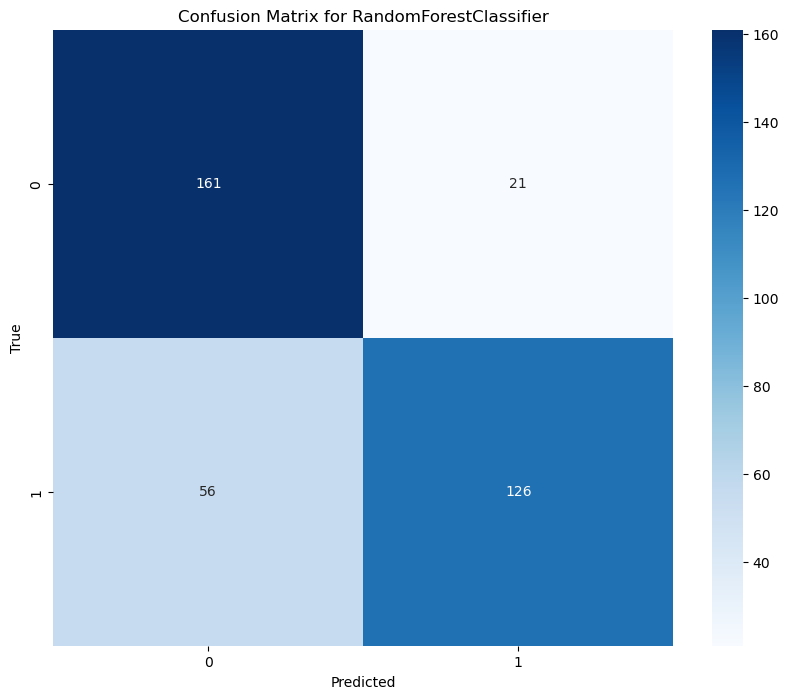


Decision Tree:
Accuracy: 72.25%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       182
           1       0.73      0.70      0.72       182

    accuracy                           0.72       364
   macro avg       0.72      0.72      0.72       364
weighted avg       0.72      0.72      0.72       364



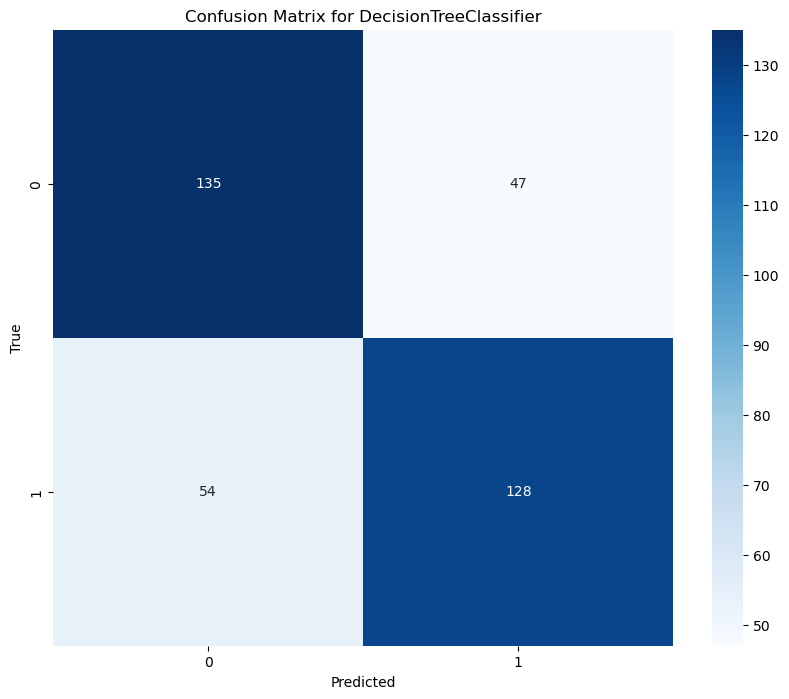


Gradient Boosting:
Accuracy: 77.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       182
           1       0.81      0.71      0.76       182

    accuracy                           0.77       364
   macro avg       0.78      0.77      0.77       364
weighted avg       0.78      0.77      0.77       364



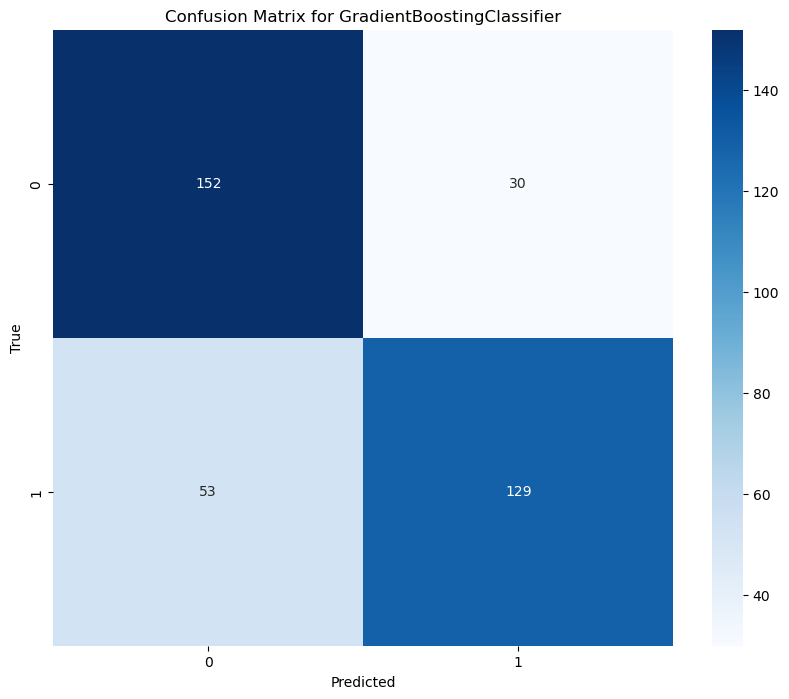


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 74.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       182
           1       0.78      0.68      0.73       182

    accuracy                           0.74       364
   macro avg       0.75      0.74      0.74       364
weighted avg       0.75      0.74      0.74       364



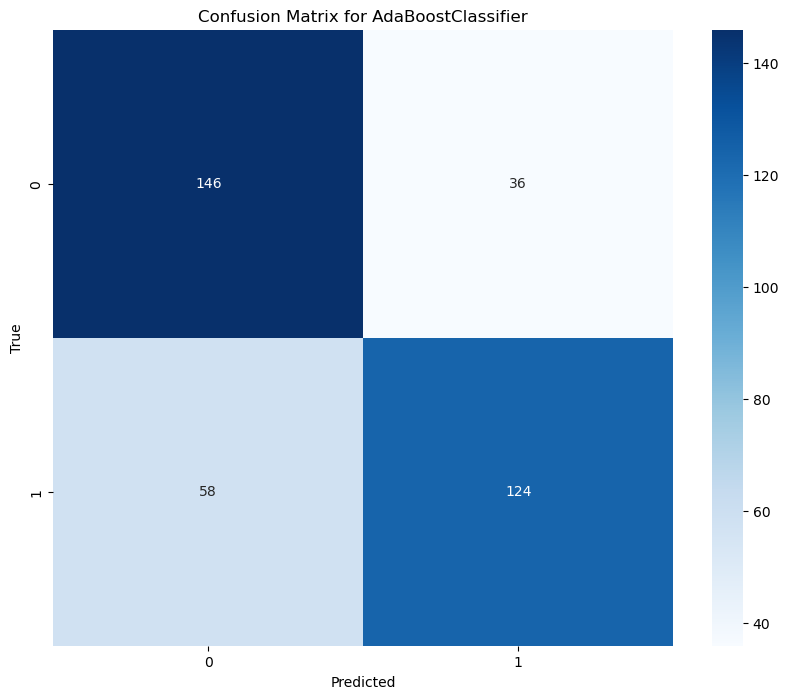


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:06:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 79.40%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       182
           1       0.84      0.73      0.78       182

    accuracy                           0.79       364
   macro avg       0.80      0.79      0.79       364
weighted avg       0.80      0.79      0.79       364



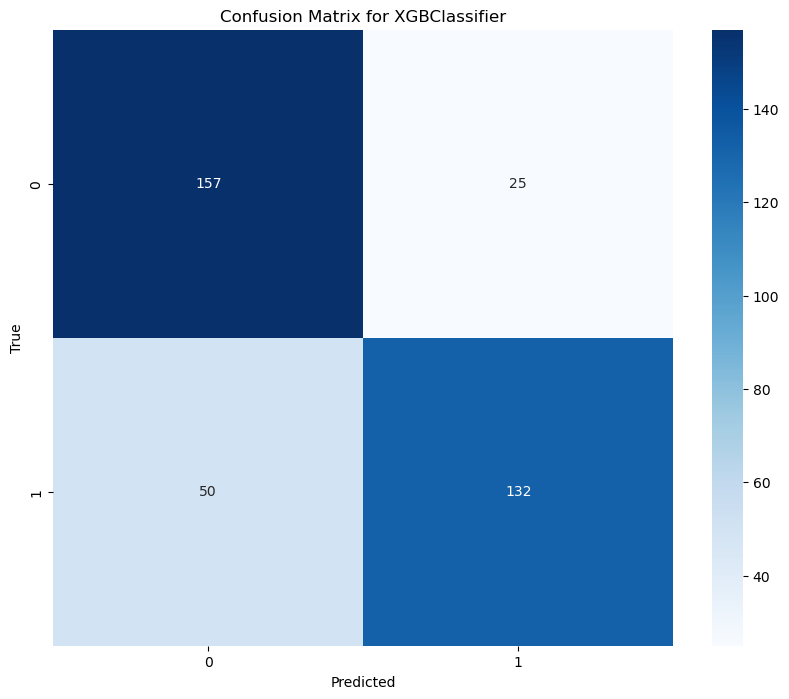



Finger Class: Pinky


LDA:
Accuracy: 78.57%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       182
           1       0.81      0.75      0.78       182

    accuracy                           0.79       364
   macro avg       0.79      0.79      0.79       364
weighted avg       0.79      0.79      0.79       364



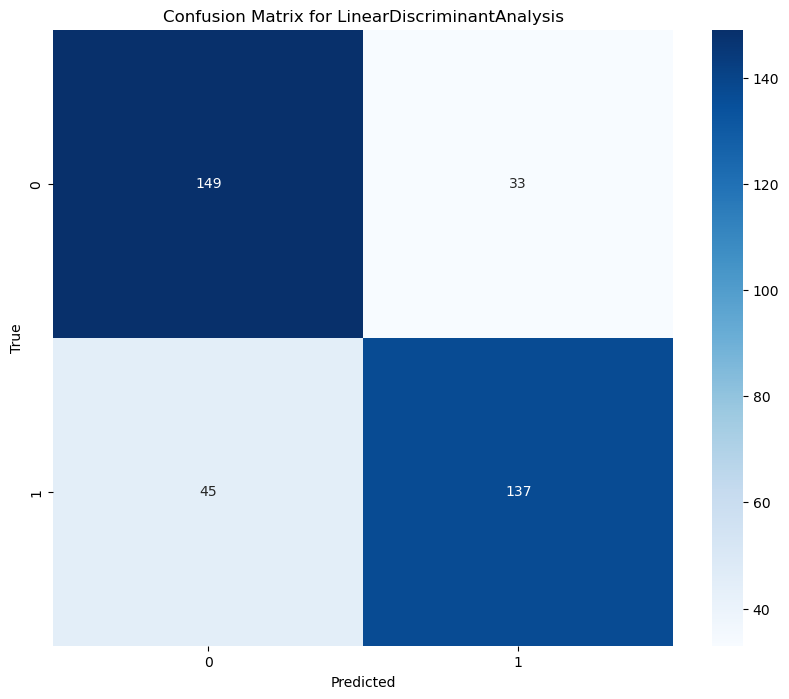


Logistic Regression:


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 75.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       182
           1       0.77      0.73      0.75       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364



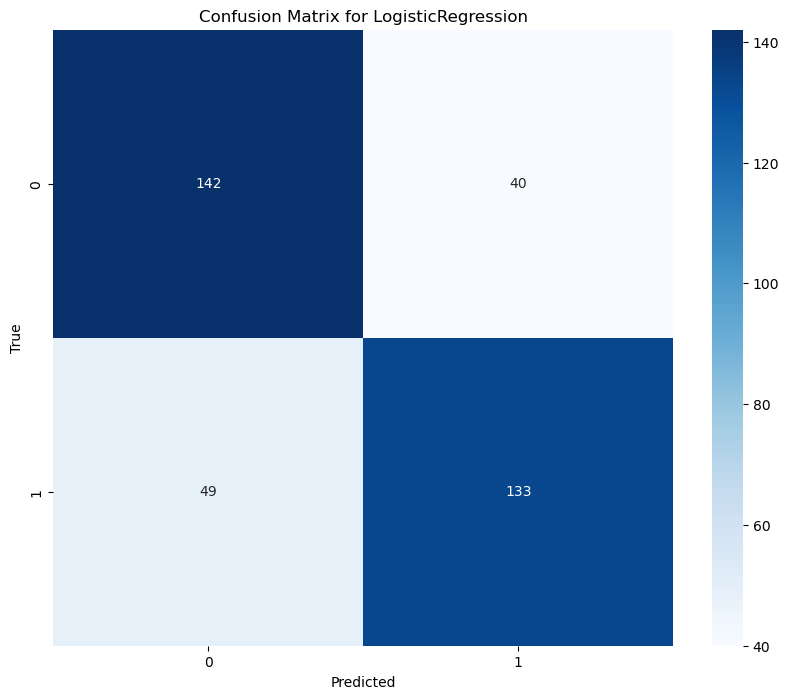


KNN:
Accuracy: 64.01%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       182
           1       0.63      0.66      0.65       182

    accuracy                           0.64       364
   macro avg       0.64      0.64      0.64       364
weighted avg       0.64      0.64      0.64       364



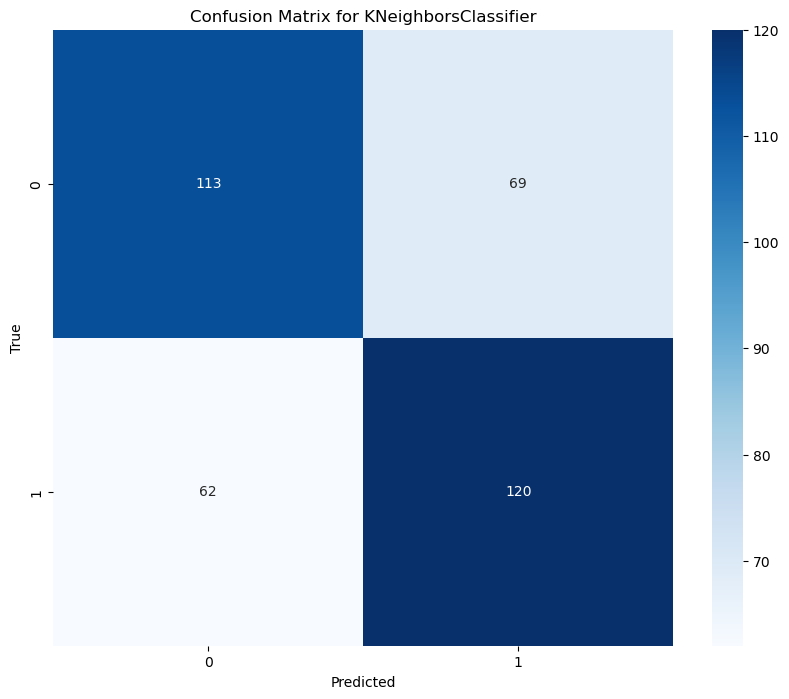


Random Forest:
Accuracy: 80.77%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       182
           1       0.85      0.74      0.79       182

    accuracy                           0.81       364
   macro avg       0.81      0.81      0.81       364
weighted avg       0.81      0.81      0.81       364



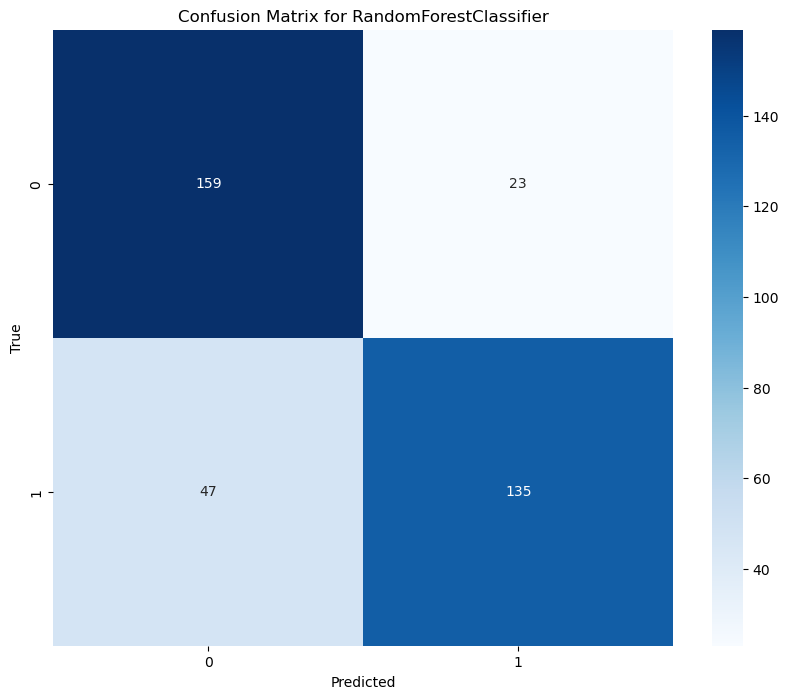


Decision Tree:
Accuracy: 68.96%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       182
           1       0.68      0.72      0.70       182

    accuracy                           0.69       364
   macro avg       0.69      0.69      0.69       364
weighted avg       0.69      0.69      0.69       364



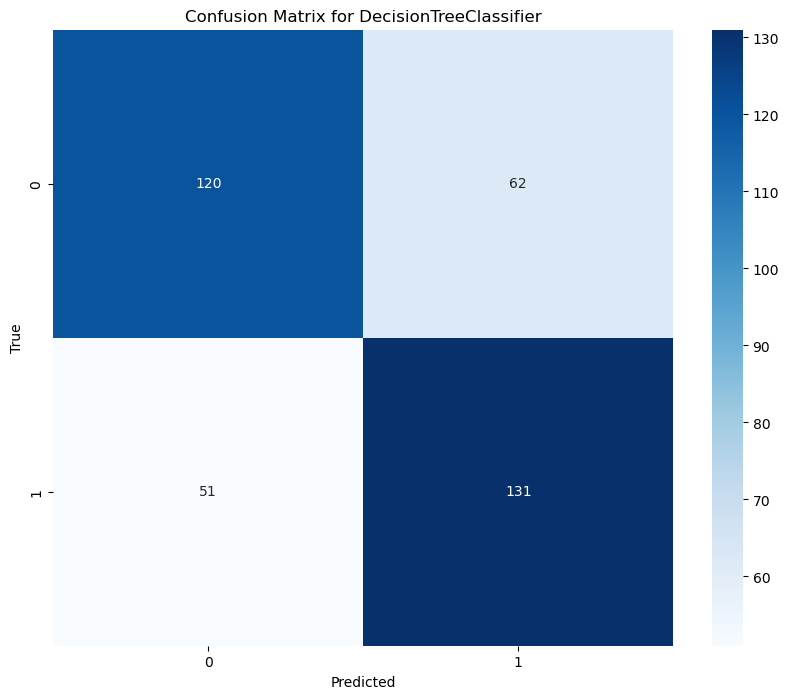


Gradient Boosting:
Accuracy: 81.04%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       182
           1       0.87      0.73      0.79       182

    accuracy                           0.81       364
   macro avg       0.82      0.81      0.81       364
weighted avg       0.82      0.81      0.81       364



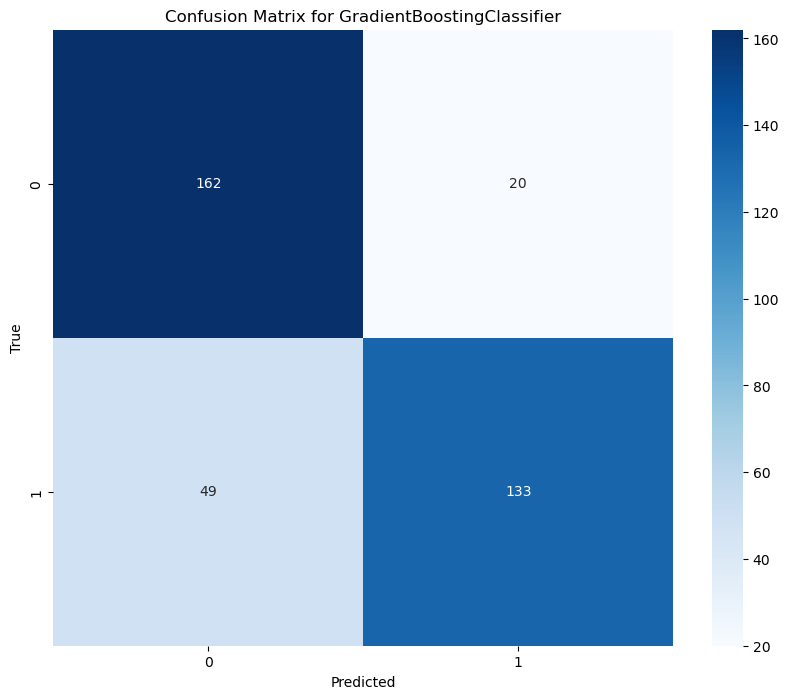


AdaBoost:


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 78.30%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       182
           1       0.80      0.75      0.78       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



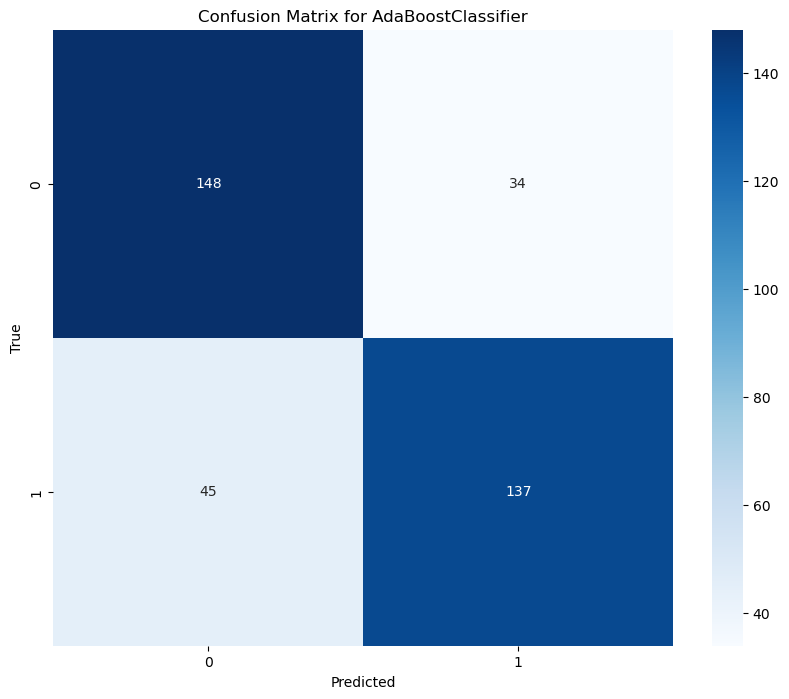


XGBoost:


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:06:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 77.75%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       182
           1       0.80      0.74      0.77       182

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



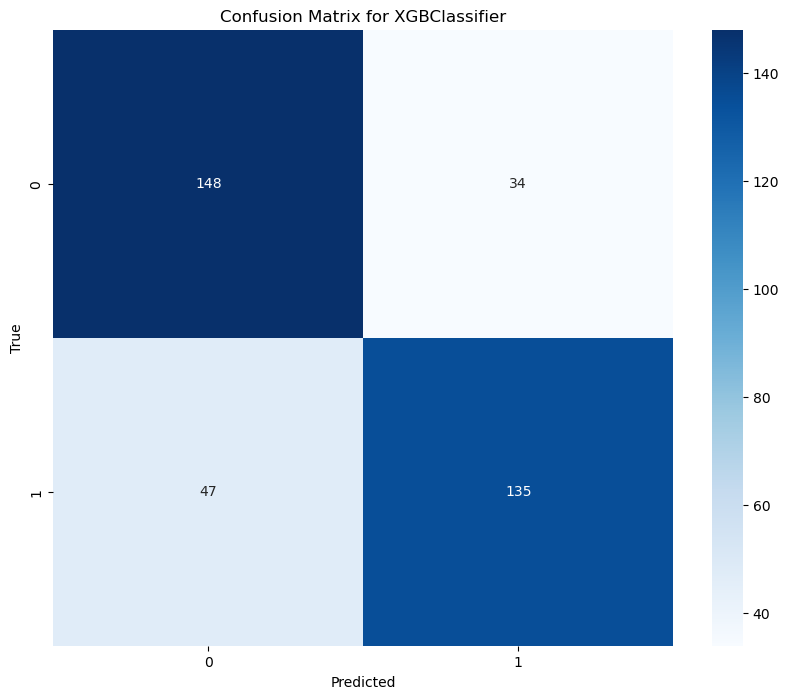

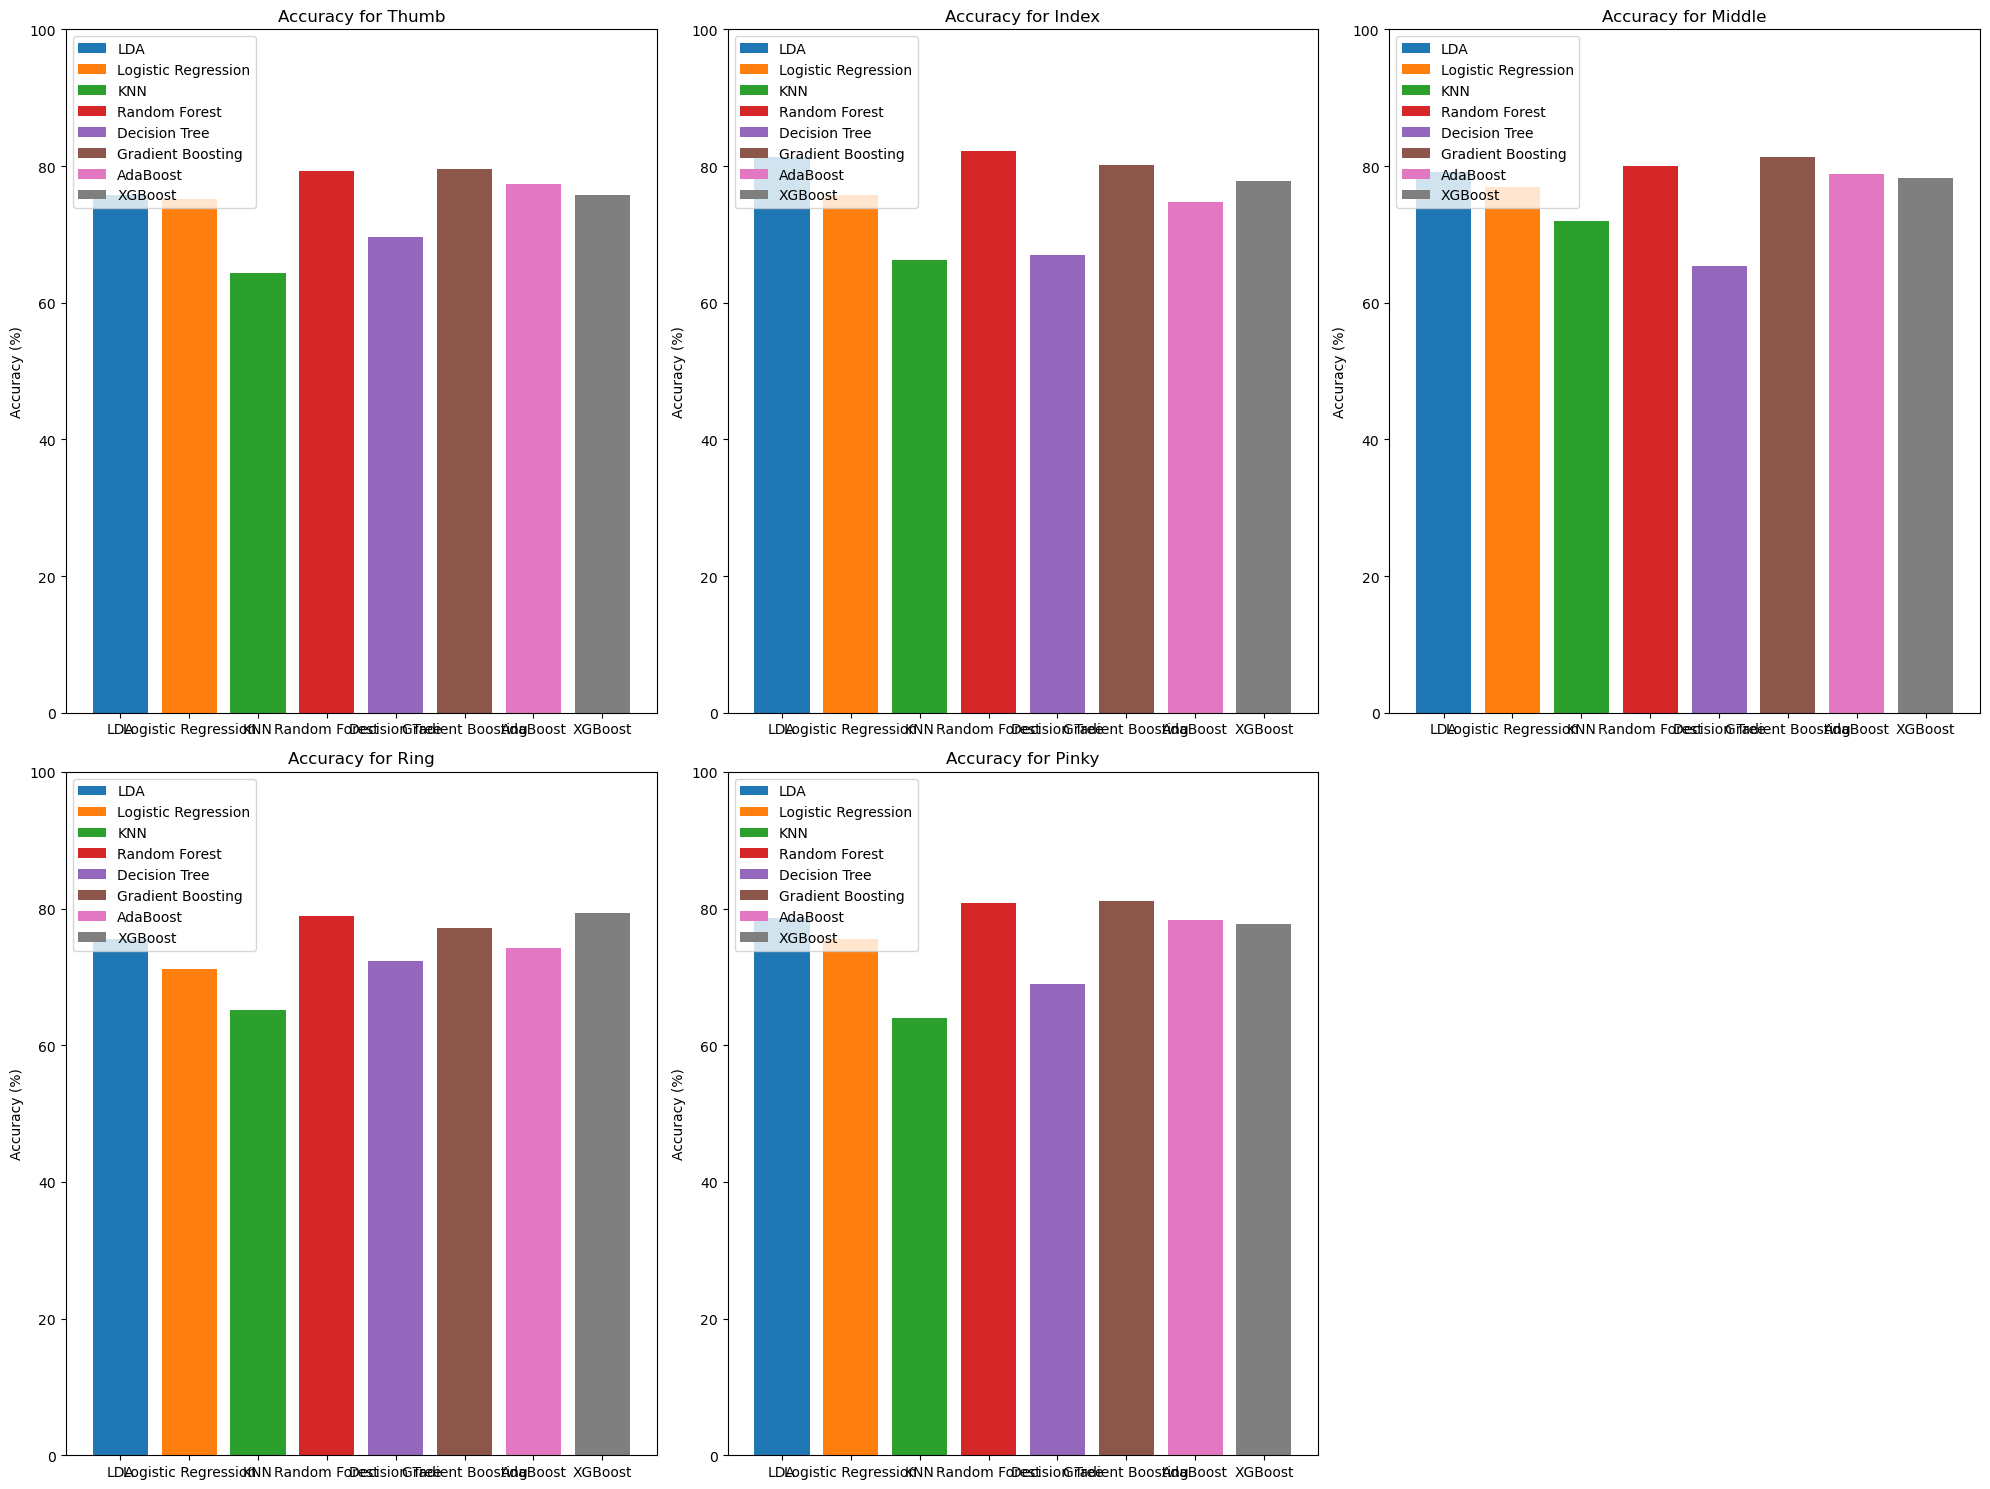

In [ ]:
# Evaluate each classifier for each finger class
for finger, (X_train_features_time, X_train_features_freq, X_test_features_time, X_test_features_freq, y_train_finger, y_test_finger) in finger_data.items():
    print(f"\n\nFinger Class: {finger}\n")

    for name, clf in classifiers.items():
        print(f"\n{name}:")
        X_train = np.concatenate((X_train_features_time, X_train_features_freq), axis=1)
        X_test = np.concatenate((X_test_features_time, X_test_features_freq), axis=1)
        accuracy, report, conf_matrix = evaluate_model(clf, X_train, X_test, y_train_finger, y_test_finger)
        results[finger][name]['accuracy'] = accuracy
        results[finger][name]['report'] = report
        results[finger][name]['conf_matrix'] = conf_matrix

# Plot accuracy of each finger class using bar plots
plt.figure(figsize=(20, 15))

# List of fingers for plotting
fingers = list(finger_data.keys())

for i, finger in enumerate(fingers, 1):
    plt.subplot(2, 3, i)
    plt.title(f'Accuracy for {finger}')
    plt.ylim(0, 100)
    plt.ylabel('Accuracy (%)')

    for name, result in results[finger].items():
        plt.bar(name, result['accuracy'], label=name)

    plt.legend()

plt.tight_layout()
plt.show()
